In [1]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import copy
import pandas as pd
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools


sns.set_context('paper',font_scale=1.2)

In [2]:
import os
os.chdir('results')

In [3]:
class Plot_Arguments():
    def __init__(self):
        self.epochs = 100
        self.legends = ["Main task - Black box", "Main task - Model Replacement", "Attack success rate - black box",
                        "Attack success rate - model replacement"]
        self.maxy = 110
        self.ylabel = 'Accuracy (%)'
        self.xlabel = 'FL rounds'
        self.colors = ['black',
                       '#339933',
                       '#fdae61',
                       '#d7191c', '#000000', '#B03A2E', '#85C1E9']
        self.patterns = ['x', 'o', 'd', 'v', '^', '<', '>']

In [9]:
import numpy as np

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)
        
def generate_histogram(plot_config, experiment_name, y_label, column_name, min_y, max_y, average=False, display_err = True, extension="pdf", label_rotation=15, std=None, x_fontsize=None, bar_fontsize=10):

    labels = []
    colors = []
    values = []
    errs = []
    
    for exp in plot_config["data"]:
        labels.append(exp["exp_name"])
        colors.append(exp["color"])
        if exp["file_path"] is None:

            values.append(min_y)

            errs.append(0)
        else:
            if average:
                max_value, std_dev = get_max_average(exp["file_path"],column_name)
                values.append(max_value)
                errs.append(std_dev)
            else:
                values.append(get_max_avg_value(exp["file_path"],column_name))
                errs.append(get_std_dev_value(exp["file_path"], column_name))
        
    # the histogram of the data
    print(errs)
    plot_args = Plot_Arguments()
    if std == None:
        errs = None
        
    values = [round(x,2) for x in values]
    print("Labels")
    print(labels)
    print(values)
    print(errs)
    ax = sns.barplot(x = labels,y =values, palette='Spectral')
    

    plot_args.ylabel= y_label

    ax.set_ylabel(plot_args.ylabel, fontsize=15)
    
    ax.tick_params(labelrotation=label_rotation)
    
    if x_fontsize != None:
            ax.tick_params(labelsize=x_fontsize)


    num_locations = 1
    hatches = itertools.cycle(['/',  '-', '//', '\\', '', 'o', 'O', '.'])
    for i, bar in enumerate(ax.patches):
        if i % num_locations == 0:
            hatch = next(hatches)
        bar.set_hatch(hatch)

    for i in ax.containers:
        try:
            ax.bar_label(i,[np.round(z,1) if z != min_y else "N/A" for z in values], fontsize=bar_fontsize)

        except:
            pass
    
    new_value = 0.4
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)
        
    ax.set(ylim=(min_y, max_y))
    ax.set_xlabel('')
    ax.set_title('')
    plt.savefig('./figures/{}_{}.{}'.format(plot_config['dataset_name'], experiment_name, extension),bbox_inches='tight')

    plt.show()
    

In [10]:
def generate_xy_plot(plot_config, experiment_name, y_label, column_name, min_y=0, max_y=100, min_x=0, max_x=100, average=False, extension='.pdf', markevery=5, max_range = None):
    
    labels = []
    colors = []
    values = []
    markers = []
    
    for exp in plot_config["data"]:
        
        if exp["file_path"] is None:
            continue
            
        labels.append(exp["exp_name"])
        colors.append(exp["color"])
        markers.append(exp["symbol"])
        if average:
            values.append(compute_average_per_round(exp["file_path"],column_name))
        else:
            values.append(get_max_avg_value(exp["file_path"],column_name))
    
    if max_range is not None : 
        for i in range(len(values)):
            values[i] = values[i][:max_range]
    plot_args = Plot_Arguments()
    fig, ax = plt.subplots()
    plot_args.ylabel= y_label

    x = range(1, len(values[0]) + 1)
    
    for i in range(len(labels)):
        print(labels[i])
        print(len(values[i]))
        ax.plot(x, values[i], color= colors[i] ,label=labels[i], linewidth=1, marker=markers[i], markersize=6, markevery=markevery+i)
            
    plt.ylabel(plot_args.ylabel)
    plt.xlabel(plot_args.xlabel)
    change_width(ax, .2)
    # plt.subplots_adjust(top=0.75)
    lgd = ax.legend(ncol=3, loc="lower center", bbox_to_anchor=[0.5, -0.55])
    ax.set_xlim(1, len(values[0])+1)
    ax.set_ylim(min_y, max_y)
    ax.set_xlim(min_x, max_x)
    


    
    plt.savefig('./figures/{}_{}.{}'.format(plot_config['dataset_name'], experiment_name, extension),bbox_inches='tight')

    plt.show()
    

        

In [11]:
def generate_tradeoff_plot(plot_config, experiment_name, x_label, y_label, x_column_name, y_column_name, min_y, max_y, min_x, max_x, average=False, extension="pdf", max_round = None, markerscale=1.5, legend_fontsize=10):
    
    labels = []
    colors = []
    values = []
    markers = []
    x_values = []
    y_values = []
    
    for exp in plot_config["data"]:
        if exp["file_path"] is None:
            continue
        labels.append(exp["exp_name"])
        colors.append(exp["color"])
        markers.append(exp["symbol"])
        if average:
            

            x_values.append(get_max_average(exp["file_path"],x_column_name, max_round))
            y_values.append(get_max_average(exp["file_path"],y_column_name, max_round))

        else:
            x_values.append(get_max_avg_value(exp["file_path"],x_column_name))
            y_values.append(get_max_avg_value(exp["file_path"],y_column_name))

        
    
    x_axis = [x for (x,_) in x_values]
    y_axis = [x for (x,_) in y_values]
    plot_args = Plot_Arguments()
    fig, ax = plt.subplots()
    plot_args.xlabel = x_label
    plot_args.ylabel= y_label
    
    ax = sns.scatterplot(x=x_axis, y= y_axis, hue=labels, style=labels,s=200, palette='Spectral', markers=True)
    
#    for line in range(0,len(y_axis)):
#        ax.text(x_axis[line]*1.001, y_axis[line], "P = {}%\nU = {}%".format(str(round(y_axis[line],1)), str(round(x_axis[line],1))), horizontalalignment='left', 
#         size='medium', color='black')

    handles, labels  =  ax.get_legend_handles_labels()

    ax.legend(handles, labels,markerscale=markerscale, fontsize=legend_fontsize)

    ax.set_ylabel(y_label, fontsize=15)
    ax.set_xlabel(x_label, fontsize=15)
    ax.set(ylim=(min_y, max_y), xlim=( min_x, max_x))

    
#     for i, txt in enumerate(labels):
#         ax.annotate(txt, (x_values[i] + 2 , y_values[i] -1), fontsize=8)
    
    plt.savefig('./figures/{}_{}.{}'.format(plot_config['dataset_name'], experiment_name, extension),bbox_inches='tight')

    plt.show()
    

In [12]:
def compute_average_per_round(file_path, column_name):
    data = pd.read_csv(file_path)
    columns_to_aggregate = data.columns[data.columns.str.contains(column_name)]
    columns_to_aggregate = [x for x in columns_to_aggregate if "per_epoch" not in x]

    values = data[columns_to_aggregate].mean(axis=1)
    return values.to_list()

def compute_average(file_path, column_name):
    return compute_average_per_round(file_path, column_name)[-1]
   
    
def get_max_average(file_path, column_name, max_round=None):
    data = pd.read_csv(file_path)
    columns_to_aggregate = data.columns[data.columns.str.contains(column_name)]
    columns_to_aggregate = [x for x in columns_to_aggregate if "per_epoch" not in x]
    print("Columns to aggregate")
    print(columns_to_aggregate)
    maxs = []
    for column in columns_to_aggregate:
        if max_round is not None:
            values = data[column].to_list()[:max_round]
            print(values)
        else:
            values = data[column].to_list()
        maxs.append(max(values[-10:]))
    print(maxs)
    
    if len(columns_to_aggregate)==1:
        std_dev = np.std([x for x in data[columns_to_aggregate[0]].to_list() if x!= 0])
    else:
        std_dev = np.std(maxs)
    
    return sum(maxs)/len(maxs), std_dev

def get_max_values_per_client(file_path, column_name):
    
    data = pd.read_csv(file_path)
    values = []
    
    columns_to_compute = data.columns[data.columns.str.contains(column_name)]
    columns_to_compute = [x for x in columns_to_compute if "per_epoch" not in x]

    
    for column in columns_to_compute:
        values.append(max(data[column].to_list()))
        
    return values



def get_max_avg_value(file_path, column_name):
    data = pd.read_csv(file_path)
    columns_to_aggregate = data.columns[data.columns.str.contains(column_name)]
    columns_to_aggregate = [x for x in columns_to_aggregate if "per_epoch" not in x]

    values = data[columns_to_aggregate].mean(axis=1)
    return sum(values.to_list()[-10:])/10


def get_std_dev_value(file_path, column_name):
    data = pd.read_csv(file_path)
    columns_to_aggregate = data.columns[data.columns.str.contains(column_name)]
    columns_to_aggregate = [x for x in columns_to_aggregate if "per_epoch" not in x]

    values = data[columns_to_aggregate].std(axis=1)
    return values.to_list()[-1]


In [13]:
def plot_xy(plot_config, experiment_name, y_label, column_name, min_y, max_y, min_x, max_x, average=False):
    
    labels = []
    colors = []
    values = []
    markers = []

    for exp in plot_config["data"]:

        if exp["file_path"] is None:
            continue

        labels.append(exp["exp_name"])
        colors.append(exp["color"])
        markers.append(exp["symbol"])
        if average:
            values.append(compute_average_per_round(exp["file_path"],column_name))
        else:
            values.append(get_column(exp["file_path"],column_name))


    plot_args = Plot_Arguments()
    fig, ax = plt.subplots()
    plot_args.ylabel= y_label

    #x = range(1, len(values[0]) + 1)


    df = pd.DataFrame(values)
    df = df.transpose()
    df.set_axis(labels, axis=1, inplace=True)




    sns.lineplot(data=df,palette='magma_r',markers=True, dashes=False)

    plt.ylabel(plot_args.ylabel)
    plt.xlabel(plot_args.xlabel)
    change_width(ax, .2)
    # plt.subplots_adjust(top=0.75)
    lgd = ax.legend(ncol=3, loc="lower center", bbox_to_anchor=[0.5, -0.55])
    #ax.set_xlim(1, len(values[0]))
    ax.set_ylim(min_y, max_y)
    ax.set_xlim(min_x, max_x)


    plt.savefig('./figures/{}_{}.pdf'.format(plot_config['dataset_name'], experiment_name),bbox_inches='tight')

    plt.show()

## CIFAR-10 Resnet

In [14]:
plot_config = {
                "dataset_name": "cifar10_resnet",
                "dataset_pretty_name" : "CIFAR10",

                "data":[
                        {
                            "exp_name" : "No defense",
                            "file_path": "resnet_ppm_baseline_cifar.csv",
                            "color": "black",
                            "symbol" : "+"
                        },

                    {
                            "exp_name" : "PASTEL-P",
                            "file_path": "resnet_ppm_bn17_cifar.csv",
                            "color": "grey",
                            "symbol" : "*"
                        },          
                           
                            {
                            "exp_name" : "PASTEL",
                            "file_path": "ppm_posterior_flattening_relaxloss_uniform_cifar_resnet.csv",
                            "color": "brown",
                            "symbol" : "x"
                        }
                    ]
                }
            


Columns to aggregate
['client_attack_0']
[69.1]
Columns to aggregate
['client_attack_0']
[50]
Columns to aggregate
['client_attack_0']
[50.0]
[0.0, 0.0, 0.0]
Labels
['No defense', 'PASTEL-P', 'PASTEL']
[69.1, 50.0, 50.0]
None


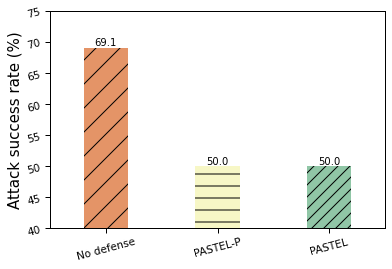

Columns to aggregate
['server_attack']
[66.4]
Columns to aggregate
['server_attack']
[50]
Columns to aggregate
['server_attack']
[50.0]
[0.0, 0.0, 0.0]
Labels
['No defense', 'PASTEL-P', 'PASTEL']
[66.4, 50.0, 50.0]
None


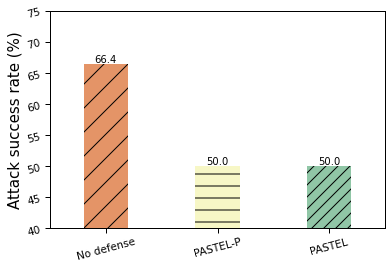

Columns to aggregate
['client_accuracy_0']
[69.12]
Columns to aggregate
['client_accuracy_0']
[68.83528893888895]
Columns to aggregate
['client_accuracy_0']
[68.69931862045735]
[4.388187780849857, 4.402870043366415, 4.380907219915579]
Labels
['No defense', 'PASTEL-P', 'PASTEL']
[69.12, 68.84, 68.7]
None


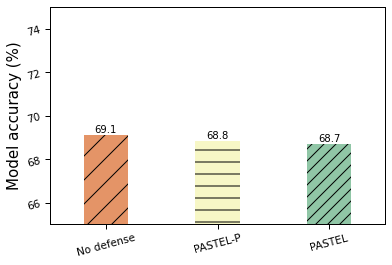

Columns to aggregate
['client_accuracy_0']
[69.12]
Columns to aggregate
['client_attack_0']
[69.1]
Columns to aggregate
['client_accuracy_0']
[68.83528893888895]
Columns to aggregate
['client_attack_0']
[50]
Columns to aggregate
['client_accuracy_0']
[68.69931862045735]
Columns to aggregate
['client_attack_0']
[50.0]


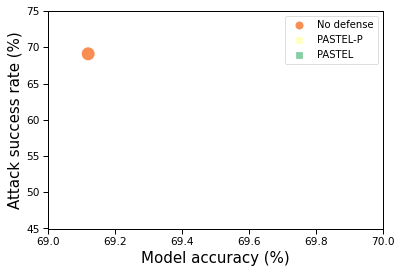

Columns to aggregate
['client_accuracy_0']
[69.12]
Columns to aggregate
['server_attack']
[66.4]
Columns to aggregate
['client_accuracy_0']
[68.83528893888895]
Columns to aggregate
['server_attack']
[50]
Columns to aggregate
['client_accuracy_0']
[68.69931862045735]
Columns to aggregate
['server_attack']
[50.0]


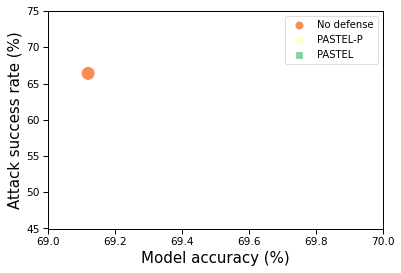

In [15]:
generate_histogram(plot_config, "local_model_attack_accuracy_hist", "Attack success rate (%)", "client_attack", 40, 75, average=True)
generate_histogram(plot_config, "global_model_attack_accuracy_hist", "Attack success rate (%)", "server_attack", 40, 75, average=True)
#generate_xy_plot(plot_config, 'local_models_attack_accuracy', 'Attack success rate (%)', 'client_attack', 0, 100, average=True)
#generate_xy_plot(plot_config, 'global_model_attack_accuracy', 'Attack success rate (%)', 'server_attack', 0, 100, average=True)
#generate_xy_plot(plot_config, 'local_models_accuracy', 'Model accuracy (%)', 'client_accuracy', 0, 100, average=True)
generate_histogram(plot_config, "local_models_accuracy_hist", "Model accuracy (%)", "client_accuracy", 65, 75, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client', 'Model accuracy (%)', 'Attack success rate (%)', 'client_accuracy', 'client_attack', 45, 75, 69, 70, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_server', 'Model accuracy (%)', 'Attack success rate (%)', 'client_accuracy', 'server_attack', 45, 75, 69, 70, average=True)


### Cifar 10 - VGG

In [16]:
plot_config = {
                "dataset_name": "cifar10_vgg",
                "dataset_pretty_name" : "CIFAR10",

                "data":[
                        {
                            "exp_name" : "No defense",
                            "file_path": "resnet_ppm_baseline_cifar.csv",
                            "color": "black",
                            "symbol" : "+"
                        },

                    {
                            "exp_name" : "PASTEL-P",
                            "file_path": "vgg_ppm_bn17_cifar_vgg.csv",
                            "color": "grey",
                            "symbol" : "*"
                        },
                                        
                            {
                            "exp_name" : "PASTEL",
                            "file_path": "ppm_posterior_flattening_relaxloss_uniform_cifar_vgg.csv",
                            "color": "brown",
                            "symbol" : "x"
                        }
                    ]
                }
            


Columns to aggregate
['client_attack_0']
[69.1]
Columns to aggregate
['client_attack_0']
[50]
Columns to aggregate
['client_attack_0']
[50.0]
[0.0, 0.0, 0.0]
Labels
['No defense', 'PASTEL-P', 'PASTEL']
[69.1, 50.0, 50.0]
None


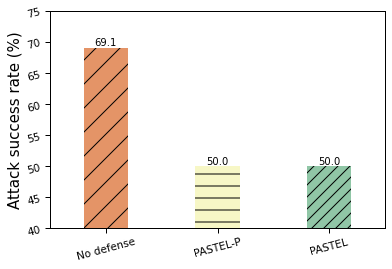

Columns to aggregate
['server_attack']
[66.4]
Columns to aggregate
['server_attack']
[50]
Columns to aggregate
['server_attack']
[50.0]
[0.0, 0.0, 0.0]
Labels
['No defense', 'PASTEL-P', 'PASTEL']
[66.4, 50.0, 50.0]
None


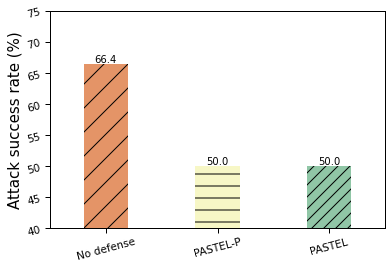

Columns to aggregate
['client_accuracy_0']
[69.12]
Columns to aggregate
['client_accuracy_0']
[75.51890955520773]
Columns to aggregate
['client_accuracy_0']
[75.25548619831251]
[4.388187780849857, 4.874083418251406, 4.913910254773857]
Labels
['No defense', 'PASTEL-P', 'PASTEL']
[69.12, 75.52, 75.26]
None


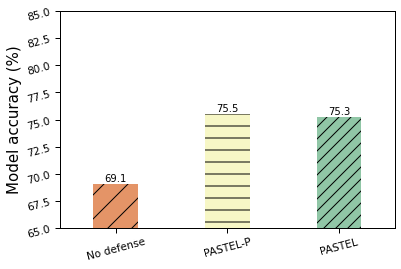

Columns to aggregate
['client_accuracy_0']
[69.12]
Columns to aggregate
['client_attack_0']
[69.1]
Columns to aggregate
['client_accuracy_0']
[75.51890955520773]
Columns to aggregate
['client_attack_0']
[50]
Columns to aggregate
['client_accuracy_0']
[75.25548619831251]
Columns to aggregate
['client_attack_0']
[50.0]


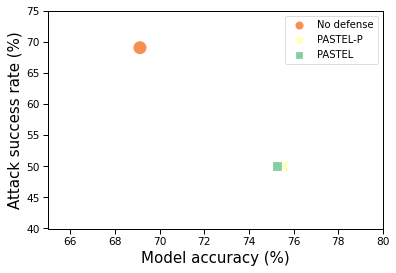

Columns to aggregate
['client_accuracy_0']
[69.12]
Columns to aggregate
['server_attack']
[66.4]
Columns to aggregate
['client_accuracy_0']
[75.51890955520773]
Columns to aggregate
['server_attack']
[50]
Columns to aggregate
['client_accuracy_0']
[75.25548619831251]
Columns to aggregate
['server_attack']
[50.0]


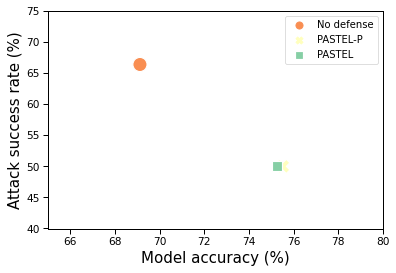

In [17]:
generate_histogram(plot_config, "local_model_attack_accuracy_hist", "Attack success rate (%)", "client_attack", 40, 75, average=True)
generate_histogram(plot_config, "global_model_attack_accuracy_hist", "Attack success rate (%)", "server_attack", 40, 75, average=True)
#generate_xy_plot(plot_config, 'local_models_attack_accuracy', 'Attack success rate (%)', 'client_attack', 0, 100, average=True)
#generate_xy_plot(plot_config, 'global_model_attack_accuracy', 'Attack success rate (%)', 'server_attack', 0, 100, average=True)
#generate_xy_plot(plot_config, 'local_models_accuracy', 'Model accuracy (%)', 'client_accuracy', 0, 100, average=True)
generate_histogram(plot_config, "local_models_accuracy_hist", "Model accuracy (%)", "client_accuracy", 65, 85, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client', 'Model accuracy (%)', 'Attack success rate (%)', 'client_accuracy', 'client_attack', 40, 75, 65, 80, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_server', 'Model accuracy (%)', 'Attack success rate (%)', 'client_accuracy', 'server_attack', 40, 75, 65, 80, average=True)


### CIFAR 100 ResNet

In [18]:
plot_config = {
                "dataset_name": "cifar100_resnet",
                "dataset_pretty_name" : "CIFAR10",

                "data":[
                        {
                            "exp_name" : "No defense",
                            "file_path": "ppm_baseline_cifar100_resnet.csv",
                            "color": "black",
                            "symbol" : "+"
                        },
                    {
                            "exp_name" : "PASTEL-P",
                            "file_path": "ppm_bn1_cifar100_resnet.csv",
                            "color": "grey",
                            "symbol" : "*"
                        },
                                        
                                              
                           
                            {
                            "exp_name" : "PASTEL",
                            "file_path": "ppm_posterior_flattening_relaxloss_uniform_cifar100_resnet.csv",
                            "color": "brown",
                            "symbol" : "x"
                        }
                    ]
                }
            


Columns to aggregate
['client_attack_0']
[63.47]
Columns to aggregate
['client_attack_0']
[50]
Columns to aggregate
['client_attack_0']
[50.0]
[7.105427357601002e-15, 0.0, 0.0]
Labels
['No defense', 'PASTEL-P', 'PASTEL']
[63.47, 50.0, 50.0]
None


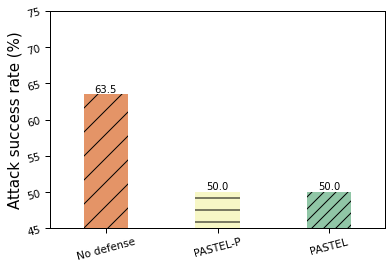

Columns to aggregate
['server_attack']
[60.47]
Columns to aggregate
['server_attack']
[50]
Columns to aggregate
['server_attack']
[50.0]
[7.105427357601002e-15, 0.0, 0.0]
Labels
['No defense', 'PASTEL-P', 'PASTEL']
[60.47, 50.0, 50.0]
None


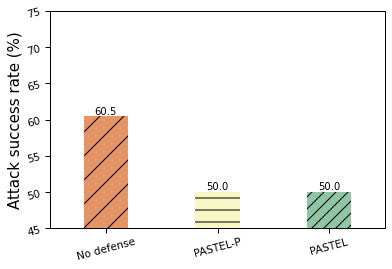

Columns to aggregate
['client_accuracy_0']
[62.51579526443566]
Columns to aggregate
['client_accuracy_0']
[61.7467401411262]
Columns to aggregate
['client_accuracy_0']
[62.34636773703228]
[8.025906877801342, 8.005862964946116, 8.03168263006596]
Labels
['No defense', 'PASTEL-P', 'PASTEL']
[62.52, 61.75, 62.35]
None


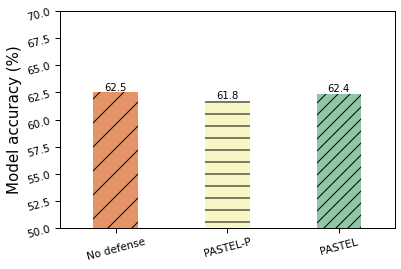

Columns to aggregate
['client_accuracy_0']
[62.51579526443566]
Columns to aggregate
['client_attack_0']
[63.47]
Columns to aggregate
['client_accuracy_0']
[61.7467401411262]
Columns to aggregate
['client_attack_0']
[50]
Columns to aggregate
['client_accuracy_0']
[62.34636773703228]
Columns to aggregate
['client_attack_0']
[50.0]


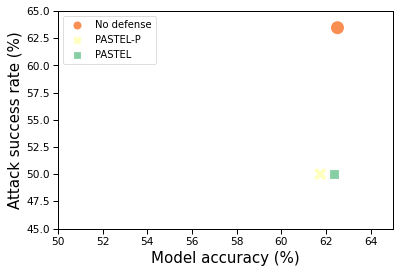

Columns to aggregate
['client_accuracy_0']
[62.51579526443566]
Columns to aggregate
['server_attack']
[60.47]
Columns to aggregate
['client_accuracy_0']
[61.7467401411262]
Columns to aggregate
['server_attack']
[50]
Columns to aggregate
['client_accuracy_0']
[62.34636773703228]
Columns to aggregate
['server_attack']
[50.0]


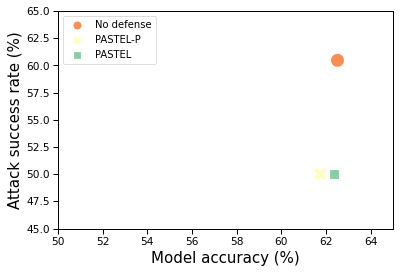

In [19]:
generate_histogram(plot_config, "local_model_attack_accuracy_hist", "Attack success rate (%)", "client_attack", 45, 75, average=True)
generate_histogram(plot_config, "global_model_attack_accuracy_hist", "Attack success rate (%)", "server_attack", 45, 75, average=True)
#generate_xy_plot(plot_config, 'local_models_attack_accuracy', 'Attack success rate (%)', 'client_attack', 0, 100, average=True)
#generate_xy_plot(plot_config, 'global_model_attack_accuracy', 'Attack success rate (%)', 'server_attack', 0, 100, average=True)
#generate_xy_plot(plot_config, 'local_models_accuracy', 'Model accuracy (%)', 'client_accuracy', 0, 100, average=True)
generate_histogram(plot_config, "local_models_accuracy_hist", "Model accuracy (%)", "client_accuracy", 50, 70, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client', 'Model accuracy (%)', 'Attack success rate (%)', 'client_accuracy', 'client_attack', 45, 65, 50, 65, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_server', 'Model accuracy (%)', 'Attack success rate (%)', 'client_accuracy', 'server_attack', 45, 65, 50, 65, average=True)


### CIFAR 100 VGG

In [20]:
plot_config = {
                "dataset_name": "cifar100_vgg",
                "dataset_pretty_name" : "CIFAR10",

                "data":[
                        {
                            "exp_name" : "No defense",
                            "file_path": "vgg_ppm_baseline_cifar100_vgg.csv",
                            "color": "black",
                            "symbol" : "+"
                        },
 
                    {
                            "exp_name" : "PASTEL-P",
                            "file_path": "vgg_ppm_bn17_cifar100_vgg.csv",
                            "color": "grey",
                            "symbol" : "*"
                        },
                                        
                                              
                           
                            {
                            "exp_name" : "PASTEL",
                            "file_path": "ppm_posterior_flattening_relaxloss_uniform_cifar100_vgg.csv",
                            "color": "brown",
                            "symbol" : "x"
                        }
                    ]
                }
            


Columns to aggregate
['client_attack_0']
[71.35]
Columns to aggregate
['client_attack_0']
[51.91]
Columns to aggregate
['client_attack_0']
[50.0]
[0.0, 7.105427357601002e-15, 0.0]
Labels
['No defense', 'PASTEL-P', 'PASTEL']
[71.35, 51.91, 50.0]
None


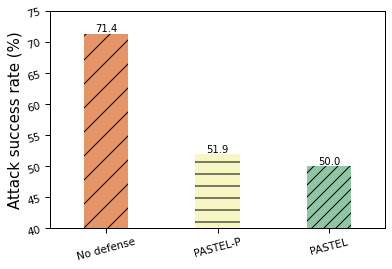

Columns to aggregate
['server_attack']
[69.97]
Columns to aggregate
['server_attack']
[50.8]
Columns to aggregate
['server_attack']
[50.0]
[0.0, 0.0, 0.0]
Labels
['No defense', 'PASTEL-P', 'PASTEL']
[69.97, 50.8, 50.0]
None


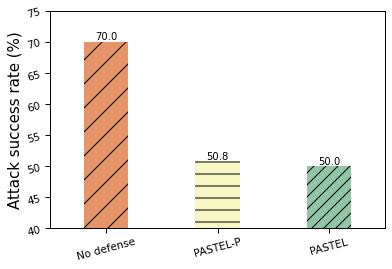

Columns to aggregate
['client_accuracy_0']
[71.70857142857143]
Columns to aggregate
['client_accuracy_0']
[71.63675066341916]
Columns to aggregate
['client_accuracy_0']
[71.3640530026798]
[8.521348229485664, 8.51402700768518, 8.517781447740358]
Labels
['No defense', 'PASTEL-P', 'PASTEL']
[71.71, 71.64, 71.36]
None


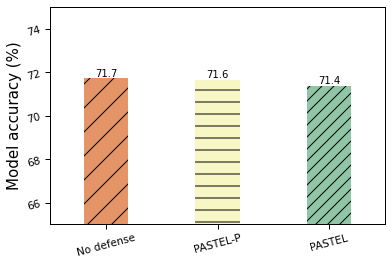

Columns to aggregate
['client_accuracy_0']
[71.70857142857143]
Columns to aggregate
['client_attack_0']
[71.35]
Columns to aggregate
['client_accuracy_0']
[71.63675066341916]
Columns to aggregate
['client_attack_0']
[51.91]
Columns to aggregate
['client_accuracy_0']
[71.3640530026798]
Columns to aggregate
['client_attack_0']
[50.0]


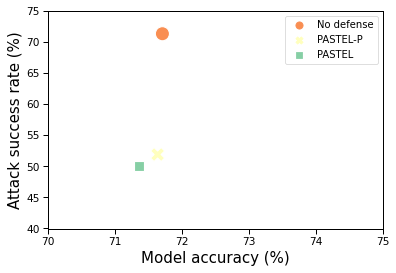

Columns to aggregate
['client_accuracy_0']
[71.70857142857143]
Columns to aggregate
['server_attack']
[69.97]
Columns to aggregate
['client_accuracy_0']
[71.63675066341916]
Columns to aggregate
['server_attack']
[50.8]
Columns to aggregate
['client_accuracy_0']
[71.3640530026798]
Columns to aggregate
['server_attack']
[50.0]


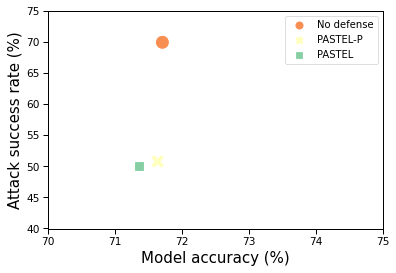

In [21]:
generate_histogram(plot_config, "local_model_attack_accuracy_hist", "Attack success rate (%)", "client_attack", 40, 75, average=True)
generate_histogram(plot_config, "global_model_attack_accuracy_hist", "Attack success rate (%)", "server_attack", 40, 75, average=True)
#generate_xy_plot(plot_config, 'local_models_attack_accuracy', 'Attack success rate (%)', 'client_attack', 0, 100, average=True)
#generate_xy_plot(plot_config, 'global_model_attack_accuracy', 'Attack success rate (%)', 'server_attack', 0, 100, average=True)
#generate_xy_plot(plot_config, 'local_models_accuracy', 'Model accuracy (%)', 'client_accuracy', 0, 100, average=True)
generate_histogram(plot_config, "local_models_accuracy_hist", "Model accuracy (%)", "client_accuracy", 65, 75, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client', 'Model accuracy (%)', 'Attack success rate (%)', 'client_accuracy', 'client_attack', 40, 75, 70, 75, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_server', 'Model accuracy (%)', 'Attack success rate (%)', 'client_accuracy', 'server_attack', 40, 75, 70, 75, average=True)


### Speech Commands

In [22]:
plot_config = {
                "dataset_name": "speechcommands",
                "dataset_pretty_name" : "Speech Commands",

                "data":[
                        {
                            "exp_name" : "No defense",
                            "file_path": "ppm_baseline_speechcommands.csv",
                            "color": "black",
                            "symbol" : "+"
                        }, 
                                           {
                            "exp_name" : "WDP",
                            "file_path": "distant_results/ppm_wdp_2_speechcommands.csv",
                            "color": "black",
                            "symbol" : "+"
                        },
                                                               {
                            "exp_name" : "LDP",
                            "file_path": "distant_results/ppm_ldp_2_speechcommands.csv",
                            "color": "black",
                            "symbol" : "+"
                        },
                                                                                   {
                            "exp_name" : "CDP",
                            "file_path": "distant_results/ppm_cdp_1_5_speechcommands.csv",
                            "color": "black",
                            "symbol" : "+"
                        }, 
                           
                            {
                            "exp_name" : "PASTEL",
                            "file_path": "ppm_pastel_last_speech_commands.csv",
                            "color": "brown",
                            "symbol" : "x"
                        }
                    ]
                }
            


Columns to aggregate
['client_attack_3', 'client_attack_1', 'client_attack_2', 'client_attack_0', 'client_attack_4']
[58.94117647058823, 57.41176470588235, 58.235294117647065, 58.94117647058823, 57.88235294117647]
Columns to aggregate
['client_attack_3', 'client_attack_1', 'client_attack_2', 'client_attack_0', 'client_attack_4']
[56.00000000000001, 55.88235294117647, 56.00000000000001, 56.94117647058824, 54.70588235294118]
Columns to aggregate
['client_attack_3', 'client_attack_1', 'client_attack_2', 'client_attack_0', 'client_attack_4']
[50.117647058823536, 50.117647058823536, 50.0, 50.0, 50.23529411764706]
Columns to aggregate
['client_attack_3', 'client_attack_1', 'client_attack_2', 'client_attack_0', 'client_attack_4']
[54.8235294117647, 55.76470588235294, 54.0, 55.76470588235294, 53.41176470588235]
Columns to aggregate
['client_attack_3', 'client_attack_1', 'client_attack_2', 'client_attack_0', 'client_attack_4']
[50.0, 50.0, 50.0, 50.0, 50.0]
[0.5980360012771214, 0.71135136272145

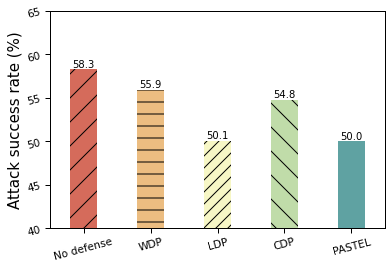

Columns to aggregate
['server_attack']
[55.86827899959928]
Columns to aggregate
['server_attack']
[54.128656624944014]
Columns to aggregate
['server_attack']
[50.04596563185064]
Columns to aggregate
['server_attack']
[50.00353581783467]
Columns to aggregate
['server_attack']
[50.00353581783467]
[0.3679334847469071, 0.22732617092383617, 0.024112791367972515, 7.105427357601002e-15, 7.105427357601002e-15]
Labels
['No defense', 'WDP', 'LDP', 'CDP', 'PASTEL']
[55.87, 54.13, 50.05, 50.0, 50.0]
None


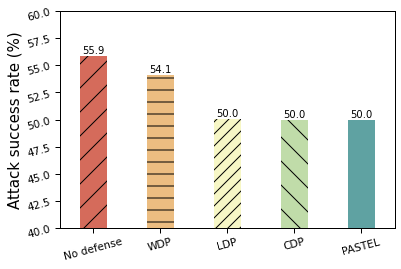

Columns to aggregate
['client_accuracy_3', 'client_accuracy_1', 'client_accuracy_2', 'client_accuracy_0', 'client_accuracy_4']
[85.99915146372507, 86.34799415452788, 86.24899825578655, 86.58841276575686, 86.71097911657945]
Columns to aggregate
['client_accuracy_3', 'client_accuracy_1', 'client_accuracy_2', 'client_accuracy_0', 'client_accuracy_4']
[85.66916513458727, 86.80997501532079, 86.62612548908687, 86.53655777117805, 86.1924291707915]
Columns to aggregate
['client_accuracy_3', 'client_accuracy_1', 'client_accuracy_2', 'client_accuracy_0', 'client_accuracy_4']
[62.68797435534813, 62.079856691651344, 61.83943808042238, 62.67854617451562, 62.19299486164145]
Columns to aggregate
['client_accuracy_3', 'client_accuracy_1', 'client_accuracy_2', 'client_accuracy_0', 'client_accuracy_4']
[80.74294064960166, 80.62037429877905, 78.44717861688586, 81.28977513788715, 79.69169848677697]
Columns to aggregate
['client_accuracy_3', 'client_accuracy_1', 'client_accuracy_2', 'client_accuracy_0', 'c

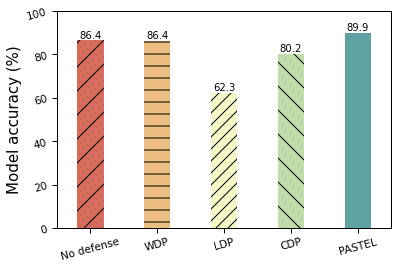

Columns to aggregate
['client_accuracy_3', 'client_accuracy_1', 'client_accuracy_2', 'client_accuracy_0', 'client_accuracy_4']
[85.99915146372507, 86.34799415452788, 86.24899825578655, 86.58841276575686, 86.71097911657945]
Columns to aggregate
['client_attack_3', 'client_attack_1', 'client_attack_2', 'client_attack_0', 'client_attack_4']
[58.94117647058823, 57.41176470588235, 58.235294117647065, 58.94117647058823, 57.88235294117647]
Columns to aggregate
['client_accuracy_3', 'client_accuracy_1', 'client_accuracy_2', 'client_accuracy_0', 'client_accuracy_4']
[85.66916513458727, 86.80997501532079, 86.62612548908687, 86.53655777117805, 86.1924291707915]
Columns to aggregate
['client_attack_3', 'client_attack_1', 'client_attack_2', 'client_attack_0', 'client_attack_4']
[56.00000000000001, 55.88235294117647, 56.00000000000001, 56.94117647058824, 54.70588235294118]
Columns to aggregate
['client_accuracy_3', 'client_accuracy_1', 'client_accuracy_2', 'client_accuracy_0', 'client_accuracy_4']
[

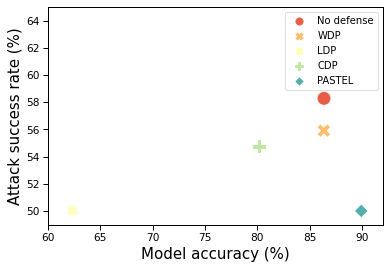

Columns to aggregate
['client_accuracy_3', 'client_accuracy_1', 'client_accuracy_2', 'client_accuracy_0', 'client_accuracy_4']
[85.99915146372507, 86.34799415452788, 86.24899825578655, 86.58841276575686, 86.71097911657945]
Columns to aggregate
['server_attack']
[55.86827899959928]
Columns to aggregate
['client_accuracy_3', 'client_accuracy_1', 'client_accuracy_2', 'client_accuracy_0', 'client_accuracy_4']
[85.66916513458727, 86.80997501532079, 86.62612548908687, 86.53655777117805, 86.1924291707915]
Columns to aggregate
['server_attack']
[54.128656624944014]
Columns to aggregate
['client_accuracy_3', 'client_accuracy_1', 'client_accuracy_2', 'client_accuracy_0', 'client_accuracy_4']
[62.68797435534813, 62.079856691651344, 61.83943808042238, 62.67854617451562, 62.19299486164145]
Columns to aggregate
['server_attack']
[50.04596563185064]
Columns to aggregate
['client_accuracy_3', 'client_accuracy_1', 'client_accuracy_2', 'client_accuracy_0', 'client_accuracy_4']
[80.74294064960166, 80.620

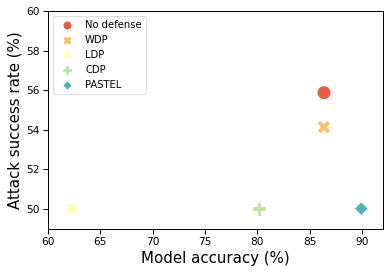

In [23]:
generate_histogram(plot_config, "local_model_attack_accuracy_hist", "Attack success rate (%)", "client_attack", 40, 65, average=True)
generate_histogram(plot_config, "global_model_attack_accuracy_hist", "Attack success rate (%)", "server_attack", 40, 60, average=True)
#generate_xy_plot(plot_config, 'local_models_attack_accuracy', 'Attack success rate (%)', 'client_attack', 0, 100, average=True)
#generate_xy_plot(plot_config, 'global_model_attack_accuracy', 'Attack success rate (%)', 'server_attack', 0, 100, average=True)
#generate_xy_plot(plot_config, 'local_models_accuracy', 'Model accuracy (%)', 'client_accuracy', 0, 100, average=True)
generate_histogram(plot_config, "local_models_accuracy_hist", "Model accuracy (%)", "client_accuracy", 0, 100, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client', 'Model accuracy (%)', 'Attack success rate (%)', 'client_accuracy', 'client_attack', 49, 65, 60, 92, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_server', 'Model accuracy (%)', 'Attack success rate (%)', 'client_accuracy', 'server_attack', 49, 60, 60, 92, average=True)


### Purchase 100

In [183]:
plot_config = {
                "dataset_name": "Purchase 100",
                "dataset_pretty_name" : "Purchase 100",

                "data":[

                        {
                            "exp_name" : "No defense",
                            "file_path": "ppm_baseline_300_purchase.csv",
                            "color": "black",
                            "symbol" : "+"
                        },
                                                               {
                            "exp_name" : "WDP",
                            "file_path": "ppm_gnl_purchase.csv",
                            "color": "black",
                            "symbol" : "+"
                        },
                                                                                   {
                            "exp_name" : "LDP",
                            "file_path": "distant_results/ppm_ldp_2_purchase.csv",
                            "color": "black",
                            "symbol" : "+"
                        },
                                                                                                       {
                            "exp_name" : "CDP",
                            "file_path": "distant_results/ppm_cdp_1_5_purchase.csv",
                            "color": "black",
                            "symbol" : "+"
                        },
                    
                    
                    
                           
                            {
                            "exp_name" : "PASTEL",
                            "file_path": "ppm_pastel_features6_adagrad_purchase.csv",
                            "color": "brown",
                            "symbol" : "x"
                        }
                    
                    
                    ]
                }

Columns to aggregate
['client_attack_1', 'client_attack_6', 'client_attack_4', 'client_attack_9', 'client_attack_3', 'client_attack_8', 'client_attack_5', 'client_attack_7', 'client_attack_2', 'client_attack_0']
[76.0, 81.0, 77.0, 80.0, 77.0, 80.0, 79.0, 80.0, 75.0, 76.0]
Columns to aggregate
['client_attack_3', 'client_attack_1', 'client_attack_2', 'client_attack_4', 'client_attack_0']
[78.28282828282829, 74.24242424242425, 74.74747474747475, 75.25252525252525, 73.73737373737373]
Columns to aggregate
['client_attack_1', 'client_attack_6', 'client_attack_4', 'client_attack_9', 'client_attack_3', 'client_attack_8', 'client_attack_5', 'client_attack_7', 'client_attack_2', 'client_attack_0']
[50.0, 51.0, 52.0, 50.0, 54.0, 51.0, 51.0, 52.0, 51.0, 52.0]
Columns to aggregate
['client_attack_1', 'client_attack_6', 'client_attack_4', 'client_attack_9', 'client_attack_3', 'client_attack_8', 'client_attack_5', 'client_attack_7', 'client_attack_2', 'client_attack_0']
[89.0, 93.0, 87.0, 90.0, 88.0

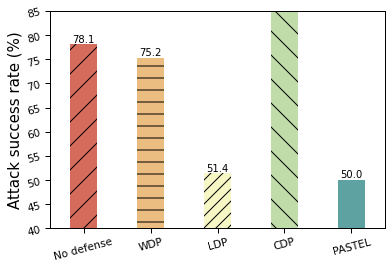

Columns to aggregate
['server_attack']
[52.09811473748226]
Columns to aggregate
['server_attack']
[57.74376647070748]
Columns to aggregate
['server_attack']
[50.354753699574296]
Columns to aggregate
['server_attack']
[77.28562740725725]
Columns to aggregate
['server_attack']
[50.01013581998783]
[0.5554168530182385, 0.31377507701734747, 0.11117192662429307, 0.3491380851312524, 0.009223719946587274]
Labels
['No defense', 'WDP', 'LDP', 'CDP', 'PASTEL']
[52.1, 57.74, 50.35, 77.29, 50.01]
None


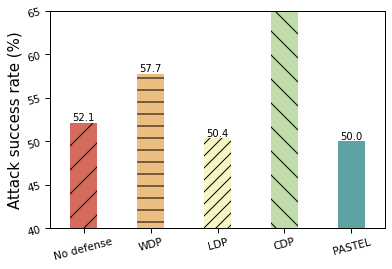

Columns to aggregate
['client_accuracy_1', 'client_accuracy_6', 'client_accuracy_4', 'client_accuracy_9', 'client_accuracy_3', 'client_accuracy_8', 'client_accuracy_5', 'client_accuracy_7', 'client_accuracy_2', 'client_accuracy_0']
[60.65274680721671, 60.87573484694912, 61.301439286438274, 60.2675856476789, 60.63247516724103, 60.389215487532944, 61.443340766268, 60.22704236772755, 60.61220352726535, 59.98378268801946]
Columns to aggregate
['client_accuracy_3', 'client_accuracy_1', 'client_accuracy_2', 'client_accuracy_4', 'client_accuracy_0']
[61.62578552604906, 59.8013379282384, 61.301439286438274, 59.90269612811676, 60.004054327995135]
Columns to aggregate
['client_accuracy_1', 'client_accuracy_6', 'client_accuracy_4', 'client_accuracy_9', 'client_accuracy_3', 'client_accuracy_8', 'client_accuracy_5', 'client_accuracy_7', 'client_accuracy_2', 'client_accuracy_0']
[46.72613014392864, 46.6855868639773, 46.96938982363673, 47.11129130346645, 46.98966146361241, 46.66531522400162, 46.72613

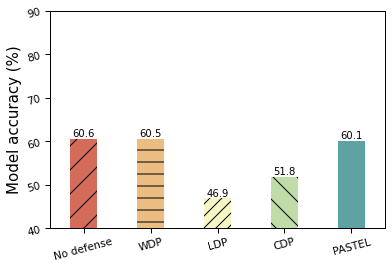

Columns to aggregate
['client_accuracy_1', 'client_accuracy_6', 'client_accuracy_4', 'client_accuracy_9', 'client_accuracy_3', 'client_accuracy_8', 'client_accuracy_5', 'client_accuracy_7', 'client_accuracy_2', 'client_accuracy_0']
[60.65274680721671, 60.87573484694912, 61.301439286438274, 60.2675856476789, 60.63247516724103, 60.389215487532944, 61.443340766268, 60.22704236772755, 60.61220352726535, 59.98378268801946]
Columns to aggregate
['client_attack_1', 'client_attack_6', 'client_attack_4', 'client_attack_9', 'client_attack_3', 'client_attack_8', 'client_attack_5', 'client_attack_7', 'client_attack_2', 'client_attack_0']
[76.0, 81.0, 77.0, 80.0, 77.0, 80.0, 79.0, 80.0, 75.0, 76.0]
Columns to aggregate
['client_accuracy_3', 'client_accuracy_1', 'client_accuracy_2', 'client_accuracy_4', 'client_accuracy_0']
[61.62578552604906, 59.8013379282384, 61.301439286438274, 59.90269612811676, 60.004054327995135]
Columns to aggregate
['client_attack_3', 'client_attack_1', 'client_attack_2', 'c

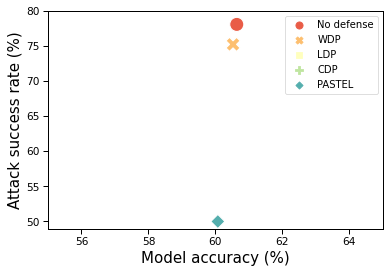

Columns to aggregate
['client_accuracy_1', 'client_accuracy_6', 'client_accuracy_4', 'client_accuracy_9', 'client_accuracy_3', 'client_accuracy_8', 'client_accuracy_5', 'client_accuracy_7', 'client_accuracy_2', 'client_accuracy_0']
[60.65274680721671, 60.87573484694912, 61.301439286438274, 60.2675856476789, 60.63247516724103, 60.389215487532944, 61.443340766268, 60.22704236772755, 60.61220352726535, 59.98378268801946]
Columns to aggregate
['server_attack']
[52.09811473748226]
Columns to aggregate
['client_accuracy_3', 'client_accuracy_1', 'client_accuracy_2', 'client_accuracy_4', 'client_accuracy_0']
[61.62578552604906, 59.8013379282384, 61.301439286438274, 59.90269612811676, 60.004054327995135]
Columns to aggregate
['server_attack']
[57.74376647070748]
Columns to aggregate
['client_accuracy_1', 'client_accuracy_6', 'client_accuracy_4', 'client_accuracy_9', 'client_accuracy_3', 'client_accuracy_8', 'client_accuracy_5', 'client_accuracy_7', 'client_accuracy_2', 'client_accuracy_0']
[46.

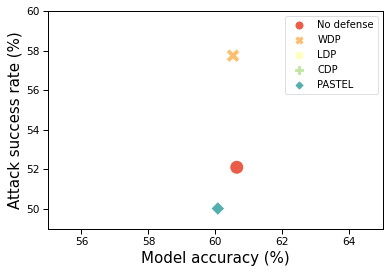

In [184]:
generate_histogram(plot_config, "local_model_attack_accuracy_hist", "Attack success rate (%)", "client_attack", 40, 85, average=True)
generate_histogram(plot_config, "global_model_attack_accuracy_hist", "Attack success rate (%)", "server_attack", 40, 65, average=True)
#generate_xy_plot(plot_config, 'local_models_attack_accuracy', 'Attack success rate (%)', 'client_attack', 0, 100, average=True)
#generate_xy_plot(plot_config, 'global_model_attack_accuracy', 'Attack success rate (%)', 'server_attack', 0, 100, average=True)
#generate_xy_plot(plot_config, 'local_models_accuracy', 'Model accuracy (%)', 'client_accuracy', 40, 70, average=True)
generate_histogram(plot_config, "local_models_accuracy_hist", "Model accuracy (%)", "client_accuracy", 40, 90, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client', 'Model accuracy (%)', 'Attack success rate (%)', 'client_accuracy', 'client_attack', 49, 80, 55, 65, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_server', 'Model accuracy (%)', 'Attack success rate (%)', 'client_accuracy', 'server_attack', 49, 60, 55, 65, average=True)


### Texas 100

In [26]:
plot_config = {
                "dataset_name": "Texas100",
                "dataset_pretty_name" : "Texas100",

                "data":[

                        {
                            "exp_name" : "No defense",
                            "file_path": "ppm_baseline_texas.csv",
                            "color": "black",
                            "symbol" : "+"
                        },
                                               
                            {
                            "exp_name" : "PASTEL",
                            "file_path": "ppm_posterior_flattening_relaxloss_uniform_texas.csv",
                            "color": "brown",
                            "symbol" : "x"
                        }
                    ]
                }

In [ ]:
generate_histogram(plot_config, "local_model_attack_accuracy_hist", "Attack success rate (%)", "client_attack", 40, 100, average=True)
generate_histogram(plot_config, "global_model_attack_accuracy_hist", "Attack success rate (%)", "server_attack", 40, 55, average=True)
#generate_xy_plot(plot_config, 'local_models_attack_accuracy', 'Attack success rate (%)', 'client_attack', 0, 80, average=True)
#generate_xy_plot(plot_config, 'global_model_attack_accuracy', 'Attack success rate (%)', 'server_attack', 0, 60, average=True)
#generate_xy_plot(plot_config, 'local_models_accuracy', 'Model accuracy (%)', 'client_accuracy', 35, 50, average=True)
generate_histogram(plot_config, "local_models_accuracy_hist", "Model accuracy (%)", "client_accuracy", 40, 55, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff', 'Model accuracy (%)', 'Attack success rate (%)', 'client_accuracy', 'client_attack', 48, 90, 45, 50, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_server', 'Model accuracy (%)', 'Attack success rate (%)', 'client_accuracy', 'server_attack',49.5, 55, 45, 50, average=True)


### Celeba VGG

In [ ]:
plot_config = {
                "dataset_name": "celeba_vgg",
                "dataset_pretty_name" : "CelebA",

                "data":[

                        {
                            "exp_name" : "No defense",
                            "file_path": "ppm_baseline_celeba_vgg.csv",
                            "color": "black",
                            "symbol" : "+"
                        },
                                               
                            {
                            "exp_name" : "PASTEL",
                            "file_path": "ppm_pastel_bn8_adagrad_celeba_vgg.csv",
                            "color": "brown",
                            "symbol" : "x"
                        }


                    ]
                }

In [ ]:
generate_histogram(plot_config, "local_model_attack_accuracy_hist", "Attack AUC (%)", "client_auc", 45, 60, average=True)
generate_histogram(plot_config, "global_model_attack_accuracy_hist", "Attack AUC (%)", "server_attack", 45, 70, average=True)
#generate_xy_plot(plot_config, 'local_models_attack_accuracy', 'Attack AUC (%)', 'client_auc', 0, 100, average=True)
#generate_xy_plot(plot_config, 'global_model_attack_accuracy', 'Attack AUC (%)', 'server_attack', 0, 100, average=True)
#generate_xy_plot(plot_config, 'local_models_accuracy', 'Model accuracy (%)', 'client_accuracy', 0, 102, average=True)
generate_histogram(plot_config, "local_models_accuracy_hist", "Model accuracy (%)", "client_accuracy", 60, 80, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy', 'client_auc', 48, 60, 70, 75, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_server', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy', 'server_attack', 48, 70, 70, 75, average=True)

generate_histogram(plot_config, "local_model_0_attack_accuracy_hist", "Attack AUC (%)", "client_auc_0", 45, 60, average=True, extension = "png")
generate_histogram(plot_config, "local_model_1_attack_accuracy_hist", "Attack AUC (%)", "client_auc_1", 45, 60, average=True, extension = "png")
generate_histogram(plot_config, "local_model_2_attack_accuracy_hist", "Attack AUC (%)", "client_auc_2", 45, 60, average=True, extension = "png")
generate_histogram(plot_config, "local_model_3_attack_accuracy_hist", "Attack AUC (%)", "client_auc_3", 45, 60, average=True, extension = "png")
generate_histogram(plot_config, "local_model_4_attack_accuracy_hist", "Attack AUC (%)", "client_auc_4", 45, 60, average=True, extension = "png")


generate_histogram(plot_config, "local_model_0_accuracy_hist", "Model accuracy (%)", "client_accuracy_0", 60, 80, average=True, extension = "png")
generate_histogram(plot_config, "local_model_1_accuracy_hist", "Model accuracy (%)", "client_accuracy_1", 60, 80, average=True, extension = "png")
generate_histogram(plot_config, "local_model_2_accuracy_hist", "Model accuracy (%)", "client_accuracy_2", 60, 80, average=True, extension = "png")
generate_histogram(plot_config, "local_model_3_accuracy_hist", "Model accuracy (%)", "client_accuracy_3", 60, 80, average=True, extension = "png")
generate_histogram(plot_config, "local_model_4_accuracy_hist", "Model accuracy (%)", "client_accuracy_4", 60, 80, average=True, extension = "png")

generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client1', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy_0', 'client_auc_0', 45, 60, 60, 80, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client2', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy_1', 'client_auc_1', 45, 60, 60, 80, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client3', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy_2', 'client_auc_2', 45, 60, 60, 80, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client4', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy_3', 'client_auc_3', 45, 60, 60, 80, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client5', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy_4', 'client_auc_4', 45, 60, 60, 80, average=True)



In [ ]:
plot_xy(plot_config, 'client_accuracy_0', 'Model accuracy (%)', 'client_accuracy_0', 0, 80, average=True)
plot_xy(plot_config, 'client_accuracy_1', 'Model accuracy (%)', 'client_accuracy_1', 0, 80, average=True)
plot_xy(plot_config, 'client_accuracy_2', 'Model accuracy (%)', 'client_accuracy_2', 0, 80, average=True)
plot_xy(plot_config, 'client_accuracy_3', 'Model accuracy (%)', 'client_accuracy_3', 0, 80, average=True)
plot_xy(plot_config, 'client_accuracy_4', 'Model accuracy (%)', 'client_accuracy_4', 0, 80, average=True)

### CelebA ResNet20

In [ ]:
plot_config = {
                "dataset_name": "celeba_resnet",
                "dataset_pretty_name" : "CelebA_ResNet",

                "data":[

                        {
                            "exp_name" : "No defense",
                            "file_path": "ppm_baseline_celeba_resnet.csv",
                            "color": "orange",
                            "symbol" : "+"
                        },
                                               
                            {
                            "exp_name" : "PASTEL",
                            "file_path": "ppm_pastel_firstbatch_last_celeba_resnet.csv",
                            "color": "blue",
                            "symbol" : "x"
                        }
                            
                    ]
                }

In [ ]:
generate_histogram(plot_config, "local_model_attack_accuracy_hist", "Attack AUC (%)", "client_auc", 40, 60, average=True)
generate_histogram(plot_config, "global_model_attack_accuracy_hist", "Attack AUC (%)", "server_attack", 40, 60, average=True)
#generate_xy_plot(plot_config, 'local_models_attack_accuracy', 'Attack AUC (%)', 'client_auc', 0, 100, average=True)
#generate_xy_plot(plot_config, 'global_model_attack_accuracy', 'Attack AUC (%)', 'server_attack', 0, 100, average=True)
#generate_xy_plot(plot_config, 'local_models_accuracy', 'Model accuracy (%)', 'client_accuracy', 0, 100, average=True)
generate_histogram(plot_config, "local_models_accuracy_hist", "Model accuracy (%)", "client_accuracy", 60, 70, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy', 'client_auc', 48, 60, 60, 70, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_server', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy', 'server_attack', 49, 52, 60, 70, average=True)

generate_histogram(plot_config, "local_model_0_attack_accuracy_hist", "Attack AUC (%)", "client_auc_0", 40, 60, average=True, extension = "png")
generate_histogram(plot_config, "local_model_1_attack_accuracy_hist", "Attack AUC (%)", "client_auc_1", 40, 60, average=True, extension = "png")
generate_histogram(plot_config, "local_model_2_attack_accuracy_hist", "Attack AUC (%)", "client_auc_2", 40, 60, average=True, extension = "png")
generate_histogram(plot_config, "local_model_3_attack_accuracy_hist", "Attack AUC (%)", "client_auc_3", 40, 60, average=True, extension = "png")
generate_histogram(plot_config, "local_model_4_attack_accuracy_hist", "Attack AUC (%)", "client_auc_4", 40, 60, average=True, extension = "png")


generate_histogram(plot_config, "local_model_0_accuracy_hist", "Model accuracy (%)", "client_accuracy_0", 60, 80, average=True, extension = "png")
generate_histogram(plot_config, "local_model_1_accuracy_hist", "Model accuracy (%)", "client_accuracy_1", 60, 80, average=True, extension = "png")
generate_histogram(plot_config, "local_model_2_accuracy_hist", "Model accuracy (%)", "client_accuracy_2", 60, 80, average=True, extension = "png")
generate_histogram(plot_config, "local_model_3_accuracy_hist", "Model accuracy (%)", "client_accuracy_3", 60, 80, average=True, extension = "png")
generate_histogram(plot_config, "local_model_4_accuracy_hist", "Model accuracy (%)", "client_accuracy_4", 60, 80, average=True, extension = "png")

generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client1', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy_0', 'client_auc_0', 48, 60, 60, 75, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client2', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy_1', 'client_auc_1', 48, 60, 60, 75, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client3', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy_2', 'client_auc_2', 48, 60, 60, 75, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client4', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy_3', 'client_auc_3', 48, 60, 60, 75, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client5', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy_4', 'client_auc_4', 48, 60, 60, 75, average=True)


In [ ]:
plot_xy(plot_config, 'client_accuracy_0', 'Model accuracy (%)', 'client_accuracy_0', 0, 80, average=True)
plot_xy(plot_config, 'client_accuracy_1', 'Model accuracy (%)', 'client_accuracy_1', 0, 80, average=True)
plot_xy(plot_config, 'client_accuracy_2', 'Model accuracy (%)', 'client_accuracy_2', 0, 80, average=True)
plot_xy(plot_config, 'client_accuracy_3', 'Model accuracy (%)', 'client_accuracy_3', 0, 80, average=True)
plot_xy(plot_config, 'client_accuracy_4', 'Model accuracy (%)', 'client_accuracy_4', 0, 80, average=True)

### GTSRB - ResNet

In [ ]:
plot_config = {
                "dataset_name": "GTSRB_resnet",
                "dataset_pretty_name" : "GTSRB_ResNet",

                "data":[

                        {
                            "exp_name" : "No defense",
                            "file_path": "ppm_baseline_gtsrb_resnet.csv",
                            "color": "black",
                            "symbol" : "+"
                        },
                                                                {
                            "exp_name" : "LDP (Eps = 0.3)",
                            "file_path": "ppm_ldp_03_gtsrb_vgg.csv",
                            "color": "black",
                            "symbol" : "+"
                        },
                                                                {
                            "exp_name" : "LDP (Eps = 0.5)",
                            "file_path": "ppm_ldp_05_gtsrb_resnet.csv",
                            "color": "black",
                            "symbol" : "+"
                        },
                                            {
                            "exp_name" : "LDP (Eps = 0.7)",
                            "file_path": "ppm_ldp_07_gtsrb_resnet.csv",
                            "color": "black",
                            "symbol" : "+"
                        },
                    
                    
                    
                           
                            {
                            "exp_name" : "PASTEL",
                            "file_path": "ppm_pastel_firstbatch_last_gtsrb_resnet.csv",
                            "color": "brown",
                            "symbol" : "x"
                        }
                    ]
                }

In [ ]:
generate_histogram(plot_config, "local_model_attack_accuracy_hist", "Attack AUC (%)", "client_auc", 45, 60, average=True)
generate_histogram(plot_config, "global_model_attack_accuracy_hist", "Attack AUC (%)", "server_attack", 45, 60, average=True)
generate_histogram(plot_config, "local_models_accuracy_hist", "Model accuracy (%)", "client_accuracy", 70, 103, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy', 'client_auc', 48, 60, 95, 101.5, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_server', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy', 'server_attack', 48, 55, 95, 101.5, average=True)

generate_histogram(plot_config, "local_model_0_attack_accuracy_hist", "Attack AUC (%)", "client_auc_0", 45, 60, average=True, extension = "png")
generate_histogram(plot_config, "local_model_1_attack_accuracy_hist", "Attack AUC (%)", "client_auc_1", 45, 60, average=True, extension = "png")
generate_histogram(plot_config, "local_model_2_attack_accuracy_hist", "Attack AUC (%)", "client_auc_2", 45, 60, average=True, extension = "png")
generate_histogram(plot_config, "local_model_3_attack_accuracy_hist", "Attack AUC (%)", "client_auc_3", 45, 60, average=True, extension = "png")
generate_histogram(plot_config, "local_model_4_attack_accuracy_hist", "Attack AUC (%)", "client_auc_4", 45, 60, average=True, extension = "png")


generate_histogram(plot_config, "local_model_0_accuracy_hist", "Model accuracy (%)", "client_accuracy_0", 90, 101.5, average=True, extension = "png")
generate_histogram(plot_config, "local_model_1_accuracy_hist", "Model accuracy (%)", "client_accuracy_1", 90, 101.5, average=True, extension = "png")
generate_histogram(plot_config, "local_model_2_accuracy_hist", "Model accuracy (%)", "client_accuracy_2", 90, 101.5, average=True, extension = "png")
generate_histogram(plot_config, "local_model_3_accuracy_hist", "Model accuracy (%)", "client_accuracy_3", 90, 101.5, average=True, extension = "png")
generate_histogram(plot_config, "local_model_4_accuracy_hist", "Model accuracy (%)", "client_accuracy_4", 90, 101.5, average=True, extension = "png")

generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client1', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy_0', 'client_auc_0', 48, 60, 90, 101.5, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client2', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy_1', 'client_auc_1', 48, 60, 90, 101.5, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client3', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy_2', 'client_auc_2', 48, 60, 90, 101.5, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client4', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy_3', 'client_auc_3', 48, 60, 90, 101.5, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client5', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy_4', 'client_auc_4', 48, 60, 90, 101.5, average=True)


### GTSRB - VGG

In [ ]:
plot_config = {
                "dataset_name": "GTSRB_vgg",
                "dataset_pretty_name" : "GTSRB_VGG",

                "data":[

                        {
                            "exp_name" : "No defense",
                            "file_path": "ppm_baseline_gtsrb_vgg.csv",
                            "color": "black",
                            "symbol" : "+"
                        },

                           
                            {
                            "exp_name" : "PASTEL",
                            "file_path": "ppm_pastel_last_gtsrb_vgg.csv",
                            "color": "brown",
                            "symbol" : "x"
                        }
                    
                    ]
                }

In [ ]:
generate_histogram(plot_config, "local_model_attack_accuracy_hist", "Attack AUC (%)", "client_attack", 40, 60, average=True)
generate_histogram(plot_config, "global_model_attack_accuracy_hist", "Attack AUC (%)", "server_attack", 40, 55, average=True)

generate_histogram(plot_config, "local_models_accuracy_hist", "Model accuracy (%)", "client_accuracy", 90, 101.5, average=True)

generate_histogram(plot_config, "local_model_0_attack_accuracy_hist", "Attack AUC (%)", "client_attack_0", 40, 60, average=True, extension = "png")
generate_histogram(plot_config, "local_model_1_attack_accuracy_hist", "Attack AUC (%)", "client_attack_1", 40, 60, average=True, extension = "png")
generate_histogram(plot_config, "local_model_2_attack_accuracy_hist", "Attack AUC (%)", "client_attack_2", 40, 60, average=True, extension = "png")
generate_histogram(plot_config, "local_model_3_attack_accuracy_hist", "Attack AUC (%)", "client_attack_3", 40, 60, average=True, extension = "png")
generate_histogram(plot_config, "local_model_4_attack_accuracy_hist", "Attack AUC (%)", "client_attack_4", 40, 60, average=True, extension = "png")


generate_histogram(plot_config, "local_model_0_accuracy_hist", "Model accuracy (%)", "client_accuracy_0", 90, 101.5, average=True, extension = "png")
generate_histogram(plot_config, "local_model_1_accuracy_hist", "Model accuracy (%)", "client_accuracy_1", 90, 101.5, average=True, extension = "png")
generate_histogram(plot_config, "local_model_2_accuracy_hist", "Model accuracy (%)", "client_accuracy_2", 90, 101.5, average=True, extension = "png")
generate_histogram(plot_config, "local_model_3_accuracy_hist", "Model accuracy (%)", "client_accuracy_3", 90, 101.5, average=True, extension = "png")
generate_histogram(plot_config, "local_model_4_accuracy_hist", "Model accuracy (%)", "client_accuracy_4", 90, 101.5, average=True, extension = "png")

generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client1', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy_0', 'client_attack_0', 48, 60, 90, 101.5, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client2', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy_1', 'client_attack_1', 48, 60, 90, 101.5, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client3', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy_2', 'client_attack_2', 48, 60, 90, 101.5, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client4', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy_3', 'client_attack_3', 48, 60, 90, 101.5, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client5', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy_4', 'client_attack_4', 48, 60, 90, 101.5, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy', 'client_attack', 48, 55, 95, 101.5, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_server', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy', 'server_attack', 48, 60, 95, 101.5, average=True)


### Layer Analysis purchase

In [155]:
plot_config = {
                "dataset_name": "purchase_layer_analysis",
                "dataset_pretty_name" : "CelebA_ResNet",

                "data":[

                        {
                            "exp_name" : "No defense",
                            "file_path": "ppm_baseline_300_purchase.csv",
                            "color": "orange",
                            "symbol" : "+"
                        },

                     {
                            "exp_name" : "1 - FC",
                            "file_path": "ppm_pastel_features0_adagrad_purchase.csv",
                            "color": "red",
                            "symbol" : "*"
                        },
                                               
                                                {
                            "exp_name" : "2 - FC",
                            "file_path": "ppm_pastel_features2_adagrad_purchase.csv",
                            "color": "purple",
                            "symbol" : "x"
                        },
                                                              {
                            "exp_name" : "3 - FC",
                            "file_path": "ppm_pastel_features4_adagrad_purchase.csv",
                            "color": "green",
                            "symbol" : "x"
                        },
                                                                                                      {
                            "exp_name" : "4 - FC",
                            "file_path": "ppm_pastel_features6_adagrad_purchase.csv",
                            "color": "pink",
                            "symbol" : "x"
                                                                                                      },
                                                                                                                                        {
                            "exp_name" : "5 - Classifier",
                            "file_path": "ppm_pastel_features6_classifier_adagrad_purchase.csv",
                            "color": "pink",
                            "symbol" : "x"
                                                                                                      } 
                            
                    ]
                }

Columns to aggregate
['client_auc_1', 'client_auc_6', 'client_auc_4', 'client_auc_9', 'client_auc_3', 'client_auc_8', 'client_auc_5', 'client_auc_7', 'client_auc_2', 'client_auc_0']
[76.0, 81.0, 77.0, 80.0, 77.0, 80.0, 79.0, 80.0, 75.0, 76.0]
Columns to aggregate
['client_auc_1', 'client_auc_6', 'client_auc_4', 'client_auc_9', 'client_auc_3', 'client_auc_8', 'client_auc_5', 'client_auc_7', 'client_auc_2', 'client_auc_0']
[55.00000000000001, 55.99999999999999, 55.99999999999999, 55.99999999999999, 53.0, 55.00000000000001, 54.0, 56.99999999999999, 52.0, 53.0]
Columns to aggregate
['client_auc_1', 'client_auc_6', 'client_auc_4', 'client_auc_9', 'client_auc_3', 'client_auc_8', 'client_auc_5', 'client_auc_7', 'client_auc_2', 'client_auc_0']
[51.0, 52.0, 51.0, 52.0, 52.0, 52.0, 53.0, 52.0, 51.0, 51.0]
Columns to aggregate
['client_auc_1', 'client_auc_6', 'client_auc_4', 'client_auc_9', 'client_auc_3', 'client_auc_8', 'client_auc_5', 'client_auc_7', 'client_auc_2', 'client_auc_0']
[50.0, 50.0

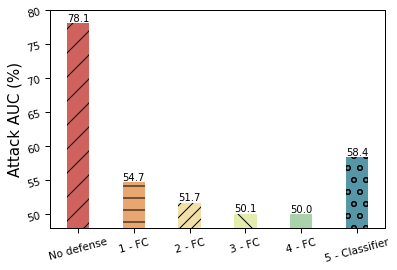

Columns to aggregate
['server_attack']
[52.09811473748226]
Columns to aggregate
['server_attack']
[50.58787755929455]
Columns to aggregate
['server_attack']
[50.1621731198054]
Columns to aggregate
['server_attack']
[50.15203729981755]
Columns to aggregate
['server_attack']
[50.01013581998783]
Columns to aggregate
['server_attack']
[50.932495438881006]
[0.5554168530182385, 0.29249676967422644, 0.11219821150564697, 0.017716886309495385, 0.009223719946587274, 0.5230062804940935]
Labels
['No defense', '1 - FC', '2 - FC', '3 - FC', '4 - FC', '5 - Classifier']
[52.1, 50.59, 50.16, 50.15, 50.01, 50.93]
None


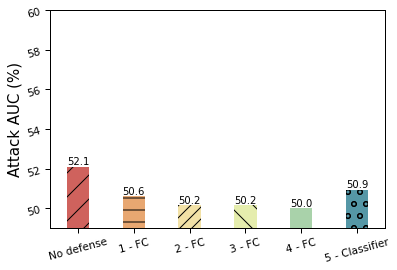

Columns to aggregate
['client_accuracy_1', 'client_accuracy_6', 'client_accuracy_4', 'client_accuracy_9', 'client_accuracy_3', 'client_accuracy_8', 'client_accuracy_5', 'client_accuracy_7', 'client_accuracy_2', 'client_accuracy_0']
[60.65274680721671, 60.87573484694912, 61.301439286438274, 60.2675856476789, 60.63247516724103, 60.389215487532944, 61.443340766268, 60.22704236772755, 60.61220352726535, 59.98378268801946]
Columns to aggregate
['client_accuracy_1', 'client_accuracy_6', 'client_accuracy_4', 'client_accuracy_9', 'client_accuracy_3', 'client_accuracy_8', 'client_accuracy_5', 'client_accuracy_7', 'client_accuracy_2', 'client_accuracy_0']
[60.68660044597608, 60.787958645854445, 60.72714372592743, 60.673018447192376, 60.7474153659031, 60.47719440502737, 60.78126900466248, 60.69329008716805, 60.72714372592743, 60.69329008716805]
Columns to aggregate
['client_accuracy_1', 'client_accuracy_6', 'client_accuracy_4', 'client_accuracy_9', 'client_accuracy_3', 'client_accuracy_8', 'clien

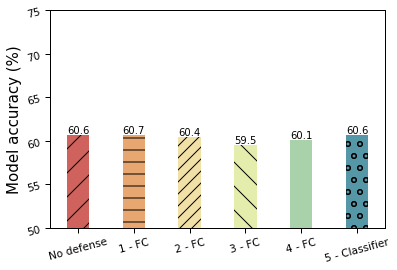

Columns to aggregate
['client_accuracy_1', 'client_accuracy_6', 'client_accuracy_4', 'client_accuracy_9', 'client_accuracy_3', 'client_accuracy_8', 'client_accuracy_5', 'client_accuracy_7', 'client_accuracy_2', 'client_accuracy_0']
[60.65274680721671, 60.87573484694912, 61.301439286438274, 60.2675856476789, 60.63247516724103, 60.389215487532944, 61.443340766268, 60.22704236772755, 60.61220352726535, 59.98378268801946]
Columns to aggregate
['client_auc_1', 'client_auc_6', 'client_auc_4', 'client_auc_9', 'client_auc_3', 'client_auc_8', 'client_auc_5', 'client_auc_7', 'client_auc_2', 'client_auc_0']
[76.0, 81.0, 77.0, 80.0, 77.0, 80.0, 79.0, 80.0, 75.0, 76.0]
Columns to aggregate
['client_accuracy_1', 'client_accuracy_6', 'client_accuracy_4', 'client_accuracy_9', 'client_accuracy_3', 'client_accuracy_8', 'client_accuracy_5', 'client_accuracy_7', 'client_accuracy_2', 'client_accuracy_0']
[60.68660044597608, 60.787958645854445, 60.72714372592743, 60.673018447192376, 60.7474153659031, 60.477

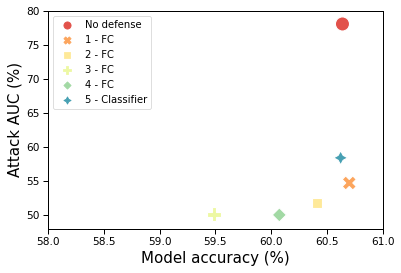

Columns to aggregate
['client_accuracy_1', 'client_accuracy_6', 'client_accuracy_4', 'client_accuracy_9', 'client_accuracy_3', 'client_accuracy_8', 'client_accuracy_5', 'client_accuracy_7', 'client_accuracy_2', 'client_accuracy_0']
[60.65274680721671, 60.87573484694912, 61.301439286438274, 60.2675856476789, 60.63247516724103, 60.389215487532944, 61.443340766268, 60.22704236772755, 60.61220352726535, 59.98378268801946]
Columns to aggregate
['server_attack']
[52.09811473748226]
Columns to aggregate
['client_accuracy_1', 'client_accuracy_6', 'client_accuracy_4', 'client_accuracy_9', 'client_accuracy_3', 'client_accuracy_8', 'client_accuracy_5', 'client_accuracy_7', 'client_accuracy_2', 'client_accuracy_0']
[60.68660044597608, 60.787958645854445, 60.72714372592743, 60.673018447192376, 60.7474153659031, 60.47719440502737, 60.78126900466248, 60.69329008716805, 60.72714372592743, 60.69329008716805]
Columns to aggregate
['server_attack']
[50.58787755929455]
Columns to aggregate
['client_accura

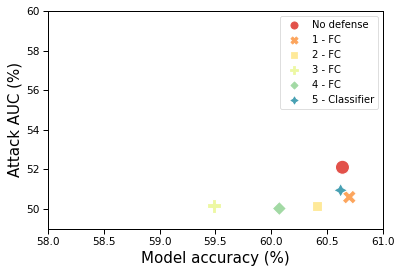

No defense
300
1 - FC
300
2 - FC
300
3 - FC
300
4 - FC
300
5 - Classifier
300


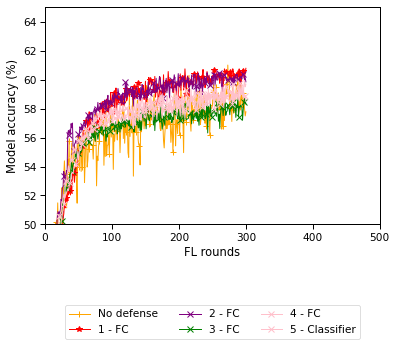

No defense
300
1 - FC
300
2 - FC
300
3 - FC
300
4 - FC
300
5 - Classifier
300


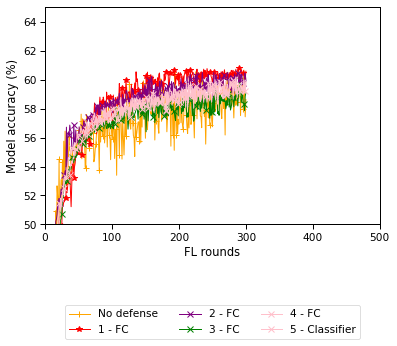

No defense
300
1 - FC
300
2 - FC
300
3 - FC
300
4 - FC
300
5 - Classifier
300


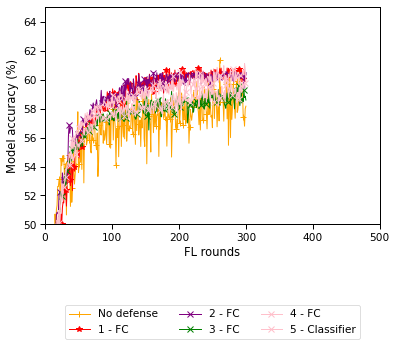

No defense
300
1 - FC
300
2 - FC
300
3 - FC
300
4 - FC
300
5 - Classifier
300


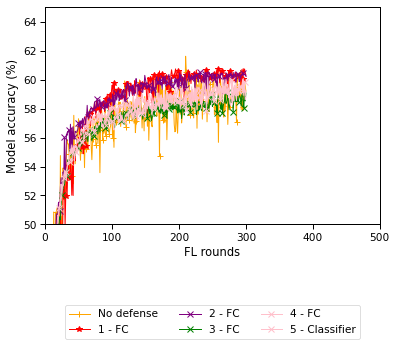

No defense
300
1 - FC
300
2 - FC
300
3 - FC
300
4 - FC
300
5 - Classifier
300


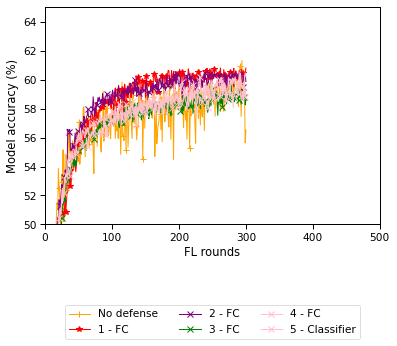

No defense
300
1 - FC
300
2 - FC
300
3 - FC
300
4 - FC
300
5 - Classifier
300


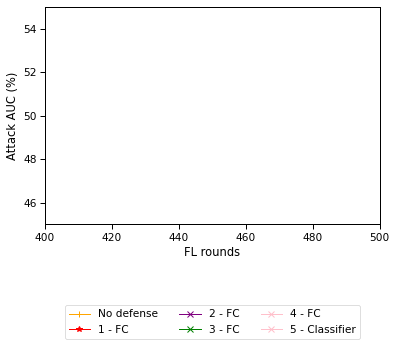

No defense
300
1 - FC
300
2 - FC
300
3 - FC
300
4 - FC
300
5 - Classifier
300


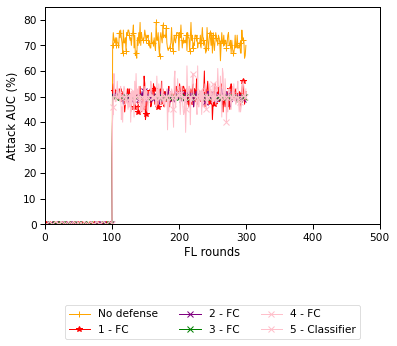

No defense
300
1 - FC
300
2 - FC
300
3 - FC
300
4 - FC
300
5 - Classifier
300


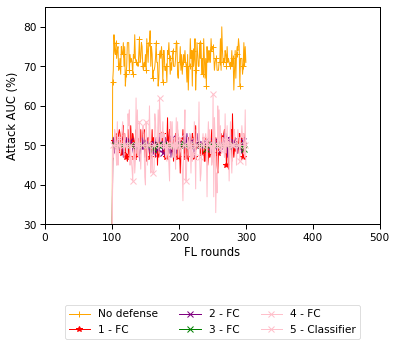

No defense
300
1 - FC
300
2 - FC
300
3 - FC
300
4 - FC
300
5 - Classifier
300


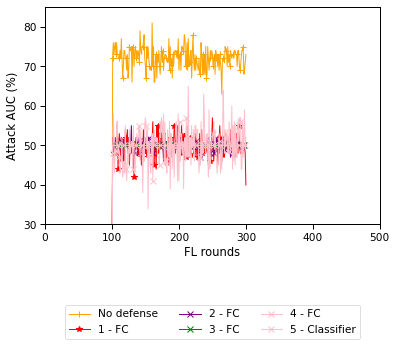

No defense
300
1 - FC
300
2 - FC
300
3 - FC
300
4 - FC
300
5 - Classifier
300


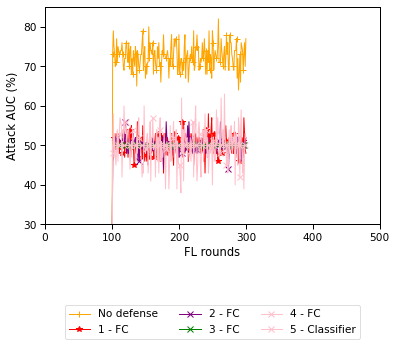

No defense
300
1 - FC
300
2 - FC
300
3 - FC
300
4 - FC
300
5 - Classifier
300


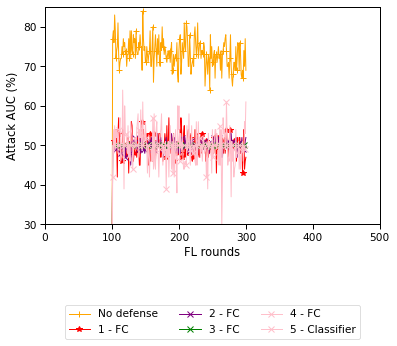

In [156]:
r = 300

generate_histogram(plot_config, "local_model_attack_accuracy_hist", "Attack AUC (%)", "client_auc", 48, 80, average=True, label_rotation=15, std = None)
generate_histogram(plot_config, "global_model_attack_accuracy_hist", "Attack AUC (%)", "server_attack", 49, 60, average=True, label_rotation=15, std = None)
#generate_xy_plot(plot_config, 'local_models_attack_accuracy', 'Attack AUC (%)', 'client_auc', 0, 100, average=True)
#generate_xy_plot(plot_config, 'global_model_attack_accuracy', 'Attack AUC (%)', 'server_attack', 0, 100, average=True)
#generate_xy_plot(plot_config, 'local_models_accuracy', 'Model accuracy (%)', 'client_accuracy', 0, 100, average=True)
generate_histogram(plot_config, "local_models_accuracy_hist", "Model accuracy (%)", "client_accuracy", 50, 75, average=True, label_rotation=15)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy', 'client_auc', 48, 80, 58, 61, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_server', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy', 'server_attack', 49, 60, 58, 61, average=True)

generate_xy_plot(plot_config, 'local_model0_accuracy', 'Model accuracy (%)', 'client_accuracy_0', 50, 65, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model1_accuracy', 'Model accuracy (%)', 'client_accuracy_1', 50, 65, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model2_accuracy', 'Model accuracy (%)', 'client_accuracy_2', 50, 65, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model3_accuracy', 'Model accuracy (%)', 'client_accuracy_3', 50, 65, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model4_accuracy', 'Model accuracy (%)', 'client_accuracy_4', 50, 65, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)

generate_xy_plot(plot_config, 'server_auc', 'Attack AUC (%)', 'server_auc', 45, 55, min_x=400, max_x = 500, average=True, extension='.png', max_range=r)

generate_xy_plot(plot_config, 'local_model0_auc', 'Attack AUC (%)', 'client_auc_0', 0, 85, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model1_auc', 'Attack AUC (%)', 'client_auc_1', 30, 85, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model2_auc', 'Attack AUC (%)', 'client_auc_2', 30, 85, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model3_auc', 'Attack AUC (%)', 'client_auc_3', 30, 85, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model4_auc', 'Attack AUC (%)', 'client_auc_4', 30, 85, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)

### Layers Analysis Purchase 2 Layers Adagrad

In [150]:
plot_config = {
                "dataset_name": "purchase_2_layers_pastel_layer_analysis",
                "dataset_pretty_name" : "CelebA_ResNet",

                "data":[

                        {
                            "exp_name" : "No defense",
                            "file_path": "ppm_baseline_purchase_2_layers.csv",
                            "color": "orange",
                            "symbol" : "+"
                        },

                     {
                            "exp_name" : "1 - L",
                            "file_path": "ppm_pastel_purchase_2_layers_features0_adagrad.csv",
                            "color": "red",
                            "symbol" : "*"
                        },
                                               
                                                {
                            "exp_name" : "2 - L",
                            "file_path": "ppm_pastel_purchase_2_layers_features2_adagrad.csv",
                            "color": "purple",
                            "symbol" : "x"
                        },
                                                              {
                            "exp_name" : "3 - L",
                            "file_path": "ppm_pastel_purchase_2_layers_classifier_adagrad.csv",
                            "color": "green",
                            "symbol" : "x"
                        }
                            
                    ]
                }

Columns to aggregate
['client_auc_1', 'client_auc_6', 'client_auc_4', 'client_auc_9', 'client_auc_3', 'client_auc_8', 'client_auc_5', 'client_auc_7', 'client_auc_2', 'client_auc_0']
[73.0, 78.0, 65.99999999999999, 71.0, 76.0, 71.0, 73.0, 74.0, 65.99999999999999, 71.0]
Columns to aggregate
['client_auc_1', 'client_auc_6', 'client_auc_4', 'client_auc_9', 'client_auc_3', 'client_auc_8', 'client_auc_5', 'client_auc_7', 'client_auc_2', 'client_auc_0']
[54.0, 51.0, 52.0, 53.0, 55.00000000000001, 53.0, 53.0, 52.0, 52.0, 54.0]
Columns to aggregate
['client_auc_1', 'client_auc_6', 'client_auc_4', 'client_auc_9', 'client_auc_3', 'client_auc_8', 'client_auc_5', 'client_auc_7', 'client_auc_2', 'client_auc_0']
[50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0]
Columns to aggregate
['client_auc_1', 'client_auc_6', 'client_auc_4', 'client_auc_9', 'client_auc_3', 'client_auc_8', 'client_auc_5', 'client_auc_7', 'client_auc_2', 'client_auc_0']
[50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 5

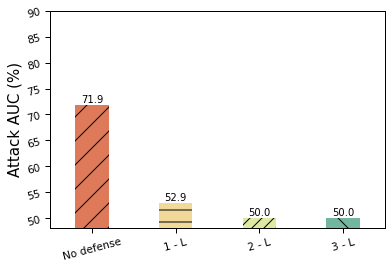

Columns to aggregate
['server_attack']
[68.55868639772957]
Columns to aggregate
['server_attack']
[50.24325967970809]
Columns to aggregate
['server_attack']
[50.01013581998783]
Columns to aggregate
['server_attack']
[50.03040745996351]
[0.058717812114169474, 0.11653989338580957, 0.005458306108993919, 0.013636351152518277]
Labels
['No defense', '1 - L', '2 - L', '3 - L']
[68.56, 50.24, 50.01, 50.03]
None


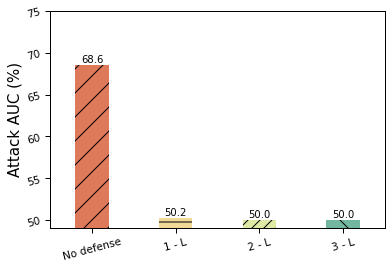

Columns to aggregate
['client_accuracy_1', 'client_accuracy_6', 'client_accuracy_4', 'client_accuracy_9', 'client_accuracy_3', 'client_accuracy_8', 'client_accuracy_5', 'client_accuracy_7', 'client_accuracy_2', 'client_accuracy_0']
[55.48347861341982, 55.17940401378472, 55.30103385363876, 55.037502533955, 55.21994729373606, 55.24021893371174, 55.037502533955, 54.89560105412528, 55.07804581390634, 55.05777417393068]
Columns to aggregate
['client_accuracy_1', 'client_accuracy_6', 'client_accuracy_4', 'client_accuracy_9', 'client_accuracy_3', 'client_accuracy_8', 'client_accuracy_5', 'client_accuracy_7', 'client_accuracy_2', 'client_accuracy_0']
[56.61869045205757, 56.598418812081896, 56.63896209203324, 56.61869045205757, 56.78086357186296, 57.00385161159538, 56.76059193188729, 56.25380093249544, 56.456517332252176, 56.35515913237381]
Columns to aggregate
['client_accuracy_1', 'client_accuracy_6', 'client_accuracy_4', 'client_accuracy_9', 'client_accuracy_3', 'client_accuracy_8', 'client_

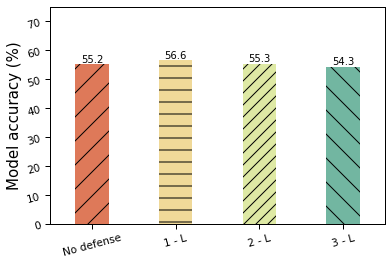

Columns to aggregate
['client_accuracy_1', 'client_accuracy_6', 'client_accuracy_4', 'client_accuracy_9', 'client_accuracy_3', 'client_accuracy_8', 'client_accuracy_5', 'client_accuracy_7', 'client_accuracy_2', 'client_accuracy_0']
[55.48347861341982, 55.17940401378472, 55.30103385363876, 55.037502533955, 55.21994729373606, 55.24021893371174, 55.037502533955, 54.89560105412528, 55.07804581390634, 55.05777417393068]
Columns to aggregate
['client_auc_1', 'client_auc_6', 'client_auc_4', 'client_auc_9', 'client_auc_3', 'client_auc_8', 'client_auc_5', 'client_auc_7', 'client_auc_2', 'client_auc_0']
[73.0, 78.0, 65.99999999999999, 71.0, 76.0, 71.0, 73.0, 74.0, 65.99999999999999, 71.0]
Columns to aggregate
['client_accuracy_1', 'client_accuracy_6', 'client_accuracy_4', 'client_accuracy_9', 'client_accuracy_3', 'client_accuracy_8', 'client_accuracy_5', 'client_accuracy_7', 'client_accuracy_2', 'client_accuracy_0']
[56.61869045205757, 56.598418812081896, 56.63896209203324, 56.61869045205757, 56

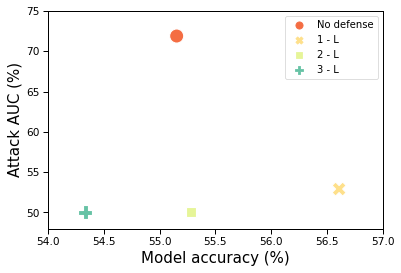

Columns to aggregate
['client_accuracy_1', 'client_accuracy_6', 'client_accuracy_4', 'client_accuracy_9', 'client_accuracy_3', 'client_accuracy_8', 'client_accuracy_5', 'client_accuracy_7', 'client_accuracy_2', 'client_accuracy_0']
[55.48347861341982, 55.17940401378472, 55.30103385363876, 55.037502533955, 55.21994729373606, 55.24021893371174, 55.037502533955, 54.89560105412528, 55.07804581390634, 55.05777417393068]
Columns to aggregate
['server_attack']
[68.55868639772957]
Columns to aggregate
['client_accuracy_1', 'client_accuracy_6', 'client_accuracy_4', 'client_accuracy_9', 'client_accuracy_3', 'client_accuracy_8', 'client_accuracy_5', 'client_accuracy_7', 'client_accuracy_2', 'client_accuracy_0']
[56.61869045205757, 56.598418812081896, 56.63896209203324, 56.61869045205757, 56.78086357186296, 57.00385161159538, 56.76059193188729, 56.25380093249544, 56.456517332252176, 56.35515913237381]
Columns to aggregate
['server_attack']
[50.24325967970809]
Columns to aggregate
['client_accuracy

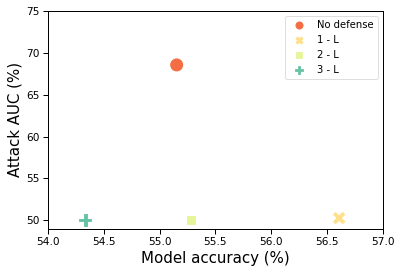

No defense
300
1 - L
300
2 - L
300
3 - L
300


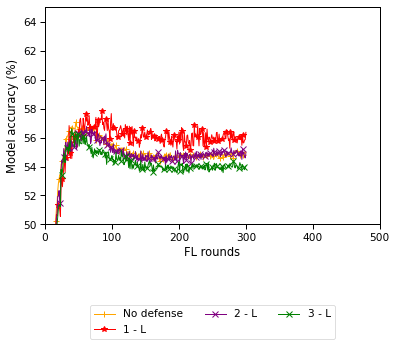

No defense
300
1 - L
300
2 - L
300
3 - L
300


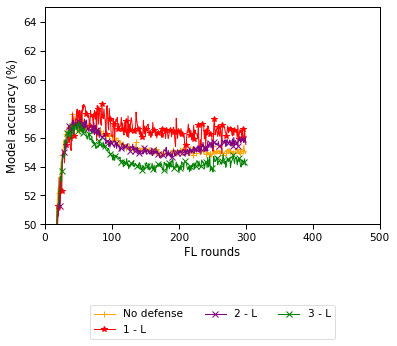

No defense
300
1 - L
300
2 - L
300
3 - L
300


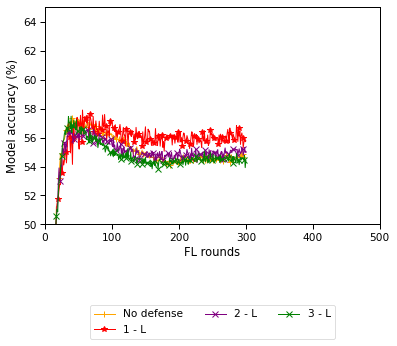

No defense
300
1 - L
300
2 - L
300
3 - L
300


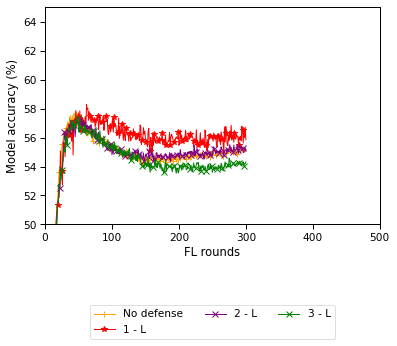

No defense
300
1 - L
300
2 - L
300
3 - L
300


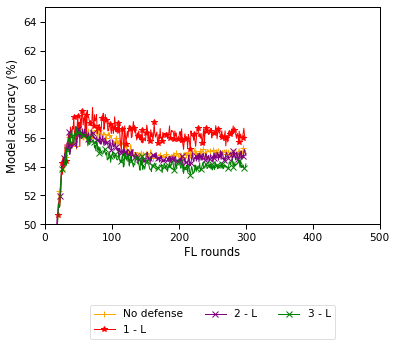

No defense
300
1 - L
300
2 - L
300
3 - L
300


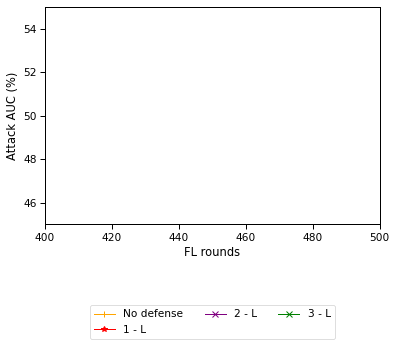

No defense
300
1 - L
300
2 - L
300
3 - L
300


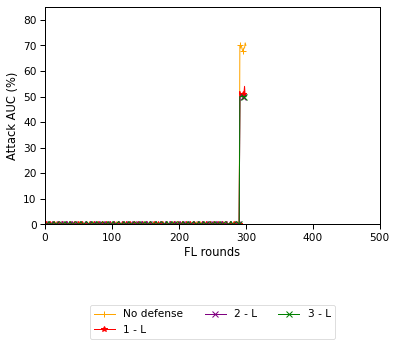

No defense
300
1 - L
300
2 - L
300
3 - L
300


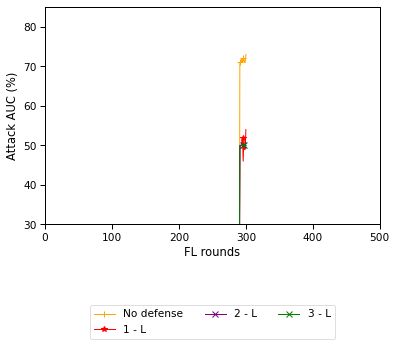

No defense
300
1 - L
300
2 - L
300
3 - L
300


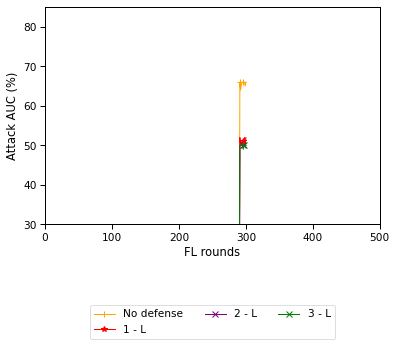

No defense
300
1 - L
300
2 - L
300
3 - L
300


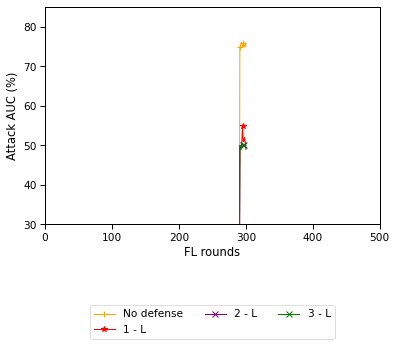

No defense
300
1 - L
300
2 - L
300
3 - L
300


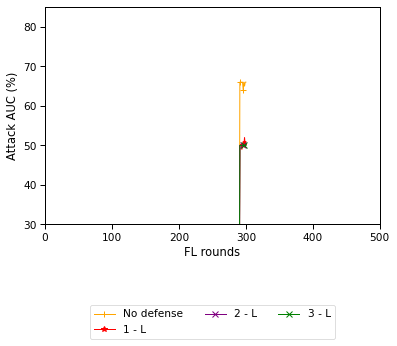

In [154]:
r = 300

generate_histogram(plot_config, "local_model_attack_accuracy_hist", "Attack AUC (%)", "client_auc", 48, 90, average=True, label_rotation=15, std = None)
generate_histogram(plot_config, "global_model_attack_accuracy_hist", "Attack AUC (%)", "server_attack", 49, 75, average=True, label_rotation=15, std = None)
#generate_xy_plot(plot_config, 'local_models_attack_accuracy', 'Attack AUC (%)', 'client_auc', 0, 100, average=True)
#generate_xy_plot(plot_config, 'global_model_attack_accuracy', 'Attack AUC (%)', 'server_attack', 0, 100, average=True)
#generate_xy_plot(plot_config, 'local_models_accuracy', 'Model accuracy (%)', 'client_accuracy', 0, 100, average=True)
generate_histogram(plot_config, "local_models_accuracy_hist", "Model accuracy (%)", "client_accuracy", 0, 75, average=True, label_rotation=15)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy', 'client_auc', 48, 75, 54, 57, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_server', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy', 'server_attack', 49, 75, 54, 57, average=True)

generate_xy_plot(plot_config, 'local_model0_accuracy', 'Model accuracy (%)', 'client_accuracy_0', 50, 65, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model1_accuracy', 'Model accuracy (%)', 'client_accuracy_1', 50, 65, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model2_accuracy', 'Model accuracy (%)', 'client_accuracy_2', 50, 65, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model3_accuracy', 'Model accuracy (%)', 'client_accuracy_3', 50, 65, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model4_accuracy', 'Model accuracy (%)', 'client_accuracy_4', 50, 65, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)

generate_xy_plot(plot_config, 'server_auc', 'Attack AUC (%)', 'server_auc', 45, 55, min_x=400, max_x = 500, average=True, extension='.png', max_range=r)

generate_xy_plot(plot_config, 'local_model0_auc', 'Attack AUC (%)', 'client_auc_0', 0, 85, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model1_auc', 'Attack AUC (%)', 'client_auc_1', 30, 85, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model2_auc', 'Attack AUC (%)', 'client_auc_2', 30, 85, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model3_auc', 'Attack AUC (%)', 'client_auc_3', 30, 85, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model4_auc', 'Attack AUC (%)', 'client_auc_4', 30, 85, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)

### Layers Analysis Purchase 2 Layers Adam

In [102]:
plot_config = {
                "dataset_name": "purchase_2_layers_pastelp_layer_analysis",
                "dataset_pretty_name" : "CelebA_ResNet",

                "data":[

                        {
                            "exp_name" : "No defense",
                            "file_path": "ppm_baseline_purchase_2_layers.csv",
                            "color": "orange",
                            "symbol" : "+"
                        },

                     {
                            "exp_name" : "1 - FC",
                            "file_path": "ppm_pastel_purchase_2_layers_features0_adam.csv",
                            "color": "red",
                            "symbol" : "*"
                        },
                                               
                                                {
                            "exp_name" : "2 - FC",
                            "file_path": "ppm_pastel_purchase_2_layers_features2_adam.csv",
                            "color": "purple",
                            "symbol" : "x"
                        },
                                                              {
                            "exp_name" : "3 - Classifier",
                            "file_path": "ppm_pastel_purchase_2_layers_classifier_adam.csv",
                            "color": "green",
                            "symbol" : "x"
                        }
                            
                    ]
                }

Columns to aggregate
['client_auc_1', 'client_auc_6', 'client_auc_4', 'client_auc_9', 'client_auc_3', 'client_auc_8', 'client_auc_5', 'client_auc_7', 'client_auc_2', 'client_auc_0']
[79.0, 86.99999999999999, 81.0, 81.0, 84.0, 84.0, 85.0, 82.0, 79.0, 78.0]
Columns to aggregate
['client_auc_1', 'client_auc_6', 'client_auc_4', 'client_auc_9', 'client_auc_3', 'client_auc_8', 'client_auc_5', 'client_auc_7', 'client_auc_2', 'client_auc_0']
[51.0, 54.0, 52.0, 51.0, 51.0, 52.0, 52.0, 53.0, 53.0, 53.0]
Columns to aggregate
['client_auc_1', 'client_auc_6', 'client_auc_4', 'client_auc_9', 'client_auc_3', 'client_auc_8', 'client_auc_5', 'client_auc_7', 'client_auc_2', 'client_auc_0']
[51.0, 52.0, 51.0, 51.0, 50.0, 51.0, 51.0, 50.0, 50.0, 50.0]
Columns to aggregate
['client_auc_1', 'client_auc_6', 'client_auc_4', 'client_auc_9', 'client_auc_3', 'client_auc_8', 'client_auc_5', 'client_auc_7', 'client_auc_2', 'client_auc_0']
[50.0, 50.0, 50.0, 52.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0]
Columns to aggr

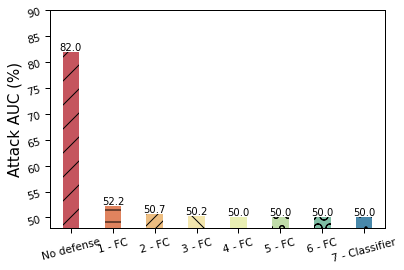

Columns to aggregate
['server_attack']
[70.70748023515102]
Columns to aggregate
['server_attack']
[50.212852219744576]
Columns to aggregate
['server_attack']
[50.04054327995134]
Columns to aggregate
['server_attack']
[50.01013581998783]
Columns to aggregate
['server_attack']
[50.0]
Columns to aggregate
['server_attack']
[50.0]
Columns to aggregate
['server_attack']
[50.0]
Columns to aggregate
['server_attack']
[50.0]
[0.7303144926190898, 0.1356686225968143, 0.02364059150555563, 0.008419444418118587, 0.0, 0.0, 0.0, 0.0]
Labels
['No defense', '1 - FC', '2 - FC', '3 - FC', '4 - FC', '5 - FC', '6 - FC', '7 - Classifier']
[70.71, 50.21, 50.04, 50.01, 50.0, 50.0, 50.0, 50.0]
None


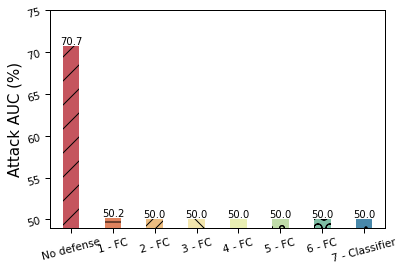

Columns to aggregate
['client_accuracy_1', 'client_accuracy_6', 'client_accuracy_4', 'client_accuracy_9', 'client_accuracy_3', 'client_accuracy_8', 'client_accuracy_5', 'client_accuracy_7', 'client_accuracy_2', 'client_accuracy_0']
[56.9835799716197, 57.814717210622334, 57.75390229069532, 57.28765457125481, 56.740320291911615, 57.53091425096291, 56.72004865193594, 57.226839651327786, 56.01054125278735, 57.24711129130347]
Columns to aggregate
['client_accuracy_1', 'client_accuracy_6', 'client_accuracy_4', 'client_accuracy_9', 'client_accuracy_3', 'client_accuracy_8', 'client_accuracy_5', 'client_accuracy_7', 'client_accuracy_2', 'client_accuracy_0']
[60.1864990877762, 59.639164808433, 59.82160956821407, 60.20677072775188, 59.98378268801946, 59.61889316845733, 60.34867220758159, 59.29454692884655, 60.1864990877762, 60.30812892763024]
Columns to aggregate
['client_accuracy_1', 'client_accuracy_6', 'client_accuracy_4', 'client_accuracy_9', 'client_accuracy_3', 'client_accuracy_8', 'client_

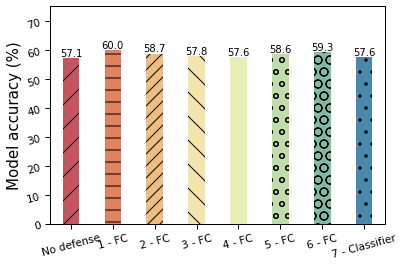

Columns to aggregate
['client_accuracy_1', 'client_accuracy_6', 'client_accuracy_4', 'client_accuracy_9', 'client_accuracy_3', 'client_accuracy_8', 'client_accuracy_5', 'client_accuracy_7', 'client_accuracy_2', 'client_accuracy_0']
[56.9835799716197, 57.814717210622334, 57.75390229069532, 57.28765457125481, 56.740320291911615, 57.53091425096291, 56.72004865193594, 57.226839651327786, 56.01054125278735, 57.24711129130347]
Columns to aggregate
['client_auc_1', 'client_auc_6', 'client_auc_4', 'client_auc_9', 'client_auc_3', 'client_auc_8', 'client_auc_5', 'client_auc_7', 'client_auc_2', 'client_auc_0']
[79.0, 86.99999999999999, 81.0, 81.0, 84.0, 84.0, 85.0, 82.0, 79.0, 78.0]
Columns to aggregate
['client_accuracy_1', 'client_accuracy_6', 'client_accuracy_4', 'client_accuracy_9', 'client_accuracy_3', 'client_accuracy_8', 'client_accuracy_5', 'client_accuracy_7', 'client_accuracy_2', 'client_accuracy_0']
[60.1864990877762, 59.639164808433, 59.82160956821407, 60.20677072775188, 59.9837826880

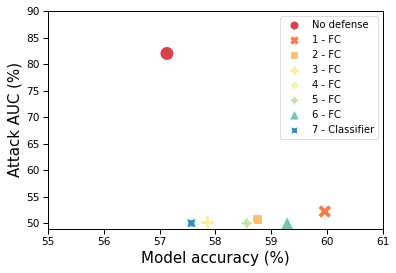

Columns to aggregate
['client_accuracy_1', 'client_accuracy_6', 'client_accuracy_4', 'client_accuracy_9', 'client_accuracy_3', 'client_accuracy_8', 'client_accuracy_5', 'client_accuracy_7', 'client_accuracy_2', 'client_accuracy_0']
[56.9835799716197, 57.814717210622334, 57.75390229069532, 57.28765457125481, 56.740320291911615, 57.53091425096291, 56.72004865193594, 57.226839651327786, 56.01054125278735, 57.24711129130347]
Columns to aggregate
['server_attack']
[70.70748023515102]
Columns to aggregate
['client_accuracy_1', 'client_accuracy_6', 'client_accuracy_4', 'client_accuracy_9', 'client_accuracy_3', 'client_accuracy_8', 'client_accuracy_5', 'client_accuracy_7', 'client_accuracy_2', 'client_accuracy_0']
[60.1864990877762, 59.639164808433, 59.82160956821407, 60.20677072775188, 59.98378268801946, 59.61889316845733, 60.34867220758159, 59.29454692884655, 60.1864990877762, 60.30812892763024]
Columns to aggregate
['server_attack']
[50.212852219744576]
Columns to aggregate
['client_accurac

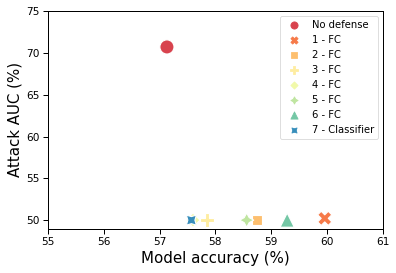

No defense
300
1 - FC
300
2 - FC
300
3 - FC
300
4 - FC
300
5 - FC
300
6 - FC
300
7 - Classifier
300


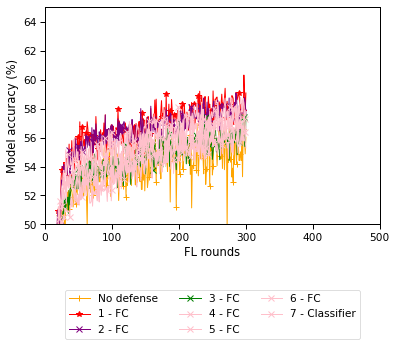

No defense
300
1 - FC
300
2 - FC
300
3 - FC
300
4 - FC
300
5 - FC
300
6 - FC
300
7 - Classifier
300


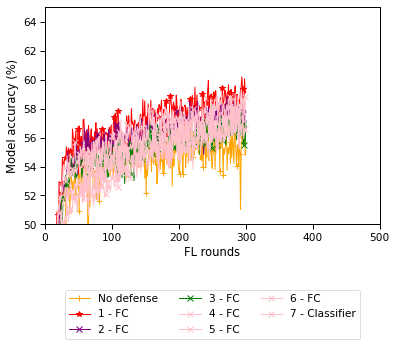

No defense
300
1 - FC
300
2 - FC
300
3 - FC
300
4 - FC
300
5 - FC
300
6 - FC
300
7 - Classifier
300


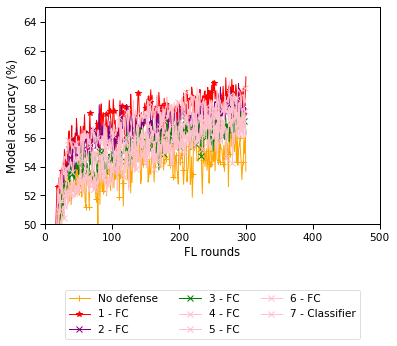

No defense
300
1 - FC
300
2 - FC
300
3 - FC
300
4 - FC
300
5 - FC
300
6 - FC
300
7 - Classifier
300


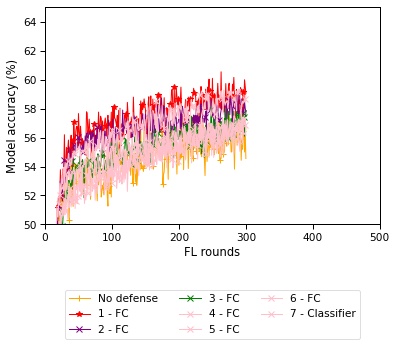

No defense
300
1 - FC
300
2 - FC
300
3 - FC
300
4 - FC
300
5 - FC
300
6 - FC
300
7 - Classifier
300


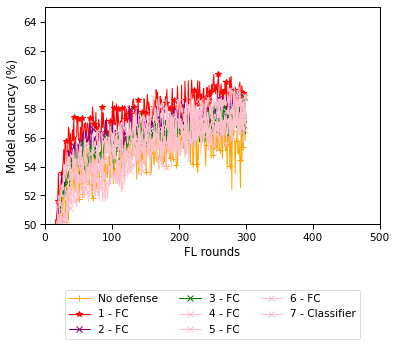

No defense
300
1 - FC
300
2 - FC
300
3 - FC
300
4 - FC
300
5 - FC
300
6 - FC
300
7 - Classifier
300


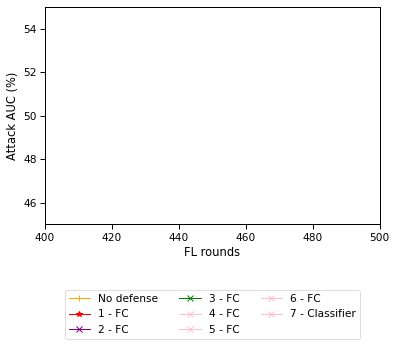

No defense
300
1 - FC
300
2 - FC
300
3 - FC
300
4 - FC
300
5 - FC
300
6 - FC
300
7 - Classifier
300


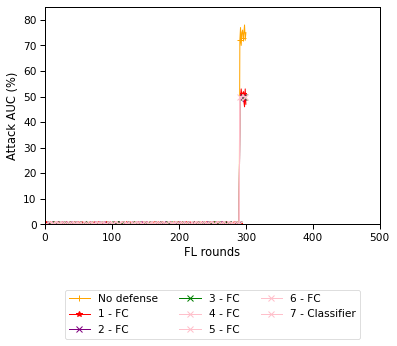

No defense
300
1 - FC
300
2 - FC
300
3 - FC
300
4 - FC
300
5 - FC
300
6 - FC
300
7 - Classifier
300


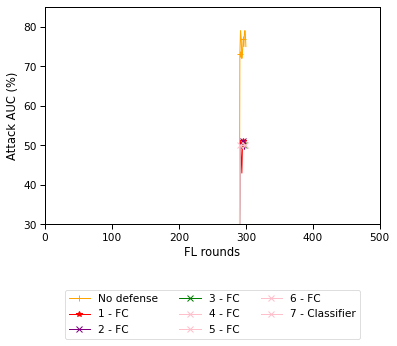

No defense
300
1 - FC
300
2 - FC
300
3 - FC
300
4 - FC
300
5 - FC
300
6 - FC
300
7 - Classifier
300


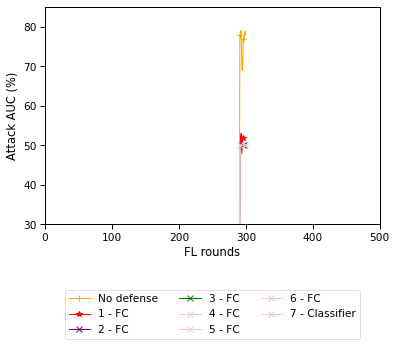

No defense
300
1 - FC
300
2 - FC
300
3 - FC
300
4 - FC
300
5 - FC
300
6 - FC
300
7 - Classifier
300


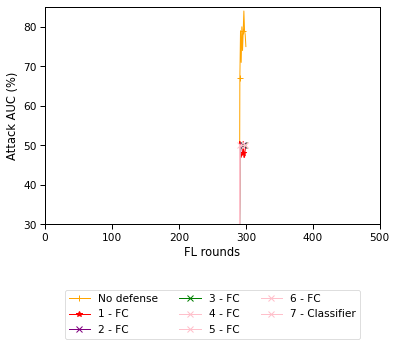

No defense
300
1 - FC
300
2 - FC
300
3 - FC
300
4 - FC
300
5 - FC
300
6 - FC
300
7 - Classifier
300


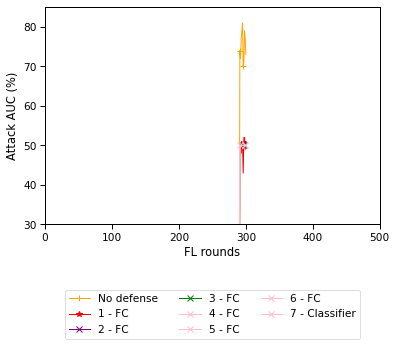

In [144]:
r = 300

generate_histogram(plot_config, "local_model_attack_accuracy_hist", "Attack AUC (%)", "client_auc", 48, 90, average=True, label_rotation=15, std = None)
generate_histogram(plot_config, "global_model_attack_accuracy_hist", "Attack AUC (%)", "server_attack", 49, 75, average=True, label_rotation=15, std = None)
#generate_xy_plot(plot_config, 'local_models_attack_accuracy', 'Attack AUC (%)', 'client_auc', 0, 100, average=True)
#generate_xy_plot(plot_config, 'global_model_attack_accuracy', 'Attack AUC (%)', 'server_attack', 0, 100, average=True)
#generate_xy_plot(plot_config, 'local_models_accuracy', 'Model accuracy (%)', 'client_accuracy', 0, 100, average=True)
generate_histogram(plot_config, "local_models_accuracy_hist", "Model accuracy (%)", "client_accuracy", 0, 75, average=True, label_rotation=15)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy', 'client_auc', 49, 90, 55, 61, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_server', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy', 'server_attack', 49, 75, 55, 61, average=True)

generate_xy_plot(plot_config, 'local_model0_accuracy', 'Model accuracy (%)', 'client_accuracy_0', 50, 65, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model1_accuracy', 'Model accuracy (%)', 'client_accuracy_1', 50, 65, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model2_accuracy', 'Model accuracy (%)', 'client_accuracy_2', 50, 65, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model3_accuracy', 'Model accuracy (%)', 'client_accuracy_3', 50, 65, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model4_accuracy', 'Model accuracy (%)', 'client_accuracy_4', 50, 65, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)

generate_xy_plot(plot_config, 'server_auc', 'Attack AUC (%)', 'server_auc', 45, 55, min_x=400, max_x = 500, average=True, extension='.png', max_range=r)

generate_xy_plot(plot_config, 'local_model0_auc', 'Attack AUC (%)', 'client_auc_0', 0, 85, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model1_auc', 'Attack AUC (%)', 'client_auc_1', 30, 85, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model2_auc', 'Attack AUC (%)', 'client_auc_2', 30, 85, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model3_auc', 'Attack AUC (%)', 'client_auc_3', 30, 85, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model4_auc', 'Attack AUC (%)', 'client_auc_4', 30, 85, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)

### Layers Analysis Purchase 6 Layers Adagrad

In [136]:
plot_config = {
                "dataset_name": "purchase_6_layers_adagrad_layer_analysis",
                "dataset_pretty_name" : "CelebA_ResNet",

                "data":[

                        {
                            "exp_name" : "No defense",
                            "file_path": "ppm_baseline_purchase_6_layers.csv",
                            "color": "orange",
                            "symbol" : "+"
                        },

                     {
                            "exp_name" : "1 - FC",
                            "file_path": "ppm_pastel_purchase_6_layers_features0_adagrad.csv",
                            "color": "red",
                            "symbol" : "*"
                        },
                                               
                                                {
                            "exp_name" : "2 - FC",
                            "file_path": "ppm_pastel_purchase_6_layers_features2_adagrad.csv",
                            "color": "purple",
                            "symbol" : "x"
                        },
                                                              {
                            "exp_name" : "3 - FC",
                            "file_path": "ppm_pastel_purchase_6_layers_features4_adagrad.csv",
                            "color": "green",
                            "symbol" : "x"
                        },
                                                                                                      {
                            "exp_name" : "4 - FC",
                            "file_path": "ppm_pastel_purchase_6_layers_features6_adagrad.csv",
                            "color": "pink",
                            "symbol" : "x"
                                                                                                      },
                             {
                            "exp_name" : "5 - FC",
                            "file_path": "ppm_pastel_purchase_6_layers_features8_adagrad.csv",
                            "color": "pink",
                            "symbol" : "x"
                                                                                                      },
                    {
                                "exp_name" : "6 - FC",
                            "file_path": "ppm_pastel_purchase_6_layers_features10_adagrad.csv",
                            "color": "pink",
                            "symbol" : "x"
                                                                                                      },
                     {
                                "exp_name" : "7 - Classifier",
                            "file_path": "ppm_pastel_purchase_6_layers_classifier_adagrad.csv",
                            "color": "pink",
                            "symbol" : "x"
                                                                                                      } 
                            
                    ]
                }

Columns to aggregate
['client_auc_1', 'client_auc_6', 'client_auc_4', 'client_auc_9', 'client_auc_3', 'client_auc_8', 'client_auc_5', 'client_auc_7', 'client_auc_2', 'client_auc_0']
[79.0, 86.99999999999999, 81.0, 81.0, 84.0, 84.0, 85.0, 82.0, 79.0, 78.0]
Columns to aggregate
['client_auc_1', 'client_auc_6', 'client_auc_4', 'client_auc_9', 'client_auc_3', 'client_auc_8', 'client_auc_5', 'client_auc_7', 'client_auc_2', 'client_auc_0']
[51.0, 54.0, 52.0, 51.0, 51.0, 52.0, 52.0, 53.0, 53.0, 53.0]
Columns to aggregate
['client_auc_1', 'client_auc_6', 'client_auc_4', 'client_auc_9', 'client_auc_3', 'client_auc_8', 'client_auc_5', 'client_auc_7', 'client_auc_2', 'client_auc_0']
[51.0, 52.0, 51.0, 51.0, 50.0, 51.0, 51.0, 50.0, 50.0, 50.0]
Columns to aggregate
['client_auc_1', 'client_auc_6', 'client_auc_4', 'client_auc_9', 'client_auc_3', 'client_auc_8', 'client_auc_5', 'client_auc_7', 'client_auc_2', 'client_auc_0']
[50.0, 50.0, 50.0, 52.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0]
Columns to aggr

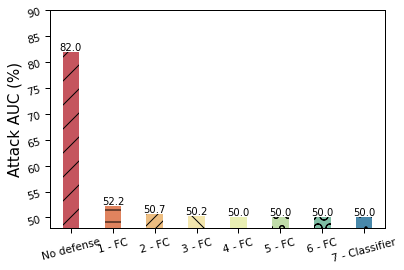

Columns to aggregate
['server_attack']
[70.70748023515102]
Columns to aggregate
['server_attack']
[50.212852219744576]
Columns to aggregate
['server_attack']
[50.04054327995134]
Columns to aggregate
['server_attack']
[50.01013581998783]
Columns to aggregate
['server_attack']
[50.0]
Columns to aggregate
['server_attack']
[50.0]
Columns to aggregate
['server_attack']
[50.0]
Columns to aggregate
['server_attack']
[50.0]
[0.7303144926190898, 0.1356686225968143, 0.02364059150555563, 0.008419444418118587, 0.0, 0.0, 0.0, 0.0]
Labels
['No defense', '1 - FC', '2 - FC', '3 - FC', '4 - FC', '5 - FC', '6 - FC', '7 - Classifier']
[70.71, 50.21, 50.04, 50.01, 50.0, 50.0, 50.0, 50.0]
None


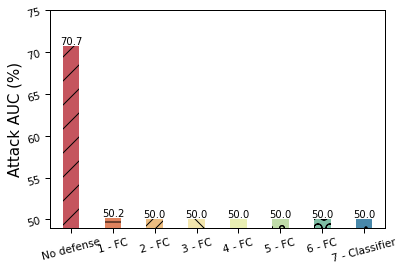

Columns to aggregate
['client_accuracy_1', 'client_accuracy_6', 'client_accuracy_4', 'client_accuracy_9', 'client_accuracy_3', 'client_accuracy_8', 'client_accuracy_5', 'client_accuracy_7', 'client_accuracy_2', 'client_accuracy_0']
[56.9835799716197, 57.814717210622334, 57.75390229069532, 57.28765457125481, 56.740320291911615, 57.53091425096291, 56.72004865193594, 57.226839651327786, 56.01054125278735, 57.24711129130347]
Columns to aggregate
['client_accuracy_1', 'client_accuracy_6', 'client_accuracy_4', 'client_accuracy_9', 'client_accuracy_3', 'client_accuracy_8', 'client_accuracy_5', 'client_accuracy_7', 'client_accuracy_2', 'client_accuracy_0']
[60.1864990877762, 59.639164808433, 59.82160956821407, 60.20677072775188, 59.98378268801946, 59.61889316845733, 60.34867220758159, 59.29454692884655, 60.1864990877762, 60.30812892763024]
Columns to aggregate
['client_accuracy_1', 'client_accuracy_6', 'client_accuracy_4', 'client_accuracy_9', 'client_accuracy_3', 'client_accuracy_8', 'client_

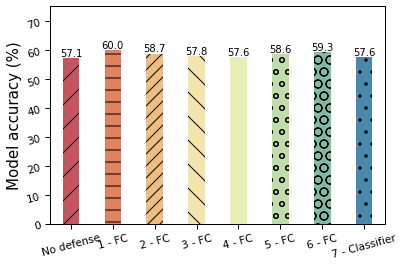

Columns to aggregate
['client_accuracy_1', 'client_accuracy_6', 'client_accuracy_4', 'client_accuracy_9', 'client_accuracy_3', 'client_accuracy_8', 'client_accuracy_5', 'client_accuracy_7', 'client_accuracy_2', 'client_accuracy_0']
[56.9835799716197, 57.814717210622334, 57.75390229069532, 57.28765457125481, 56.740320291911615, 57.53091425096291, 56.72004865193594, 57.226839651327786, 56.01054125278735, 57.24711129130347]
Columns to aggregate
['client_auc_1', 'client_auc_6', 'client_auc_4', 'client_auc_9', 'client_auc_3', 'client_auc_8', 'client_auc_5', 'client_auc_7', 'client_auc_2', 'client_auc_0']
[79.0, 86.99999999999999, 81.0, 81.0, 84.0, 84.0, 85.0, 82.0, 79.0, 78.0]
Columns to aggregate
['client_accuracy_1', 'client_accuracy_6', 'client_accuracy_4', 'client_accuracy_9', 'client_accuracy_3', 'client_accuracy_8', 'client_accuracy_5', 'client_accuracy_7', 'client_accuracy_2', 'client_accuracy_0']
[60.1864990877762, 59.639164808433, 59.82160956821407, 60.20677072775188, 59.9837826880

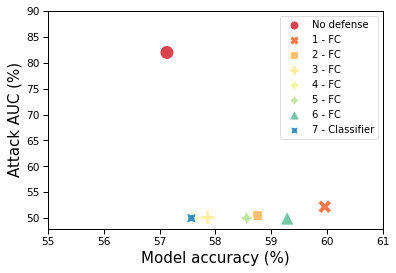

Columns to aggregate
['client_accuracy_1', 'client_accuracy_6', 'client_accuracy_4', 'client_accuracy_9', 'client_accuracy_3', 'client_accuracy_8', 'client_accuracy_5', 'client_accuracy_7', 'client_accuracy_2', 'client_accuracy_0']
[56.9835799716197, 57.814717210622334, 57.75390229069532, 57.28765457125481, 56.740320291911615, 57.53091425096291, 56.72004865193594, 57.226839651327786, 56.01054125278735, 57.24711129130347]
Columns to aggregate
['server_attack']
[70.70748023515102]
Columns to aggregate
['client_accuracy_1', 'client_accuracy_6', 'client_accuracy_4', 'client_accuracy_9', 'client_accuracy_3', 'client_accuracy_8', 'client_accuracy_5', 'client_accuracy_7', 'client_accuracy_2', 'client_accuracy_0']
[60.1864990877762, 59.639164808433, 59.82160956821407, 60.20677072775188, 59.98378268801946, 59.61889316845733, 60.34867220758159, 59.29454692884655, 60.1864990877762, 60.30812892763024]
Columns to aggregate
['server_attack']
[50.212852219744576]
Columns to aggregate
['client_accurac

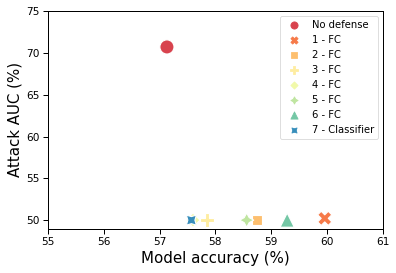

No defense
300
1 - FC
300
2 - FC
300
3 - FC
300
4 - FC
300
5 - FC
300
6 - FC
300
7 - Classifier
300


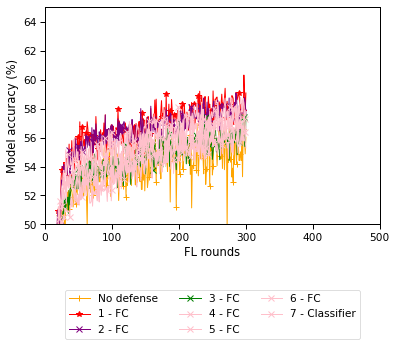

No defense
300
1 - FC
300
2 - FC
300
3 - FC
300
4 - FC
300
5 - FC
300
6 - FC
300
7 - Classifier
300


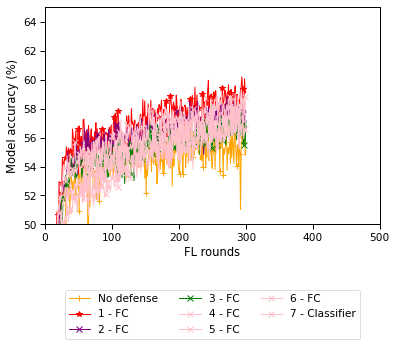

No defense
300
1 - FC
300
2 - FC
300
3 - FC
300
4 - FC
300
5 - FC
300
6 - FC
300
7 - Classifier
300


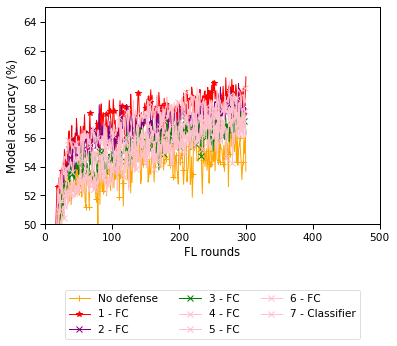

No defense
300
1 - FC
300
2 - FC
300
3 - FC
300
4 - FC
300
5 - FC
300
6 - FC
300
7 - Classifier
300


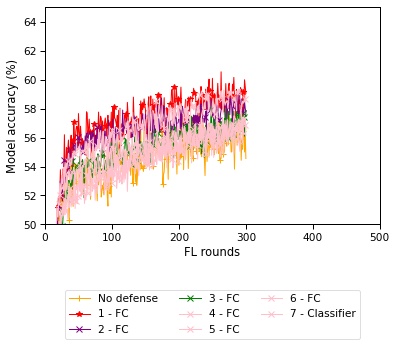

No defense
300
1 - FC
300
2 - FC
300
3 - FC
300
4 - FC
300
5 - FC
300
6 - FC
300
7 - Classifier
300


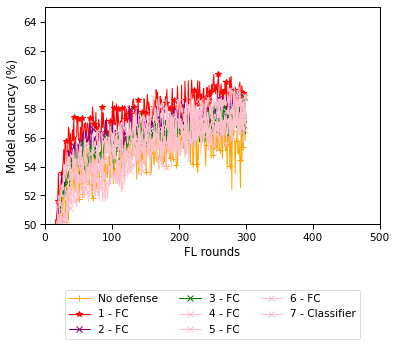

No defense
300
1 - FC
300
2 - FC
300
3 - FC
300
4 - FC
300
5 - FC
300
6 - FC
300
7 - Classifier
300


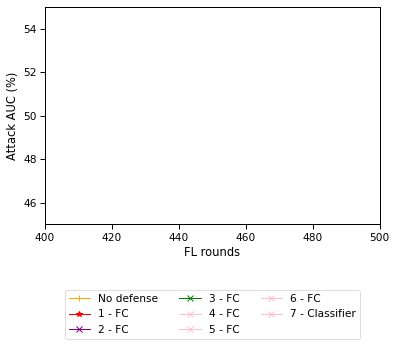

No defense
300
1 - FC
300
2 - FC
300
3 - FC
300
4 - FC
300
5 - FC
300
6 - FC
300
7 - Classifier
300


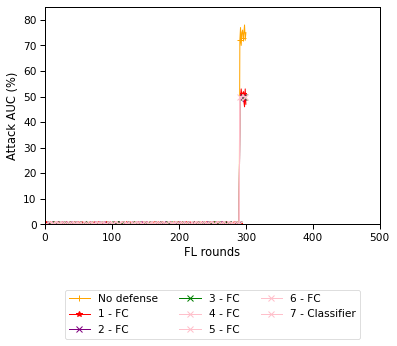

No defense
300
1 - FC
300
2 - FC
300
3 - FC
300
4 - FC
300
5 - FC
300
6 - FC
300
7 - Classifier
300


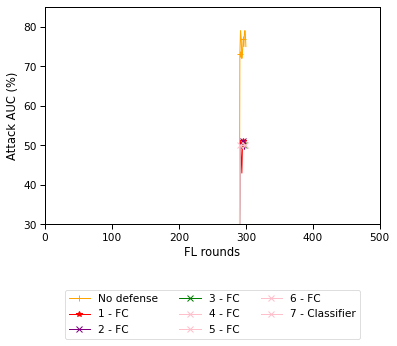

No defense
300
1 - FC
300
2 - FC
300
3 - FC
300
4 - FC
300
5 - FC
300
6 - FC
300
7 - Classifier
300


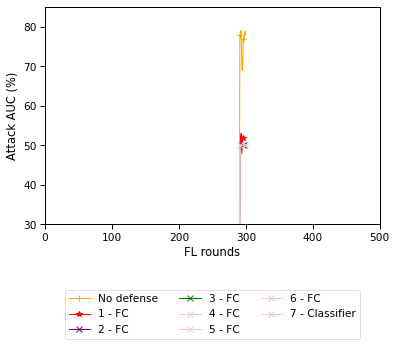

No defense
300
1 - FC
300
2 - FC
300
3 - FC
300
4 - FC
300
5 - FC
300
6 - FC
300
7 - Classifier
300


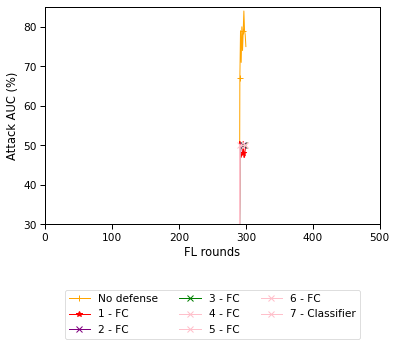

No defense
300
1 - FC
300
2 - FC
300
3 - FC
300
4 - FC
300
5 - FC
300
6 - FC
300
7 - Classifier
300


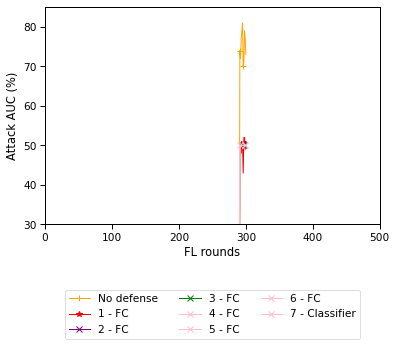

In [142]:
r = 300

generate_histogram(plot_config, "local_model_attack_accuracy_hist", "Attack AUC (%)", "client_auc", 48, 90, average=True, label_rotation=15, std = None)
generate_histogram(plot_config, "global_model_attack_accuracy_hist", "Attack AUC (%)", "server_attack", 49, 75, average=True, label_rotation=15, std = None)
#generate_xy_plot(plot_config, 'local_models_attack_accuracy', 'Attack AUC (%)', 'client_auc', 0, 100, average=True)
#generate_xy_plot(plot_config, 'global_model_attack_accuracy', 'Attack AUC (%)', 'server_attack', 0, 100, average=True)
#generate_xy_plot(plot_config, 'local_models_accuracy', 'Model accuracy (%)', 'client_accuracy', 0, 100, average=True)
generate_histogram(plot_config, "local_models_accuracy_hist", "Model accuracy (%)", "client_accuracy", 0, 75, average=True, label_rotation=15)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy', 'client_auc', 48, 90, 55, 61, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_server', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy', 'server_attack', 49, 75, 55, 61, average=True)

generate_xy_plot(plot_config, 'local_model0_accuracy', 'Model accuracy (%)', 'client_accuracy_0', 50, 65, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model1_accuracy', 'Model accuracy (%)', 'client_accuracy_1', 50, 65, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model2_accuracy', 'Model accuracy (%)', 'client_accuracy_2', 50, 65, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model3_accuracy', 'Model accuracy (%)', 'client_accuracy_3', 50, 65, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model4_accuracy', 'Model accuracy (%)', 'client_accuracy_4', 50, 65, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)

generate_xy_plot(plot_config, 'server_auc', 'Attack AUC (%)', 'server_auc', 45, 55, min_x=400, max_x = 500, average=True, extension='.png', max_range=r)

generate_xy_plot(plot_config, 'local_model0_auc', 'Attack AUC (%)', 'client_auc_0', 0, 85, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model1_auc', 'Attack AUC (%)', 'client_auc_1', 30, 85, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model2_auc', 'Attack AUC (%)', 'client_auc_2', 30, 85, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model3_auc', 'Attack AUC (%)', 'client_auc_3', 30, 85, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model4_auc', 'Attack AUC (%)', 'client_auc_4', 30, 85, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)

### Layers Analysis Texas 4 Layers

In [175]:
plot_config = {
                "dataset_name": "texas_layer_analysis",
                "dataset_pretty_name" : "CelebA_ResNet",

                "data":[

                        {
                            "exp_name" : "No defense",
                            "file_path": "ppm_baseline_texas.csv",
                            "color": "orange",
                            "symbol" : "+"
                        },

                     {
                            "exp_name" : "1 - FC",
                            "file_path": "ppm_pastel_adagrad_features0_texas.csv",
                            "color": "red",
                            "symbol" : "*"
                        },
                                               
                                                {
                            "exp_name" : "2 - FC",
                            "file_path": "ppm_pastel_adagrad_features2_texas.csv",
                            "color": "purple",
                            "symbol" : "x"
                        },
                                                              {
                            "exp_name" : "3 - FC",
                            "file_path": "ppm_pastel_adagrad_features4_texas.csv",
                            "color": "green",
                            "symbol" : "x"
                        },
                                                                                                      {
                            "exp_name" : "4 - FC",
                            "file_path": "ppm_pastel_adagrad_features6_texas.csv",
                            "color": "pink",
                            "symbol" : "x"
                                                                                                      },
                                                                                                                                        {
                            "exp_name" : "5 - Classifier",
                            "file_path": "ppm_pastel_adagrad_classifier_texas.csv",
                            "color": "pink",
                            "symbol" : "x"
                                                                                                      } 
                            
                    ]
                }

Columns to aggregate
['client_auc_8', 'client_auc_5', 'client_auc_3', 'client_auc_4', 'client_auc_2', 'client_auc_0', 'client_auc_6', 'client_auc_1', 'client_auc_7', 'client_auc_9']
[84.3220338983051, 88.55932203389831, 85.59322033898304, 88.98305084745763, 86.01694915254237, 86.01694915254238, 81.77966101694915, 87.71186440677967, 87.28813559322035, 83.47457627118644]
Columns to aggregate
['client_auc_8', 'client_auc_5', 'client_auc_3', 'client_auc_4', 'client_auc_2', 'client_auc_0', 'client_auc_6', 'client_auc_1', 'client_auc_7', 'client_auc_9']
[52.54237288135594, 52.966101694915245, 51.27118644067797, 51.271186440677965, 51.69491525423729, 51.271186440677965, 50.84745762711864, 52.54237288135594, 51.694915254237294, 50.84745762711864]
Columns to aggregate
['client_auc_8', 'client_auc_5', 'client_auc_3', 'client_auc_4', 'client_auc_2', 'client_auc_0', 'client_auc_6', 'client_auc_1', 'client_auc_7', 'client_auc_9']
[50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0]
Columns 

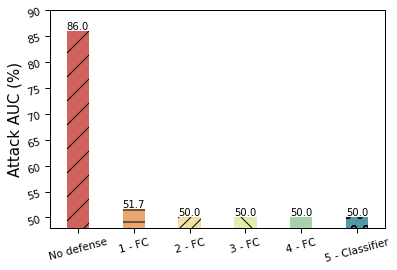

Columns to aggregate
['server_attack']
[50.006364832180594]
Columns to aggregate
['server_attack']
[50.07849959689396]
Columns to aggregate
['server_attack']
[50.006364832180594]
Columns to aggregate
['server_attack']
[50.006364832180594]
Columns to aggregate
['server_attack']
[50.006364832180594]
Columns to aggregate
['server_attack']
[50.006364832180594]
[0.06863916573789239, 0.052176097590493506, 7.105427357601002e-15, 7.105427357601002e-15, 7.105427357601002e-15, 7.105427357601002e-15]
Labels
['No defense', '1 - FC', '2 - FC', '3 - FC', '4 - FC', '5 - Classifier']
[50.01, 50.08, 50.01, 50.01, 50.01, 50.01]
None


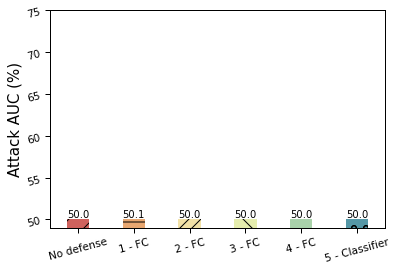

Columns to aggregate
['client_accuracy_8', 'client_accuracy_5', 'client_accuracy_3', 'client_accuracy_4', 'client_accuracy_2', 'client_accuracy_0', 'client_accuracy_6', 'client_accuracy_1', 'client_accuracy_7', 'client_accuracy_9']
[48.48536274925753, 47.254985150615184, 47.22104369961816, 47.33983877810776, 46.60161221892236, 47.50106067034366, 47.05982180738227, 47.984726347051335, 47.81501909206619, 47.50106067034366]
Columns to aggregate
['client_accuracy_8', 'client_accuracy_5', 'client_accuracy_3', 'client_accuracy_4', 'client_accuracy_2', 'client_accuracy_0', 'client_accuracy_6', 'client_accuracy_1', 'client_accuracy_7', 'client_accuracy_9']
[46.16885871871023, 46.21128553245652, 45.6936784047518, 46.24522698345354, 45.62579550275775, 46.2537123462028, 45.88884174798473, 47.54348748408994, 46.15188799321171, 46.48281714043275]
Columns to aggregate
['client_accuracy_8', 'client_accuracy_5', 'client_accuracy_3', 'client_accuracy_4', 'client_accuracy_2', 'client_accuracy_0', 'clien

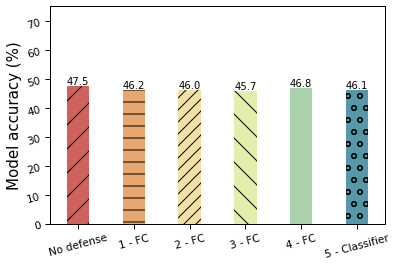

Columns to aggregate
['client_accuracy_8', 'client_accuracy_5', 'client_accuracy_3', 'client_accuracy_4', 'client_accuracy_2', 'client_accuracy_0', 'client_accuracy_6', 'client_accuracy_1', 'client_accuracy_7', 'client_accuracy_9']
[48.48536274925753, 47.254985150615184, 47.22104369961816, 47.33983877810776, 46.60161221892236, 47.50106067034366, 47.05982180738227, 47.984726347051335, 47.81501909206619, 47.50106067034366]
Columns to aggregate
['client_auc_8', 'client_auc_5', 'client_auc_3', 'client_auc_4', 'client_auc_2', 'client_auc_0', 'client_auc_6', 'client_auc_1', 'client_auc_7', 'client_auc_9']
[84.3220338983051, 88.55932203389831, 85.59322033898304, 88.98305084745763, 86.01694915254237, 86.01694915254238, 81.77966101694915, 87.71186440677967, 87.28813559322035, 83.47457627118644]
Columns to aggregate
['client_accuracy_8', 'client_accuracy_5', 'client_accuracy_3', 'client_accuracy_4', 'client_accuracy_2', 'client_accuracy_0', 'client_accuracy_6', 'client_accuracy_1', 'client_accur

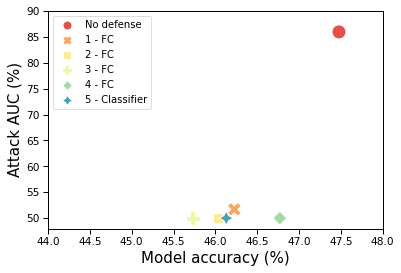

Columns to aggregate
['client_accuracy_8', 'client_accuracy_5', 'client_accuracy_3', 'client_accuracy_4', 'client_accuracy_2', 'client_accuracy_0', 'client_accuracy_6', 'client_accuracy_1', 'client_accuracy_7', 'client_accuracy_9']
[48.48536274925753, 47.254985150615184, 47.22104369961816, 47.33983877810776, 46.60161221892236, 47.50106067034366, 47.05982180738227, 47.984726347051335, 47.81501909206619, 47.50106067034366]
Columns to aggregate
['server_attack']
[50.006364832180594]
Columns to aggregate
['client_accuracy_8', 'client_accuracy_5', 'client_accuracy_3', 'client_accuracy_4', 'client_accuracy_2', 'client_accuracy_0', 'client_accuracy_6', 'client_accuracy_1', 'client_accuracy_7', 'client_accuracy_9']
[46.16885871871023, 46.21128553245652, 45.6936784047518, 46.24522698345354, 45.62579550275775, 46.2537123462028, 45.88884174798473, 47.54348748408994, 46.15188799321171, 46.48281714043275]
Columns to aggregate
['server_attack']
[50.07849959689396]
Columns to aggregate
['client_accur

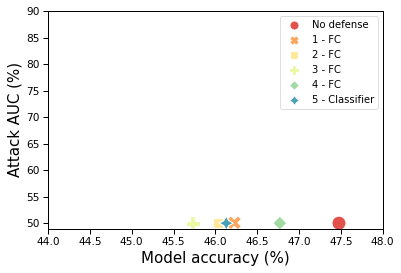

No defense
200
1 - FC
200
2 - FC
200
3 - FC
200
4 - FC
200
5 - Classifier
200


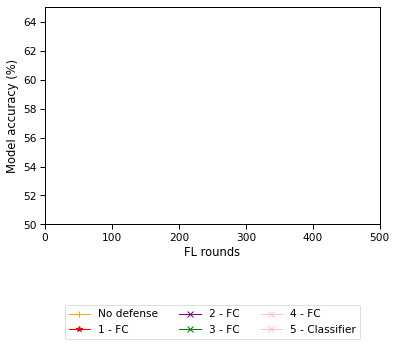

No defense
200
1 - FC
200
2 - FC
200
3 - FC
200
4 - FC
200
5 - Classifier
200


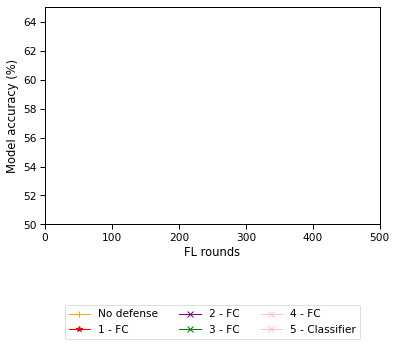

No defense
200
1 - FC
200
2 - FC
200
3 - FC
200
4 - FC
200
5 - Classifier
200


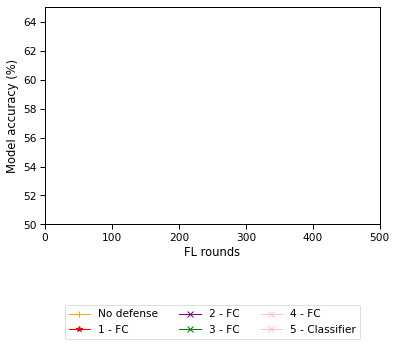

No defense
200
1 - FC
200
2 - FC
200
3 - FC
200
4 - FC
200
5 - Classifier
200


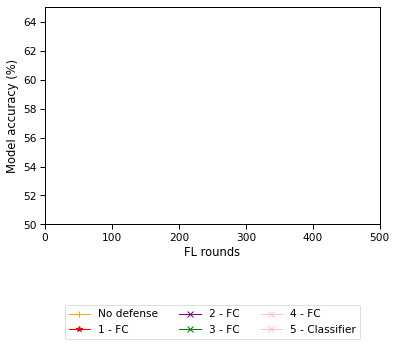

No defense
200
1 - FC
200
2 - FC
200
3 - FC
200
4 - FC
200
5 - Classifier
200


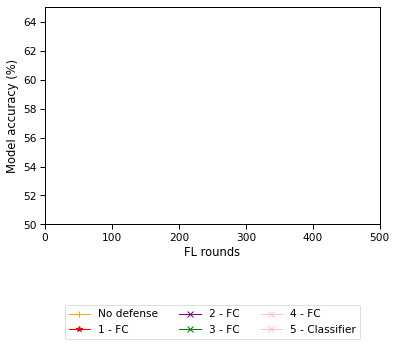

No defense
200
1 - FC
200
2 - FC
200
3 - FC
200
4 - FC
200
5 - Classifier
200


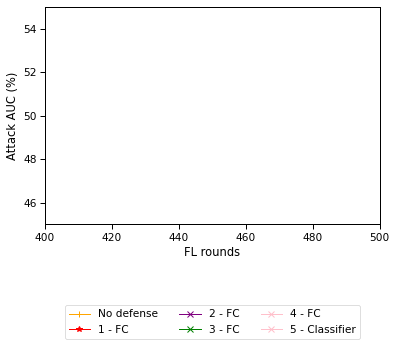

No defense
200
1 - FC
200
2 - FC
200
3 - FC
200
4 - FC
200
5 - Classifier
200


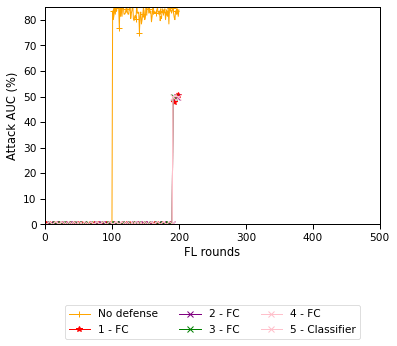

No defense
200
1 - FC
200
2 - FC
200
3 - FC
200
4 - FC
200
5 - Classifier
200


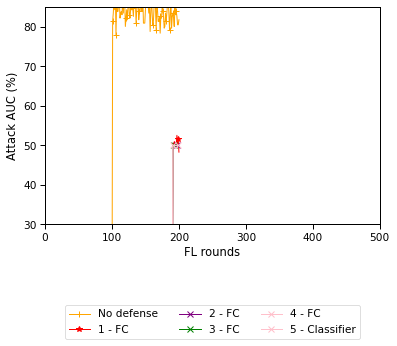

No defense
200
1 - FC
200
2 - FC
200
3 - FC
200
4 - FC
200
5 - Classifier
200


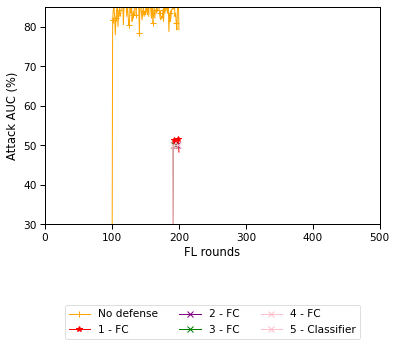

No defense
200
1 - FC
200
2 - FC
200
3 - FC
200
4 - FC
200
5 - Classifier
200


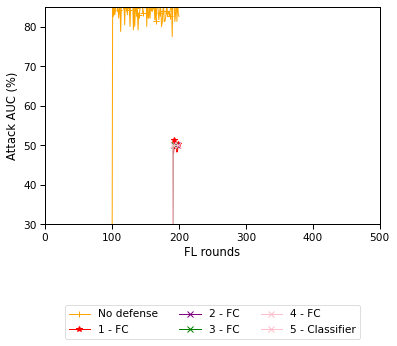

No defense
200
1 - FC
200
2 - FC
200
3 - FC
200
4 - FC
200
5 - Classifier
200


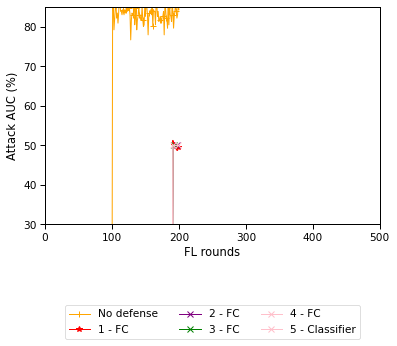

In [178]:
r = 200

generate_histogram(plot_config, "local_model_attack_accuracy_hist", "Attack AUC (%)", "client_auc", 48, 90, average=True, label_rotation=15, std = None)
generate_histogram(plot_config, "global_model_attack_accuracy_hist", "Attack AUC (%)", "server_attack", 49, 75, average=True, label_rotation=15, std = None)
#generate_xy_plot(plot_config, 'local_models_attack_accuracy', 'Attack AUC (%)', 'client_auc', 0, 100, average=True)
#generate_xy_plot(plot_config, 'global_model_attack_accuracy', 'Attack AUC (%)', 'server_attack', 0, 100, average=True)
#generate_xy_plot(plot_config, 'local_models_accuracy', 'Model accuracy (%)', 'client_accuracy', 0, 100, average=True)
generate_histogram(plot_config, "local_models_accuracy_hist", "Model accuracy (%)", "client_accuracy", 0, 75, average=True, label_rotation=15)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy', 'client_auc', 48, 90, 44, 48, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_server', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy', 'server_attack', 49, 90, 44, 48, average=True)

generate_xy_plot(plot_config, 'local_model0_accuracy', 'Model accuracy (%)', 'client_accuracy_0', 50, 65, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model1_accuracy', 'Model accuracy (%)', 'client_accuracy_1', 50, 65, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model2_accuracy', 'Model accuracy (%)', 'client_accuracy_2', 50, 65, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model3_accuracy', 'Model accuracy (%)', 'client_accuracy_3', 50, 65, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model4_accuracy', 'Model accuracy (%)', 'client_accuracy_4', 50, 65, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)

generate_xy_plot(plot_config, 'server_auc', 'Attack AUC (%)', 'server_auc', 45, 55, min_x=400, max_x = 500, average=True, extension='.png', max_range=r)

generate_xy_plot(plot_config, 'local_model0_auc', 'Attack AUC (%)', 'client_auc_0', 0, 85, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model1_auc', 'Attack AUC (%)', 'client_auc_1', 30, 85, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model2_auc', 'Attack AUC (%)', 'client_auc_2', 30, 85, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model3_auc', 'Attack AUC (%)', 'client_auc_3', 30, 85, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model4_auc', 'Attack AUC (%)', 'client_auc_4', 30, 85, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)

### Layers Analysis Texas 2 Layers PASTEL

In [112]:
plot_config = {
                "dataset_name": "texas_2_layers_adagrad_layer_analysis",
                "dataset_pretty_name" : "CelebA_ResNet",

                "data":[

                        {
                            "exp_name" : "No defense",
                            "file_path": "ppm_baseline_texas_2_layers_.csv",
                            "color": "orange",
                            "symbol" : "+"
                        },

                     {
                            "exp_name" : "1 - FC",
                            "file_path": "ppm_pastel_texas_2_layers_features0_adagrad.csv",
                            "color": "red",
                            "symbol" : "*"
                        },
                                               
                                                {
                            "exp_name" : "2 - FC",
                            "file_path": "ppm_pastel_texas_2_layers_features2_adagrad.csv",
                            "color": "purple",
                            "symbol" : "x"
                        },
                                                              {
                            "exp_name" : "3 - Classifier",
                            "file_path": "ppm_pastel_texas_2_layers_classifier_adagrad.csv",
                            "color": "green",
                            "symbol" : "x"
                        }
                            
                    ]
                }

Columns to aggregate
['client_auc_8', 'client_auc_5', 'client_auc_3', 'client_auc_4', 'client_auc_2', 'client_auc_0', 'client_auc_6', 'client_auc_1', 'client_auc_7', 'client_auc_9']
[76.69491525423729, 77.96610169491525, 77.54237288135593, 77.96610169491525, 82.20338983050848, 80.5084745762712, 76.27118644067797, 80.08474576271186, 77.96610169491525, 73.72881355932203]
Columns to aggregate
['client_auc_8', 'client_auc_5', 'client_auc_3', 'client_auc_4', 'client_auc_2', 'client_auc_0', 'client_auc_6', 'client_auc_1', 'client_auc_7', 'client_auc_9']
[51.271186440677965, 54.66101694915254, 52.54237288135594, 52.96610169491526, 51.694915254237294, 52.118644067796616, 55.50847457627118, 52.966101694915245, 54.23728813559322, 53.38983050847458]
Columns to aggregate
['client_auc_8', 'client_auc_5', 'client_auc_3', 'client_auc_4', 'client_auc_2', 'client_auc_0', 'client_auc_6', 'client_auc_1', 'client_auc_7', 'client_auc_9']
[50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0]
Columns 

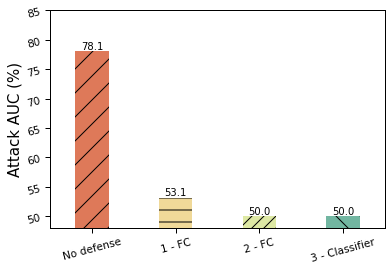

Columns to aggregate
['server_attack']
[58.62859082615521]
Columns to aggregate
['server_attack']
[50.32036321975644]
Columns to aggregate
['server_attack']
[50.006364832180594]
Columns to aggregate
['server_attack']
[50.006364832180594]
[0.08151956199729174, 0.12091692201829965, 7.105427357601002e-15, 7.105427357601002e-15]
Labels
['No defense', '1 - FC', '2 - FC', '3 - Classifier']
[58.63, 50.32, 50.01, 50.01]
None


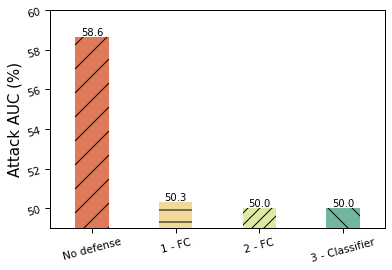

Columns to aggregate
['client_accuracy_8', 'client_accuracy_5', 'client_accuracy_3', 'client_accuracy_4', 'client_accuracy_2', 'client_accuracy_0', 'client_accuracy_6', 'client_accuracy_1', 'client_accuracy_7', 'client_accuracy_9']
[49.783623249893935, 49.121764955451845, 48.358082308018666, 48.58718710224862, 48.816291896478575, 49.35935511243106, 49.16419176919813, 49.00296987696224, 49.35935511243106, 49.37632583792957]
Columns to aggregate
['client_accuracy_8', 'client_accuracy_5', 'client_accuracy_3', 'client_accuracy_4', 'client_accuracy_2', 'client_accuracy_0', 'client_accuracy_6', 'client_accuracy_1', 'client_accuracy_7', 'client_accuracy_9']
[49.65634280865507, 49.76665252439542, 49.65634280865507, 49.843020789138734, 49.299957573186255, 49.62240135765804, 49.80907933814171, 50.16546457361052, 49.9703012303776, 50.07212558336869]
Columns to aggregate
['client_accuracy_8', 'client_accuracy_5', 'client_accuracy_3', 'client_accuracy_4', 'client_accuracy_2', 'client_accuracy_0', '

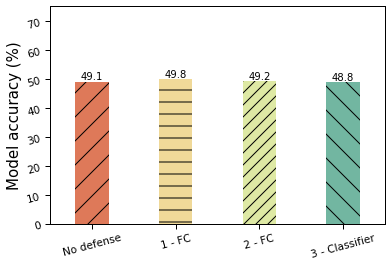

Columns to aggregate
['client_accuracy_8', 'client_accuracy_5', 'client_accuracy_3', 'client_accuracy_4', 'client_accuracy_2', 'client_accuracy_0', 'client_accuracy_6', 'client_accuracy_1', 'client_accuracy_7', 'client_accuracy_9']
[49.783623249893935, 49.121764955451845, 48.358082308018666, 48.58718710224862, 48.816291896478575, 49.35935511243106, 49.16419176919813, 49.00296987696224, 49.35935511243106, 49.37632583792957]
Columns to aggregate
['client_auc_8', 'client_auc_5', 'client_auc_3', 'client_auc_4', 'client_auc_2', 'client_auc_0', 'client_auc_6', 'client_auc_1', 'client_auc_7', 'client_auc_9']
[76.69491525423729, 77.96610169491525, 77.54237288135593, 77.96610169491525, 82.20338983050848, 80.5084745762712, 76.27118644067797, 80.08474576271186, 77.96610169491525, 73.72881355932203]
Columns to aggregate
['client_accuracy_8', 'client_accuracy_5', 'client_accuracy_3', 'client_accuracy_4', 'client_accuracy_2', 'client_accuracy_0', 'client_accuracy_6', 'client_accuracy_1', 'client_acc

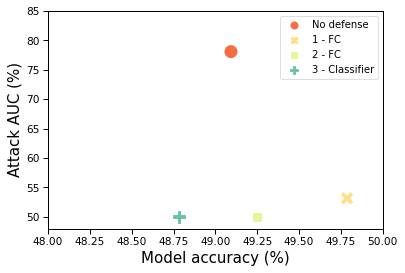

Columns to aggregate
['client_accuracy_8', 'client_accuracy_5', 'client_accuracy_3', 'client_accuracy_4', 'client_accuracy_2', 'client_accuracy_0', 'client_accuracy_6', 'client_accuracy_1', 'client_accuracy_7', 'client_accuracy_9']
[49.783623249893935, 49.121764955451845, 48.358082308018666, 48.58718710224862, 48.816291896478575, 49.35935511243106, 49.16419176919813, 49.00296987696224, 49.35935511243106, 49.37632583792957]
Columns to aggregate
['server_attack']
[58.62859082615521]
Columns to aggregate
['client_accuracy_8', 'client_accuracy_5', 'client_accuracy_3', 'client_accuracy_4', 'client_accuracy_2', 'client_accuracy_0', 'client_accuracy_6', 'client_accuracy_1', 'client_accuracy_7', 'client_accuracy_9']
[49.65634280865507, 49.76665252439542, 49.65634280865507, 49.843020789138734, 49.299957573186255, 49.62240135765804, 49.80907933814171, 50.16546457361052, 49.9703012303776, 50.07212558336869]
Columns to aggregate
['server_attack']
[50.32036321975644]
Columns to aggregate
['client_a

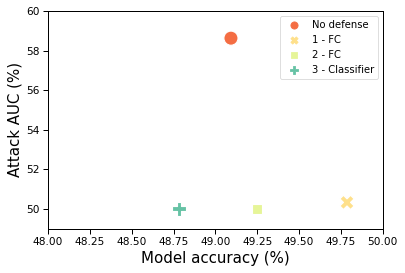

No defense
200
1 - FC
200
2 - FC
200
3 - Classifier
200


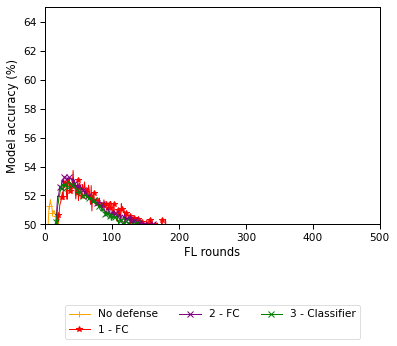

No defense
200
1 - FC
200
2 - FC
200
3 - Classifier
200


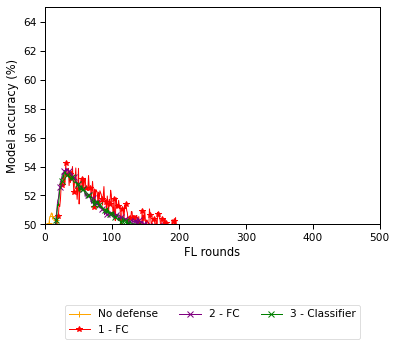

No defense
200
1 - FC
200
2 - FC
200
3 - Classifier
200


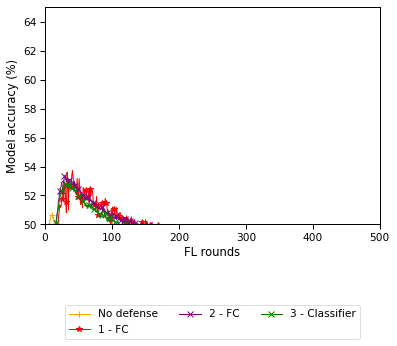

No defense
200
1 - FC
200
2 - FC
200
3 - Classifier
200


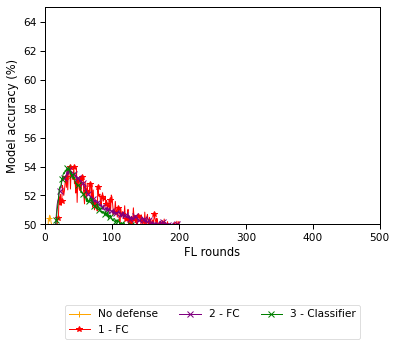

No defense
200
1 - FC
200
2 - FC
200
3 - Classifier
200


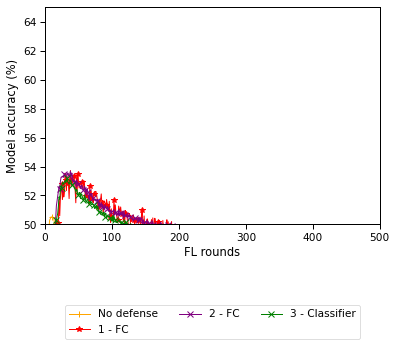

No defense
200
1 - FC
200
2 - FC
200
3 - Classifier
200


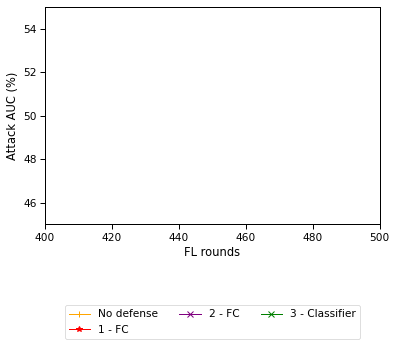

No defense
200
1 - FC
200
2 - FC
200
3 - Classifier
200


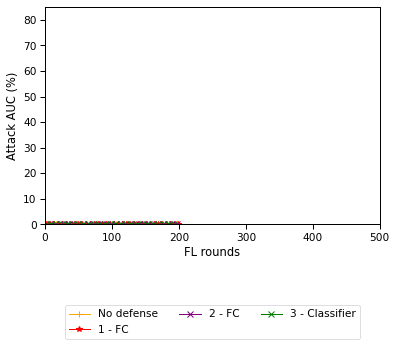

No defense
200
1 - FC
200
2 - FC
200
3 - Classifier
200


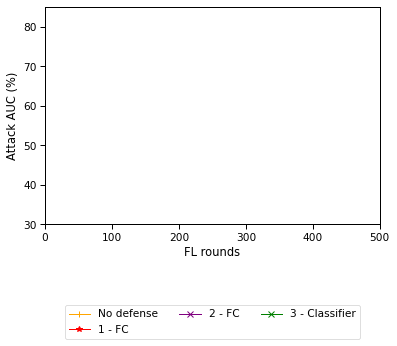

No defense
200
1 - FC
200
2 - FC
200
3 - Classifier
200


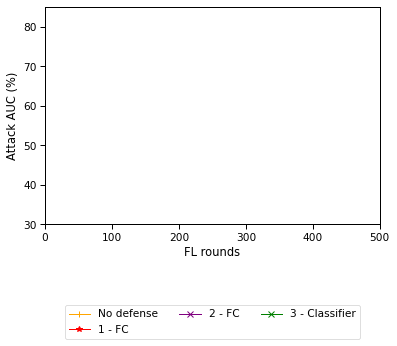

No defense
200
1 - FC
200
2 - FC
200
3 - Classifier
200


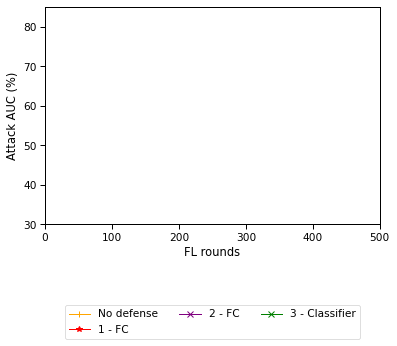

No defense
200
1 - FC
200
2 - FC
200
3 - Classifier
200


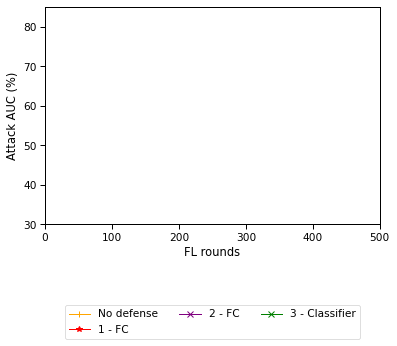

In [119]:
r = 200

generate_histogram(plot_config, "local_model_attack_accuracy_hist", "Attack AUC (%)", "client_auc", 48, 85, average=True, label_rotation=15, std = None)
generate_histogram(plot_config, "global_model_attack_accuracy_hist", "Attack AUC (%)", "server_attack", 49, 60, average=True, label_rotation=15, std = None)
#generate_xy_plot(plot_config, 'local_models_attack_accuracy', 'Attack AUC (%)', 'client_auc', 0, 100, average=True)
#generate_xy_plot(plot_config, 'global_model_attack_accuracy', 'Attack AUC (%)', 'server_attack', 0, 100, average=True)
#generate_xy_plot(plot_config, 'local_models_accuracy', 'Model accuracy (%)', 'client_accuracy', 0, 100, average=True)
generate_histogram(plot_config, "local_models_accuracy_hist", "Model accuracy (%)", "client_accuracy", 0, 75, average=True, label_rotation=15)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy', 'client_auc', 48, 85, 48, 50, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_server', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy', 'server_attack', 49, 60, 48, 50, average=True)

generate_xy_plot(plot_config, 'local_model0_accuracy', 'Model accuracy (%)', 'client_accuracy_0', 50, 65, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model1_accuracy', 'Model accuracy (%)', 'client_accuracy_1', 50, 65, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model2_accuracy', 'Model accuracy (%)', 'client_accuracy_2', 50, 65, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model3_accuracy', 'Model accuracy (%)', 'client_accuracy_3', 50, 65, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model4_accuracy', 'Model accuracy (%)', 'client_accuracy_4', 50, 65, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)

generate_xy_plot(plot_config, 'server_auc', 'Attack AUC (%)', 'server_auc', 45, 55, min_x=400, max_x = 500, average=True, extension='.png', max_range=r)

generate_xy_plot(plot_config, 'local_model0_auc', 'Attack AUC (%)', 'client_auc_0', 0, 85, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model1_auc', 'Attack AUC (%)', 'client_auc_1', 30, 85, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model2_auc', 'Attack AUC (%)', 'client_auc_2', 30, 85, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model3_auc', 'Attack AUC (%)', 'client_auc_3', 30, 85, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model4_auc', 'Attack AUC (%)', 'client_auc_4', 30, 85, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)

### Layers Analysis Texas 6 Layers PASTEL

In [193]:
plot_config = {
                "dataset_name": "texas_6_layers_adagrad_layer_analysis",
                "dataset_pretty_name" : "CelebA_ResNet",

                "data":[

                        {
                            "exp_name" : "No defense",
                            "file_path": "ppm_baseline_texas_6_layers.csv",
                            "color": "orange",
                            "symbol" : "+"
                        },

                     {
                            "exp_name" : "1 - FC",
                            "file_path": "ppm_pastel_texas_6_layers_features0_adagrad.csv",
                            "color": "red",
                            "symbol" : "*"
                        },
                                               
                                                {
                            "exp_name" : "2 - FC",
                            "file_path": "ppm_pastel_texas_6_layers_features2_adagrad.csv",
                            "color": "purple",
                            "symbol" : "x"
                        },
                                                              {
                            "exp_name" : "3 - FC",
                            "file_path": "ppm_pastel_texas_6_layers_features4_adagrad.csv",
                            "color": "green",
                            "symbol" : "x"
                        },
                                                                                                      {
                            "exp_name" : "4 - FC",
                            "file_path": "ppm_pastel_texas_6_layers_features6_adagrad.csv",
                            "color": "pink",
                            "symbol" : "x"
                                                                                                      },
                             {
                            "exp_name" : "5 - FC",
                            "file_path": "ppm_pastel_texas_6_layers_features8_adagrad.csv",
                            "color": "pink",
                            "symbol" : "x"
                                                                                                      },
                    {
                                "exp_name" : "6 - FC",
                            "file_path": "ppm_pastel_texas_6_layers_features10_adagrad.csv",
                            "color": "pink",
                            "symbol" : "x"
                                                                                                      },
                     {
                                "exp_name" : "7 - Classifier",
                            "file_path": "ppm_pastel_texas_6_layers_classifier_adagrad.csv",
                            "color": "pink",
                            "symbol" : "x"
                                                                                                      } 
                            
                    ]
                }

Columns to aggregate
['client_auc_8', 'client_auc_5', 'client_auc_3', 'client_auc_4', 'client_auc_2', 'client_auc_0', 'client_auc_6', 'client_auc_1', 'client_auc_7', 'client_auc_9']
[75.42372881355932, 77.54237288135593, 77.54237288135594, 77.54237288135593, 79.66101694915254, 76.69491525423729, 75.84745762711864, 76.27118644067797, 77.54237288135593, 73.72881355932203]
Columns to aggregate
['client_auc_8', 'client_auc_5', 'client_auc_3', 'client_auc_4', 'client_auc_2', 'client_auc_0', 'client_auc_6', 'client_auc_1', 'client_auc_7', 'client_auc_9']
[52.118644067796616, 52.54237288135594, 51.271186440677965, 51.694915254237294, 52.54237288135594, 52.1186440677966, 52.54237288135594, 52.54237288135592, 51.694915254237294, 50.84745762711864]
Columns to aggregate
['client_auc_8', 'client_auc_5', 'client_auc_3', 'client_auc_4', 'client_auc_2', 'client_auc_0', 'client_auc_6', 'client_auc_1', 'client_auc_7', 'client_auc_9']
[50.84745762711864, 50.0, 52.118644067796616, 50.42372881355932, 50.4

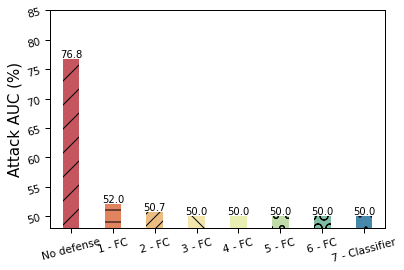

Columns to aggregate
['server_attack']
[62.20562651164764]
Columns to aggregate
['server_attack']
[50.1463911401536]
Columns to aggregate
['server_attack']
[50.08698603980142]
Columns to aggregate
['server_attack']
[50.006364832180594]
Columns to aggregate
['server_attack']
[50.01485127508805]
Columns to aggregate
['server_attack']
[50.006364832180594]
Columns to aggregate
['server_attack']
[50.006364832180594]
Columns to aggregate
['server_attack']
[50.006364832180594]
[0.22684414285152416, 0.06806238317668334, 0.03832077703526263, 0.0012729664361181394, 0.0036991547023720625, 7.105427357601002e-15, 7.105427357601002e-15, 7.105427357601002e-15]
Labels
['No defense', '1 - FC', '2 - FC', '3 - FC', '4 - FC', '5 - FC', '6 - FC', '7 - Classifier']
[62.21, 50.15, 50.09, 50.01, 50.01, 50.01, 50.01, 50.01]
None


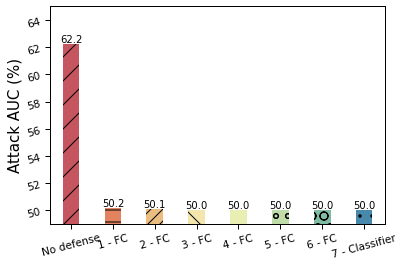

Columns to aggregate
['client_accuracy_8', 'client_accuracy_5', 'client_accuracy_3', 'client_accuracy_4', 'client_accuracy_2', 'client_accuracy_0', 'client_accuracy_6', 'client_accuracy_1', 'client_accuracy_7', 'client_accuracy_9']
[42.98684768773865, 42.86805260924905, 42.32498939329656, 42.952906236741626, 42.18922358930845, 42.89350869749682, 42.223165040305474, 43.24140857021638, 42.486211285532455, 42.58803563852355]
Columns to aggregate
['client_accuracy_8', 'client_accuracy_5', 'client_accuracy_3', 'client_accuracy_4', 'client_accuracy_2', 'client_accuracy_0', 'client_accuracy_6', 'client_accuracy_1', 'client_accuracy_7', 'client_accuracy_9']
[45.21001272804413, 44.77725922783199, 44.20873992363173, 44.92999575731862, 44.13237165888842, 44.65846414934239, 44.58209588459906, 44.70089096308868, 44.9554518455664, 45.0148493848112]
Columns to aggregate
['client_accuracy_8', 'client_accuracy_5', 'client_accuracy_3', 'client_accuracy_4', 'client_accuracy_2', 'client_accuracy_0', 'clie

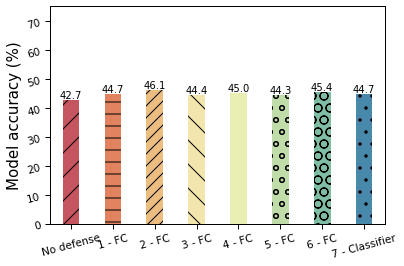

Columns to aggregate
['client_accuracy_8', 'client_accuracy_5', 'client_accuracy_3', 'client_accuracy_4', 'client_accuracy_2', 'client_accuracy_0', 'client_accuracy_6', 'client_accuracy_1', 'client_accuracy_7', 'client_accuracy_9']
[42.98684768773865, 42.86805260924905, 42.32498939329656, 42.952906236741626, 42.18922358930845, 42.89350869749682, 42.223165040305474, 43.24140857021638, 42.486211285532455, 42.58803563852355]
Columns to aggregate
['client_auc_8', 'client_auc_5', 'client_auc_3', 'client_auc_4', 'client_auc_2', 'client_auc_0', 'client_auc_6', 'client_auc_1', 'client_auc_7', 'client_auc_9']
[75.42372881355932, 77.54237288135593, 77.54237288135594, 77.54237288135593, 79.66101694915254, 76.69491525423729, 75.84745762711864, 76.27118644067797, 77.54237288135593, 73.72881355932203]
Columns to aggregate
['client_accuracy_8', 'client_accuracy_5', 'client_accuracy_3', 'client_accuracy_4', 'client_accuracy_2', 'client_accuracy_0', 'client_accuracy_6', 'client_accuracy_1', 'client_acc

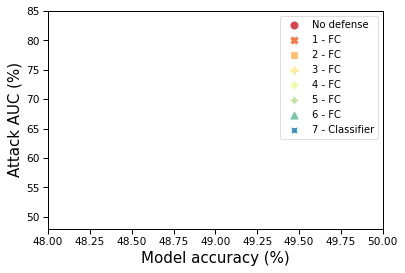

Columns to aggregate
['client_accuracy_8', 'client_accuracy_5', 'client_accuracy_3', 'client_accuracy_4', 'client_accuracy_2', 'client_accuracy_0', 'client_accuracy_6', 'client_accuracy_1', 'client_accuracy_7', 'client_accuracy_9']
[42.98684768773865, 42.86805260924905, 42.32498939329656, 42.952906236741626, 42.18922358930845, 42.89350869749682, 42.223165040305474, 43.24140857021638, 42.486211285532455, 42.58803563852355]
Columns to aggregate
['server_attack']
[62.20562651164764]
Columns to aggregate
['client_accuracy_8', 'client_accuracy_5', 'client_accuracy_3', 'client_accuracy_4', 'client_accuracy_2', 'client_accuracy_0', 'client_accuracy_6', 'client_accuracy_1', 'client_accuracy_7', 'client_accuracy_9']
[45.21001272804413, 44.77725922783199, 44.20873992363173, 44.92999575731862, 44.13237165888842, 44.65846414934239, 44.58209588459906, 44.70089096308868, 44.9554518455664, 45.0148493848112]
Columns to aggregate
['server_attack']
[50.1463911401536]
Columns to aggregate
['client_accura

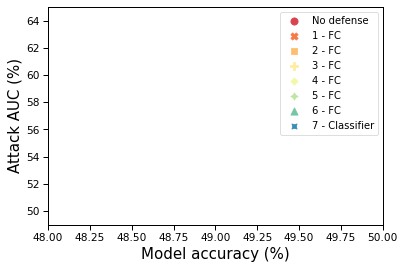

No defense
200
1 - FC
200
2 - FC
200
3 - FC
200
4 - FC
200
5 - FC
200
6 - FC
200
7 - Classifier
200


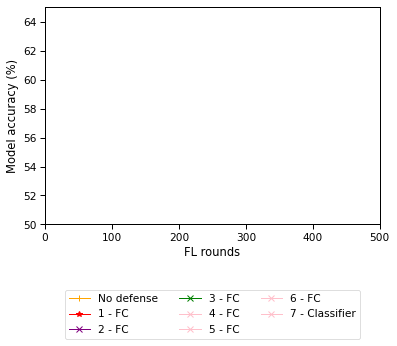

No defense
200
1 - FC
200
2 - FC
200
3 - FC
200
4 - FC
200
5 - FC
200
6 - FC
200
7 - Classifier
200


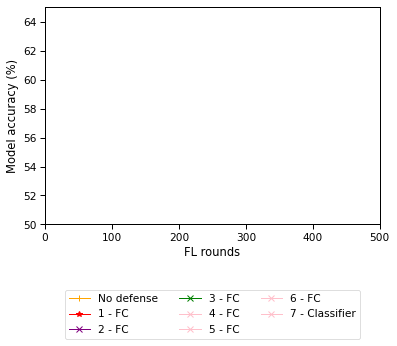

No defense
200
1 - FC
200
2 - FC
200
3 - FC
200
4 - FC
200
5 - FC
200
6 - FC
200
7 - Classifier
200


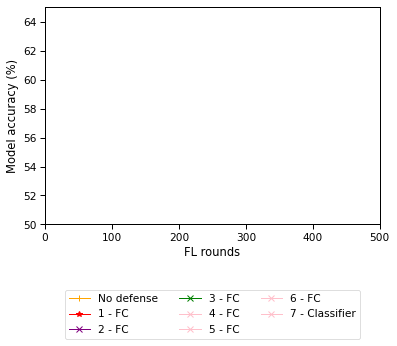

No defense
200
1 - FC
200
2 - FC
200
3 - FC
200
4 - FC
200
5 - FC
200
6 - FC
200
7 - Classifier
200


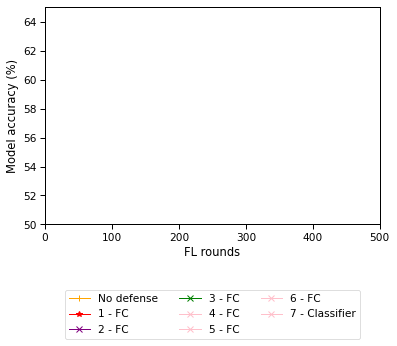

No defense
200
1 - FC
200
2 - FC
200
3 - FC
200
4 - FC
200
5 - FC
200
6 - FC
200
7 - Classifier
200


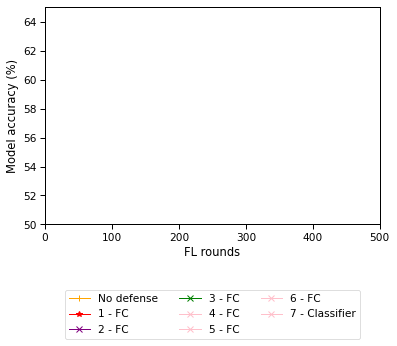

No defense
200
1 - FC
200
2 - FC
200
3 - FC
200
4 - FC
200
5 - FC
200
6 - FC
200
7 - Classifier
200


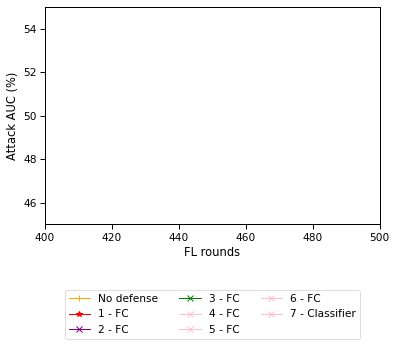

No defense
200
1 - FC
200
2 - FC
200
3 - FC
200
4 - FC
200
5 - FC
200
6 - FC
200
7 - Classifier
200


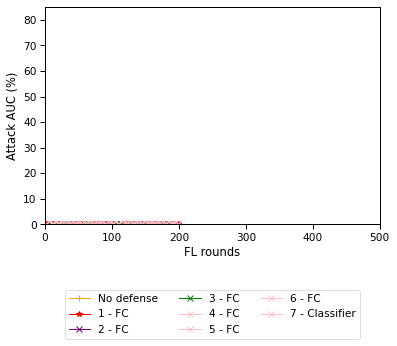

No defense
200
1 - FC
200
2 - FC
200
3 - FC
200
4 - FC
200
5 - FC
200
6 - FC
200
7 - Classifier
200


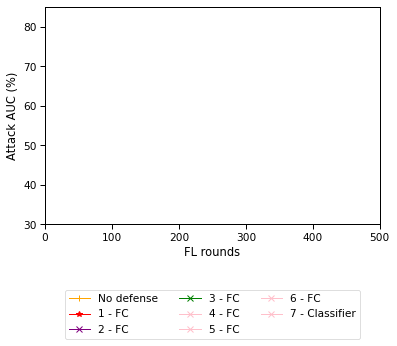

No defense
200
1 - FC
200
2 - FC
200
3 - FC
200
4 - FC
200
5 - FC
200
6 - FC
200
7 - Classifier
200


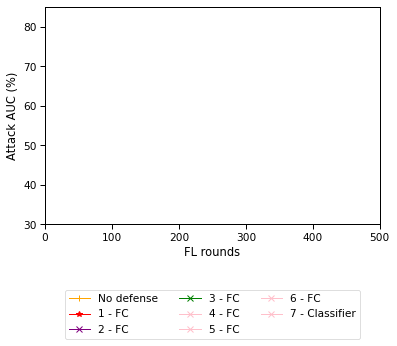

No defense
200
1 - FC
200
2 - FC
200
3 - FC
200
4 - FC
200
5 - FC
200
6 - FC
200
7 - Classifier
200


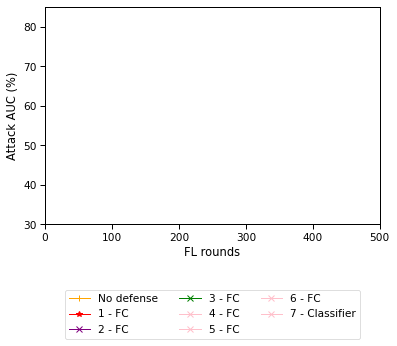

No defense
200
1 - FC
200
2 - FC
200
3 - FC
200
4 - FC
200
5 - FC
200
6 - FC
200
7 - Classifier
200


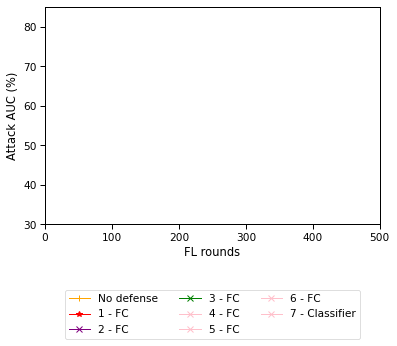

In [195]:
r = 200

generate_histogram(plot_config, "local_model_attack_accuracy_hist", "Attack AUC (%)", "client_auc", 48, 85, average=True, label_rotation=15, std = None)
generate_histogram(plot_config, "global_model_attack_accuracy_hist", "Attack AUC (%)", "server_attack", 49, 65, average=True, label_rotation=15, std = None)
#generate_xy_plot(plot_config, 'local_models_attack_accuracy', 'Attack AUC (%)', 'client_auc', 0, 100, average=True)
#generate_xy_plot(plot_config, 'global_model_attack_accuracy', 'Attack AUC (%)', 'server_attack', 0, 100, average=True)
#generate_xy_plot(plot_config, 'local_models_accuracy', 'Model accuracy (%)', 'client_accuracy', 0, 100, average=True)
generate_histogram(plot_config, "local_models_accuracy_hist", "Model accuracy (%)", "client_accuracy", 0, 75, average=True, label_rotation=15)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy', 'client_auc', 48, 85, 48, 50, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_server', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy', 'server_attack', 49, 65, 48, 50, average=True)

generate_xy_plot(plot_config, 'local_model0_accuracy', 'Model accuracy (%)', 'client_accuracy_0', 50, 65, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model1_accuracy', 'Model accuracy (%)', 'client_accuracy_1', 50, 65, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model2_accuracy', 'Model accuracy (%)', 'client_accuracy_2', 50, 65, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model3_accuracy', 'Model accuracy (%)', 'client_accuracy_3', 50, 65, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model4_accuracy', 'Model accuracy (%)', 'client_accuracy_4', 50, 65, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)

generate_xy_plot(plot_config, 'server_auc', 'Attack AUC (%)', 'server_auc', 45, 55, min_x=400, max_x = 500, average=True, extension='.png', max_range=r)

generate_xy_plot(plot_config, 'local_model0_auc', 'Attack AUC (%)', 'client_auc_0', 0, 85, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model1_auc', 'Attack AUC (%)', 'client_auc_1', 30, 85, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model2_auc', 'Attack AUC (%)', 'client_auc_2', 30, 85, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model3_auc', 'Attack AUC (%)', 'client_auc_3', 30, 85, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model4_auc', 'Attack AUC (%)', 'client_auc_4', 30, 85, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)

### Layers analysis Celeba VGG

In [161]:
plot_config = {
                "dataset_name": "celeba_vgg_layer_analysis",
                "dataset_pretty_name" : "CelebA_ResNet",

                "data":[

                        {
                            "exp_name" : "No defense",
                            "file_path": "ppm_baseline_celeba_vgg.csv",
                            "color": "orange",
                            "symbol" : "+"
                        },
                          {
                            "exp_name" : "1 - C",
                            "file_path": "ppm_pastel_conv_true_adagrad_celeba_vgg.csv",
                            "color": "red",
                            "symbol" : "*"
                        },
                                                            

                    
                     {
                            "exp_name" : "1 - BN",
                            "file_path": "ppm_pastel_bn1_true_adagrad_celeba_vgg.csv",
                            "color": "red",
                            "symbol" : "*"
                        },
                                                                    {
                            "exp_name" : "2 - C",
                            "file_path": "ppm_pastel_conv2_true__adagrad_celeba_vgg.csv",
                            "color": "purple",
                            "symbol" : "x"
                        },
                                               
                                                {
                            "exp_name" : "2 - BN",
                            "file_path": "ppm_pastel_bn2_true__adagrad_celeba_vgg.csv",
                            "color": "purple",
                            "symbol" : "x"
                        },
                                                                                  {
                            "exp_name" : "3 - C",
                            "file_path": "ppm_pastel_conv3_true_adagrad_celeba_vgg.csv",
                            "color": "green",
                            "symbol" : "x"
                        },
                                                              {
                            "exp_name" : "3 - BN",
                            "file_path": "ppm_pastel_bn3_true_adagrad_celeba_vgg.csv",
                            "color": "green",
                            "symbol" : "x"
                        },
                    
                                                                                                      {
                            "exp_name" : "4 - C",
                            "file_path": "ppm_pastel_conv4_true_adagrad_celeba_vgg.csv",
                            "color": "pink",
                            "symbol" : "x"
                        },
                                                                                                      {
                            "exp_name" : "4 - BN",
                            "file_path": "ppm_pastel_bn4_true_adagrad_celeba_vgg.csv",
                            "color": "pink",
                            "symbol" : "x"
                        },
                                                {
                            "exp_name" : "5 - C",
                            "file_path": "ppm_pastel_conv5_true_adagrad_celeba_vgg.csv",
                            "color": "yellow",
                            "symbol" : "x"
                        },
                            {
                            "exp_name" : "5 - BN",
                            "file_path": "ppm_pastel_bn5_true_adagrad_celeba_vgg.csv",
                            "color": "yellow",
                            "symbol" : "x"
                        },
                                                                   {
                            "exp_name" : "6 - C",
                            "file_path": "ppm_pastel_conv6_true_adagrad_celeba_vgg.csv",
                            "color": "green",
                            "symbol" : "x"
                        },
                                                {
                            "exp_name" : "6 - BN",
                            "file_path": "ppm_pastel_bn6_true_adagrad_celeba_vgg.csv",
                            "color": "green",
                            "symbol" : "x"
                        },
                     
                                           {
                            "exp_name" : "7 - C",
                            "file_path": "ppm_pastel_conv7_true_adagrad_celeba_vgg.csv",
                            "color": "grey",
                            "symbol" : "x"
                        },
                                           {
                            "exp_name" : "7 - BN",
                            "file_path": "ppm_pastel_bn7_true_adagrad_celeba_vgg.csv",
                            "color": "grey",
                            "symbol" : "x"
                        },
                                                                    {
                            "exp_name" : "8 - C",
                            "file_path": "ppm_pastel_conv8_true_adgrad_celeba_vgg.csv",
                            "color": "grey",
                            "symbol" : "x"
                                                },
                                                {
                            "exp_name" : "8 - BN",
                            "file_path": "ppm_pastel_bn8_true_adgrad_celeba_vgg.csv",
                            "color": "grey",
                            "symbol" : "x"
                                                },
                                                                    {
                            "exp_name" : "FC",
                            "file_path": "ppm_pastel_linear_true_adagrad_celeba_vgg.csv",
                            "color": "grey",
                            "symbol" : "x"
                                                }
                    
                    
                    ]
                }

Columns to aggregate
['client_auc_2', 'client_auc_0', 'client_auc_1', 'client_auc_4', 'client_auc_3']
[58.333333333333336, 57.00000000000001, 59.0, 55.00000000000001, 54.66666666666666]
Columns to aggregate
['client_auc_2', 'client_auc_0', 'client_auc_1', 'client_auc_4', 'client_auc_3']
[53.333333333333336, 56.66666666666668, 52.0, 53.0, 57.333333333333336]
Columns to aggregate
['client_auc_2', 'client_auc_0', 'client_auc_1', 'client_auc_4', 'client_auc_3']
[50.0, 50.0, 52.66666666666667, 50.33333333333333, 50.0]
Columns to aggregate
['client_auc_2', 'client_auc_0', 'client_auc_1', 'client_auc_4', 'client_auc_3']
[54.333333333333336, 51.66666666666666, 54.99999999999999, 53.333333333333336, 53.0]
Columns to aggregate
['client_auc_2', 'client_auc_0', 'client_auc_1', 'client_auc_4', 'client_auc_3']
[50.0, 50.0, 50.0, 50.0, 50.0]
Columns to aggregate
['client_auc_2', 'client_auc_0', 'client_auc_1', 'client_auc_4', 'client_auc_3']
[50.66666666666666, 50.0, 50.66666666666666, 53.33333333333

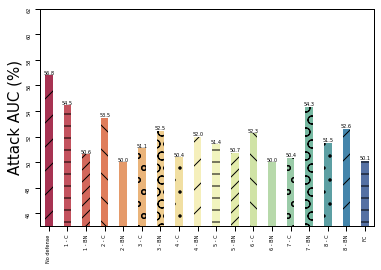

Columns to aggregate
['server_attack']
[60.88]
Columns to aggregate
['server_attack']
[50.306666666666665]
Columns to aggregate
['server_attack']
[50.10666666666667]
Columns to aggregate
['server_attack']
[50.2]
Columns to aggregate
['server_attack']
[50.0]
Columns to aggregate
['server_attack']
[50.31333333333333]
Columns to aggregate
['server_attack']
[50.34666666666666]
Columns to aggregate
['server_attack']
[50.34]
Columns to aggregate
['server_attack']
[50.44666666666666]
Columns to aggregate
['server_attack']
[50.0]
Columns to aggregate
['server_attack']
[50.866666666666674]
Columns to aggregate
['server_attack']
[50.0]
Columns to aggregate
['server_attack']
[50.0]
Columns to aggregate
['server_attack']
[49.97333333333333]
Columns to aggregate
['server_attack']
[51.1]
Columns to aggregate
['server_attack']
[50.02]
Columns to aggregate
['server_attack']
[51.126666666666665]
Columns to aggregate
['server_attack']
[50.00666666666667]
[0.331421852695994, 0.2501386282310935, 0.0320000

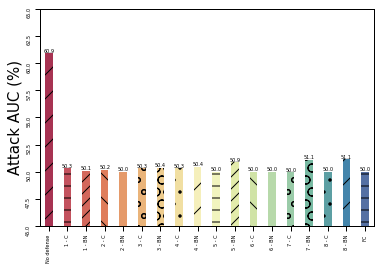

Columns to aggregate
['client_accuracy_2', 'client_accuracy_0', 'client_accuracy_1', 'client_accuracy_4', 'client_accuracy_3']
[71.88, 71.78666666666666, 72.01333333333334, 72.14666666666668, 71.49333333333333]
Columns to aggregate
['client_accuracy_2', 'client_accuracy_0', 'client_accuracy_1', 'client_accuracy_4', 'client_accuracy_3']
[73.32, 72.86666666666667, 72.88, 72.6, 72.61333333333333]
Columns to aggregate
['client_accuracy_2', 'client_accuracy_0', 'client_accuracy_1', 'client_accuracy_4', 'client_accuracy_3']
[72.0, 72.0, 72.34666666666666, 72.14666666666668, 72.29333333333334]
Columns to aggregate
['client_accuracy_2', 'client_accuracy_0', 'client_accuracy_1', 'client_accuracy_4', 'client_accuracy_3']
[73.0, 72.56, 72.41333333333333, 72.14666666666668, 72.52]
Columns to aggregate
['client_accuracy_2', 'client_accuracy_0', 'client_accuracy_1', 'client_accuracy_4', 'client_accuracy_3']
[72.18666666666667, 72.05333333333334, 71.97333333333333, 71.98666666666666, 72.2133333333333

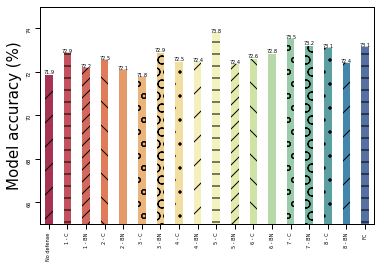

Columns to aggregate
['client_accuracy_2', 'client_accuracy_0', 'client_accuracy_1', 'client_accuracy_4', 'client_accuracy_3']
[71.88, 71.78666666666666, 72.01333333333334, 72.14666666666668, 71.49333333333333]
Columns to aggregate
['client_auc_2', 'client_auc_0', 'client_auc_1', 'client_auc_4', 'client_auc_3']
[58.333333333333336, 57.00000000000001, 59.0, 55.00000000000001, 54.66666666666666]
Columns to aggregate
['client_accuracy_2', 'client_accuracy_0', 'client_accuracy_1', 'client_accuracy_4', 'client_accuracy_3']
[73.32, 72.86666666666667, 72.88, 72.6, 72.61333333333333]
Columns to aggregate
['client_auc_2', 'client_auc_0', 'client_auc_1', 'client_auc_4', 'client_auc_3']
[53.333333333333336, 56.66666666666668, 52.0, 53.0, 57.333333333333336]
Columns to aggregate
['client_accuracy_2', 'client_accuracy_0', 'client_accuracy_1', 'client_accuracy_4', 'client_accuracy_3']
[72.0, 72.0, 72.34666666666666, 72.14666666666668, 72.29333333333334]
Columns to aggregate
['client_auc_2', 'client_

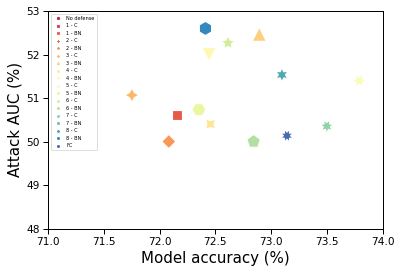

Columns to aggregate
['client_accuracy_2', 'client_accuracy_0', 'client_accuracy_1', 'client_accuracy_4', 'client_accuracy_3']
[71.88, 71.78666666666666, 72.01333333333334, 72.14666666666668, 71.49333333333333]
Columns to aggregate
['server_attack']
[60.88]
Columns to aggregate
['client_accuracy_2', 'client_accuracy_0', 'client_accuracy_1', 'client_accuracy_4', 'client_accuracy_3']
[73.32, 72.86666666666667, 72.88, 72.6, 72.61333333333333]
Columns to aggregate
['server_attack']
[50.306666666666665]
Columns to aggregate
['client_accuracy_2', 'client_accuracy_0', 'client_accuracy_1', 'client_accuracy_4', 'client_accuracy_3']
[72.0, 72.0, 72.34666666666666, 72.14666666666668, 72.29333333333334]
Columns to aggregate
['server_attack']
[50.10666666666667]
Columns to aggregate
['client_accuracy_2', 'client_accuracy_0', 'client_accuracy_1', 'client_accuracy_4', 'client_accuracy_3']
[73.0, 72.56, 72.41333333333333, 72.14666666666668, 72.52]
Columns to aggregate
['server_attack']
[50.2]
Columns 

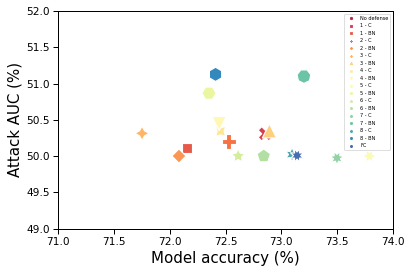

No defense
50
1 - C
50
1 - BN
50
2 - C
50
2 - BN
50
3 - C
50
3 - BN
50
4 - C
50
4 - BN
50
5 - C
50
5 - BN
50
6 - C
50
6 - BN
50
7 - C
50
7 - BN
50
8 - C
50
8 - BN
50
FC
50


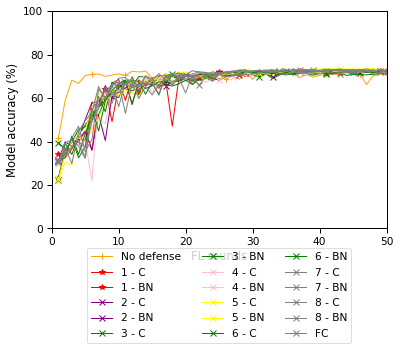

No defense
50
1 - C
50
1 - BN
50
2 - C
50
2 - BN
50
3 - C
50
3 - BN
50
4 - C
50
4 - BN
50
5 - C
50
5 - BN
50
6 - C
50
6 - BN
50
7 - C
50
7 - BN
50
8 - C
50
8 - BN
50
FC
50


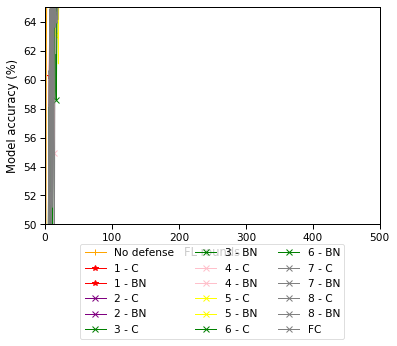

No defense
50
1 - C
50
1 - BN
50
2 - C
50
2 - BN
50
3 - C
50
3 - BN
50
4 - C
50
4 - BN
50
5 - C
50
5 - BN
50
6 - C
50
6 - BN
50
7 - C
50
7 - BN
50
8 - C
50
8 - BN
50
FC
50


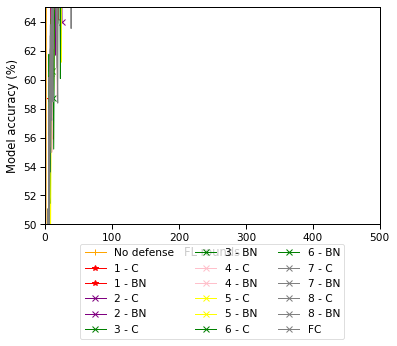

No defense
50
1 - C
50
1 - BN
50
2 - C
50
2 - BN
50
3 - C
50
3 - BN
50
4 - C
50
4 - BN
50
5 - C
50
5 - BN
50
6 - C
50
6 - BN
50
7 - C
50
7 - BN
50
8 - C
50
8 - BN
50
FC
50


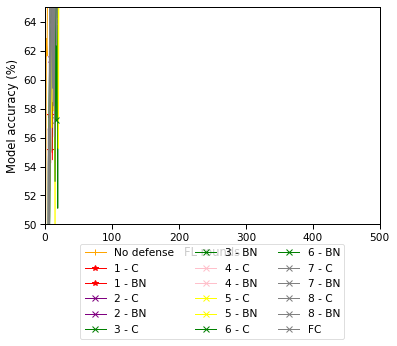

No defense
50
1 - C
50
1 - BN
50
2 - C
50
2 - BN
50
3 - C
50
3 - BN
50
4 - C
50
4 - BN
50
5 - C
50
5 - BN
50
6 - C
50
6 - BN
50
7 - C
50
7 - BN
50
8 - C
50
8 - BN
50
FC
50


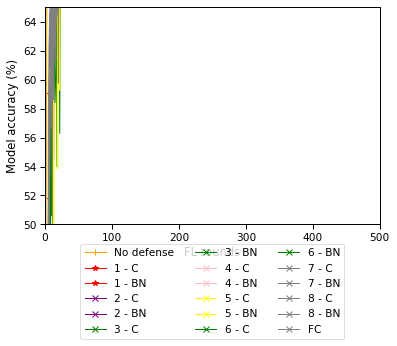

No defense
50
1 - C
50
1 - BN
50
2 - C
50
2 - BN
50
3 - C
50
3 - BN
50
4 - C
50
4 - BN
50
5 - C
50
5 - BN
50
6 - C
50
6 - BN
50
7 - C
50
7 - BN
50
8 - C
50
8 - BN
50
FC
50


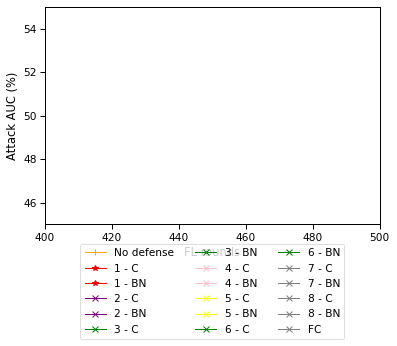

No defense
50
1 - C
50
1 - BN
50
2 - C
50
2 - BN
50
3 - C
50
3 - BN
50
4 - C
50
4 - BN
50
5 - C
50
5 - BN
50
6 - C
50
6 - BN
50
7 - C
50
7 - BN
50
8 - C
50
8 - BN
50
FC
50


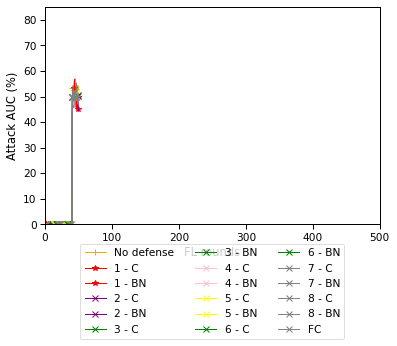

No defense
50
1 - C
50
1 - BN
50
2 - C
50
2 - BN
50
3 - C
50
3 - BN
50
4 - C
50
4 - BN
50
5 - C
50
5 - BN
50
6 - C
50
6 - BN
50
7 - C
50
7 - BN
50
8 - C
50
8 - BN
50
FC
50


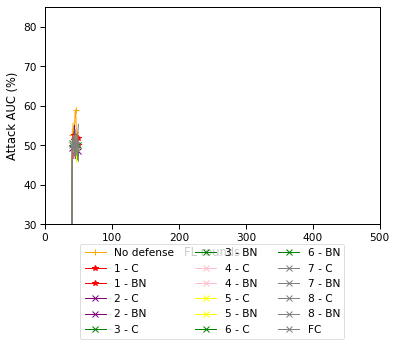

No defense
50
1 - C
50
1 - BN
50
2 - C
50
2 - BN
50
3 - C
50
3 - BN
50
4 - C
50
4 - BN
50
5 - C
50
5 - BN
50
6 - C
50
6 - BN
50
7 - C
50
7 - BN
50
8 - C
50
8 - BN
50
FC
50


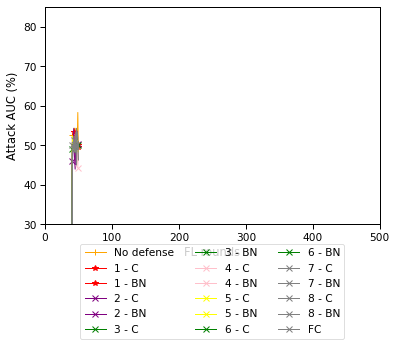

No defense
50
1 - C
50
1 - BN
50
2 - C
50
2 - BN
50
3 - C
50
3 - BN
50
4 - C
50
4 - BN
50
5 - C
50
5 - BN
50
6 - C
50
6 - BN
50
7 - C
50
7 - BN
50
8 - C
50
8 - BN
50
FC
50


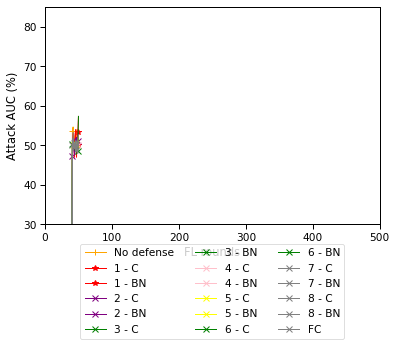

No defense
50
1 - C
50
1 - BN
50
2 - C
50
2 - BN
50
3 - C
50
3 - BN
50
4 - C
50
4 - BN
50
5 - C
50
5 - BN
50
6 - C
50
6 - BN
50
7 - C
50
7 - BN
50
8 - C
50
8 - BN
50
FC
50


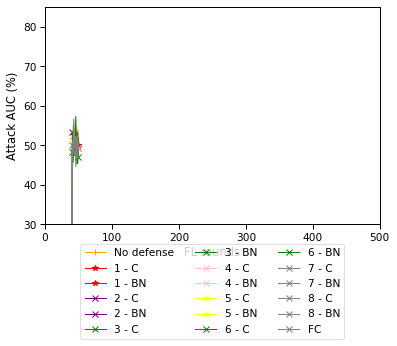

In [162]:
r = 50

generate_histogram(plot_config, "local_model_attack_accuracy_hist", "Attack AUC (%)", "client_auc", 45, 62, average=True, label_rotation=90, std = None, x_fontsize=5, bar_fontsize = 5)
generate_histogram(plot_config, "global_model_attack_accuracy_hist", "Attack AUC (%)", "server_attack", 45, 65, average=True, label_rotation=90, std = None, x_fontsize=5, bar_fontsize = 5)
#generate_xy_plot(plot_config, 'local_models_attack_accuracy', 'Attack AUC (%)', 'client_auc', 0, 100, average=True)
#generate_xy_plot(plot_config, 'global_model_attack_accuracy', 'Attack AUC (%)', 'server_attack', 0, 100, average=True)
#generate_xy_plot(plot_config, 'local_models_accuracy', 'Model accuracy (%)', 'client_accuracy', 0, 100, average=True)
generate_histogram(plot_config, "local_models_accuracy_hist", "Model accuracy (%)", "client_accuracy", 65, 75, average=True, label_rotation=90, x_fontsize=5, bar_fontsize = 5)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy', 'client_auc', 48, 53, 71, 74, average=True, markerscale = 0.5, legend_fontsize=5)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_server', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy', 'server_attack', 49, 52, 71, 74, average=True, markerscale = 0.5, legend_fontsize=5)

generate_xy_plot(plot_config, 'local_model0_accuracy', 'Model accuracy (%)', 'client_accuracy_0', 0, 100, min_x=0, max_x = 50, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model1_accuracy', 'Model accuracy (%)', 'client_accuracy_1', 50, 65, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model2_accuracy', 'Model accuracy (%)', 'client_accuracy_2', 50, 65, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model3_accuracy', 'Model accuracy (%)', 'client_accuracy_3', 50, 65, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model4_accuracy', 'Model accuracy (%)', 'client_accuracy_4', 50, 65, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)

generate_xy_plot(plot_config, 'server_auc', 'Attack AUC (%)', 'server_auc', 45, 55, min_x=400, max_x = 500, average=True, extension='.png', max_range=r)

generate_xy_plot(plot_config, 'local_model0_auc', 'Attack AUC (%)', 'client_auc_0', 0, 85, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model1_auc', 'Attack AUC (%)', 'client_auc_1', 30, 85, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model2_auc', 'Attack AUC (%)', 'client_auc_2', 30, 85, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model3_auc', 'Attack AUC (%)', 'client_auc_3', 30, 85, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model4_auc', 'Attack AUC (%)', 'client_auc_4', 30, 85, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)

### Gradient descent techniques

In [39]:
          plot_config = {
                "dataset_name": "purchase_gradient_descent",
                "dataset_pretty_name" : "CelebA_ResNet",

                "data":[
                    
                                            {
                            "exp_name" : "No defense",
                            "file_path": "ppm_baseline_300_purchase.csv",
                            "color": "orange",
                            "symbol" : "+"
                        },
                        

                    {
                            "exp_name" : "PASTEL-P (Adam)",
                            "file_path": "ppm_pastel_features6_purchase.csv",
                            "color": "blue",
                            "symbol" : "x"
                        },
                    
                                                                {
                                                "exp_name" : "ADGD-Accel",
                            "file_path": "ppm_pastel_features6_classifier_adgd_accel_purchase.csv",
                            "color": "red",
                            "symbol" : "x"
                        },
                                                                                                                                           {
                            "exp_name" : "AdaMax",
                            "file_path": "ppm_pastel_features6_adamax_purchase.csv",
                            "color": "red",
                            "symbol" : "x"
                        },

                    
                    
                        {
                            "exp_name" : "PASTEL (AdaGrad)",
                            "file_path": "ppm_pastel_features6_adagrad_purchase.csv",
                            "color": "green",
                            "symbol" : "x"
                        }  
                                                                                                     
    
                ]
          }
                    
                    
                    

Columns to aggregate
['client_auc_1', 'client_auc_6', 'client_auc_4', 'client_auc_9', 'client_auc_3', 'client_auc_8', 'client_auc_5', 'client_auc_7', 'client_auc_2', 'client_auc_0']
[76.0, 81.0, 77.0, 80.0, 77.0, 80.0, 79.0, 80.0, 75.0, 76.0]
Columns to aggregate
['client_auc_1', 'client_auc_6', 'client_auc_4', 'client_auc_9', 'client_auc_3', 'client_auc_8', 'client_auc_5', 'client_auc_7', 'client_auc_2', 'client_auc_0']
[50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0]
Columns to aggregate
['client_auc_1', 'client_auc_6', 'client_auc_4', 'client_auc_9', 'client_auc_3', 'client_auc_8', 'client_auc_5', 'client_auc_7', 'client_auc_2', 'client_auc_0']
[50.0, 50.0, 51.0, 50.0, 50.0, 50.0, 50.0, 51.0, 50.0, 50.0]
Columns to aggregate
['client_auc_1', 'client_auc_6', 'client_auc_4', 'client_auc_9', 'client_auc_3', 'client_auc_8', 'client_auc_5', 'client_auc_7', 'client_auc_2', 'client_auc_0']
[50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0]
Columns to aggregate
['clien

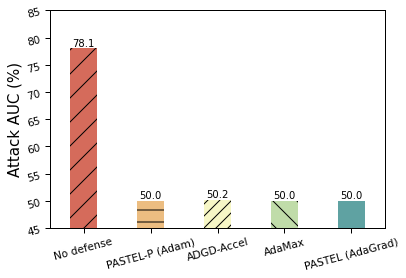

Columns to aggregate
['server_attack']
[52.09811473748226]
Columns to aggregate
['server_attack']
[50.01013581998783]
Columns to aggregate
['server_attack']
[50.0]
Columns to aggregate
['server_attack']
[50.01013581998783]
Columns to aggregate
['server_attack']
[50.01013581998783]
[0.5554168530182385, 0.012968701466938624, 0.02153050066403814, 0.011335703685196338, 0.009223719946587274]
Labels
['No defense', 'PASTEL-P (Adam)', 'ADGD-Accel', 'AdaMax', 'PASTEL (AdaGrad)']
[52.1, 50.01, 50.0, 50.01, 50.01]
None


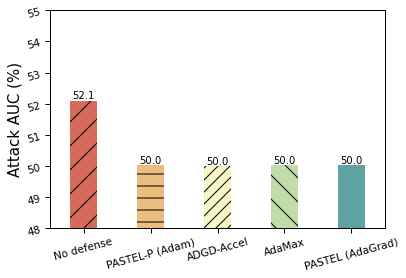

Columns to aggregate
['client_accuracy_1', 'client_accuracy_6', 'client_accuracy_4', 'client_accuracy_9', 'client_accuracy_3', 'client_accuracy_8', 'client_accuracy_5', 'client_accuracy_7', 'client_accuracy_2', 'client_accuracy_0']
[60.65274680721671, 60.87573484694912, 61.301439286438274, 60.2675856476789, 60.63247516724103, 60.389215487532944, 61.443340766268, 60.22704236772755, 60.61220352726535, 59.98378268801946]
Columns to aggregate
['client_accuracy_1', 'client_accuracy_6', 'client_accuracy_4', 'client_accuracy_9', 'client_accuracy_3', 'client_accuracy_8', 'client_accuracy_5', 'client_accuracy_7', 'client_accuracy_2', 'client_accuracy_0']
[58.22015001013582, 59.03101560916279, 58.78775592945469, 58.726941009527664, 59.11210216906547, 58.13906345023312, 58.56476788972228, 58.118791810257456, 59.29454692884655, 58.74721264950335]
Columns to aggregate
['client_accuracy_1', 'client_accuracy_6', 'client_accuracy_4', 'client_accuracy_9', 'client_accuracy_3', 'client_accuracy_8', 'clie

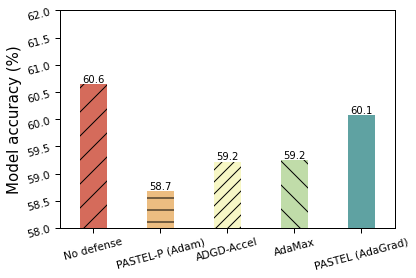

Columns to aggregate
['client_accuracy_1', 'client_accuracy_6', 'client_accuracy_4', 'client_accuracy_9', 'client_accuracy_3', 'client_accuracy_8', 'client_accuracy_5', 'client_accuracy_7', 'client_accuracy_2', 'client_accuracy_0']
[60.65274680721671, 60.87573484694912, 61.301439286438274, 60.2675856476789, 60.63247516724103, 60.389215487532944, 61.443340766268, 60.22704236772755, 60.61220352726535, 59.98378268801946]
Columns to aggregate
['client_auc_1', 'client_auc_6', 'client_auc_4', 'client_auc_9', 'client_auc_3', 'client_auc_8', 'client_auc_5', 'client_auc_7', 'client_auc_2', 'client_auc_0']
[76.0, 81.0, 77.0, 80.0, 77.0, 80.0, 79.0, 80.0, 75.0, 76.0]
Columns to aggregate
['client_accuracy_1', 'client_accuracy_6', 'client_accuracy_4', 'client_accuracy_9', 'client_accuracy_3', 'client_accuracy_8', 'client_accuracy_5', 'client_accuracy_7', 'client_accuracy_2', 'client_accuracy_0']
[58.22015001013582, 59.03101560916279, 58.78775592945469, 58.726941009527664, 59.11210216906547, 58.139

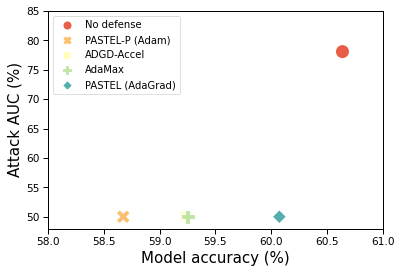

Columns to aggregate
['client_accuracy_1', 'client_accuracy_6', 'client_accuracy_4', 'client_accuracy_9', 'client_accuracy_3', 'client_accuracy_8', 'client_accuracy_5', 'client_accuracy_7', 'client_accuracy_2', 'client_accuracy_0']
[60.65274680721671, 60.87573484694912, 61.301439286438274, 60.2675856476789, 60.63247516724103, 60.389215487532944, 61.443340766268, 60.22704236772755, 60.61220352726535, 59.98378268801946]
Columns to aggregate
['server_attack']
[52.09811473748226]
Columns to aggregate
['client_accuracy_1', 'client_accuracy_6', 'client_accuracy_4', 'client_accuracy_9', 'client_accuracy_3', 'client_accuracy_8', 'client_accuracy_5', 'client_accuracy_7', 'client_accuracy_2', 'client_accuracy_0']
[58.22015001013582, 59.03101560916279, 58.78775592945469, 58.726941009527664, 59.11210216906547, 58.13906345023312, 58.56476788972228, 58.118791810257456, 59.29454692884655, 58.74721264950335]
Columns to aggregate
['server_attack']
[50.01013581998783]
Columns to aggregate
['client_accur

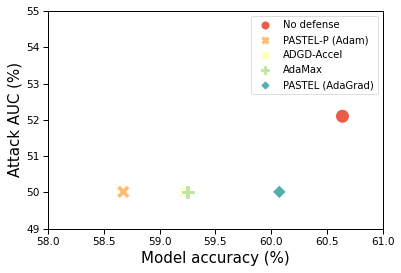

No defense
300
PASTEL-P (Adam)
300
ADGD-Accel
300
AdaMax
300
PASTEL (AdaGrad)
300


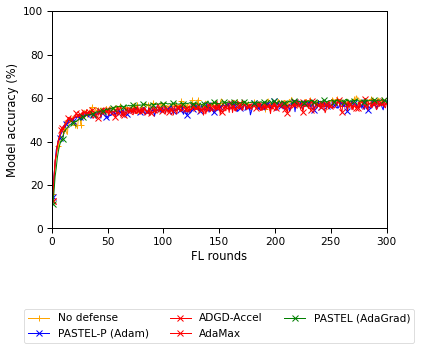

No defense
300
PASTEL-P (Adam)
300
ADGD-Accel
300
AdaMax
300
PASTEL (AdaGrad)
300


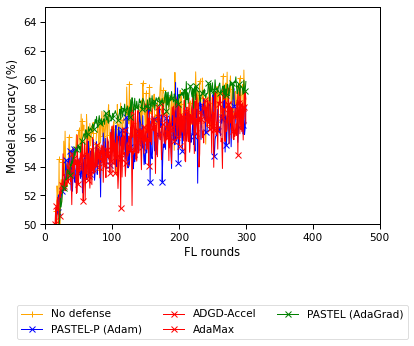

No defense
300
PASTEL-P (Adam)
300
ADGD-Accel
300
AdaMax
300
PASTEL (AdaGrad)
300


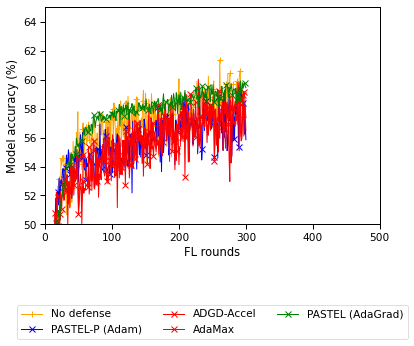

No defense
300
PASTEL-P (Adam)
300
ADGD-Accel
300
AdaMax
300
PASTEL (AdaGrad)
300


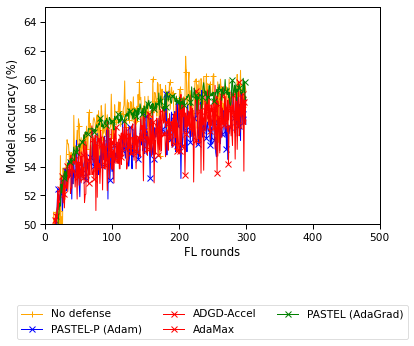

No defense
300
PASTEL-P (Adam)
300
ADGD-Accel
300
AdaMax
300
PASTEL (AdaGrad)
300


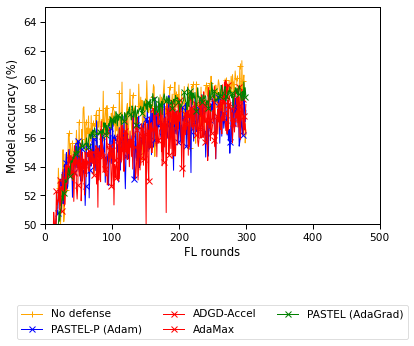

No defense
300
PASTEL-P (Adam)
300
ADGD-Accel
300
AdaMax
300
PASTEL (AdaGrad)
300


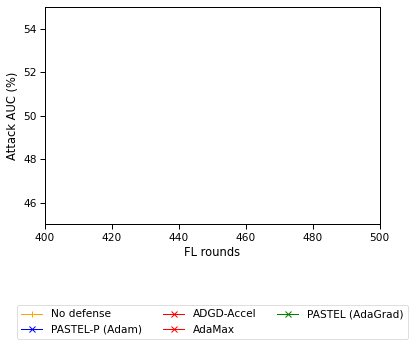

No defense
300
PASTEL-P (Adam)
300
ADGD-Accel
300
AdaMax
300
PASTEL (AdaGrad)
300


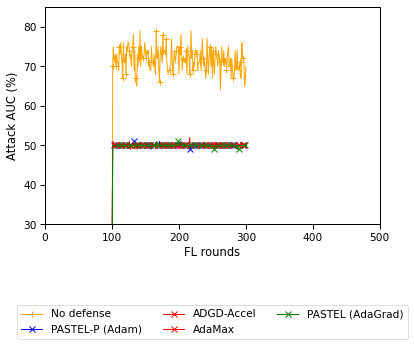

No defense
300
PASTEL-P (Adam)
300
ADGD-Accel
300
AdaMax
300
PASTEL (AdaGrad)
300


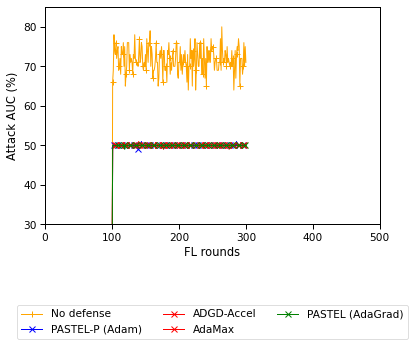

No defense
300
PASTEL-P (Adam)
300
ADGD-Accel
300
AdaMax
300
PASTEL (AdaGrad)
300


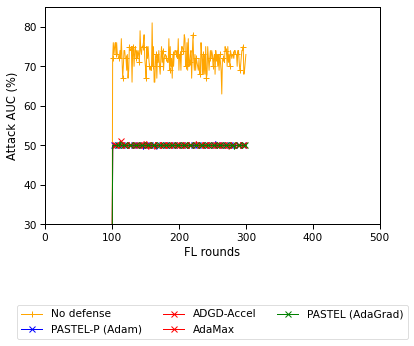

No defense
300
PASTEL-P (Adam)
300
ADGD-Accel
300
AdaMax
300
PASTEL (AdaGrad)
300


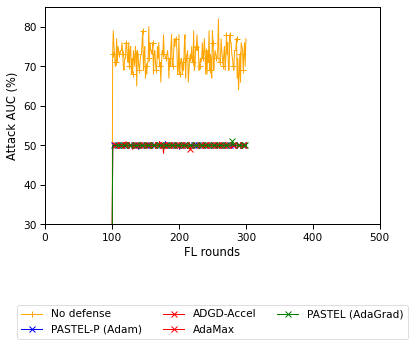

No defense
300
PASTEL-P (Adam)
300
ADGD-Accel
300
AdaMax
300
PASTEL (AdaGrad)
300


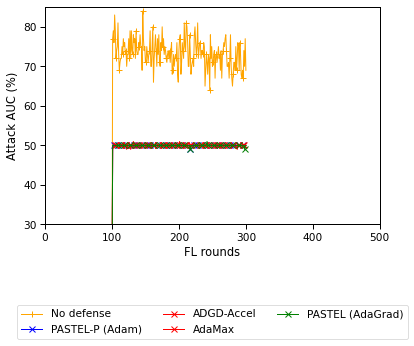

In [40]:
r = 300

generate_histogram(plot_config, "local_model_attack_accuracy_hist", "Attack AUC (%)", "client_auc", 45, 85, average=True, label_rotation=15)
generate_histogram(plot_config, "global_model_attack_accuracy_hist", "Attack AUC (%)", "server_attack", 48, 55, average=True, label_rotation=15)
#generate_xy_plot(plot_config, 'local_models_attack_accuracy', 'Attack AUC (%)', 'client_auc', 0, 100, average=True)
#generate_xy_plot(plot_config, 'global_model_attack_accuracy', 'Attack AUC (%)', 'server_attack', 0, 100, average=True)
#generate_xy_plot(plot_config, 'local_models_accuracy', 'Model accuracy (%)', 'client_accuracy', 0, 100, average=True)
generate_histogram(plot_config, "local_models_accuracy_hist", "Model accuracy (%)", "client_accuracy", 58, 62, average=True, label_rotation=15)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy', 'client_auc', 48, 85, 58, 61, average=True)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_server', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy', 'server_attack', 49, 55, 58, 61, average=True)

generate_xy_plot(plot_config, 'local_model0_accuracy', 'Model accuracy (%)', 'client_accuracy_0', 0, 100, min_x=0, max_x = 300, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model1_accuracy', 'Model accuracy (%)', 'client_accuracy_1', 50, 65, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model2_accuracy', 'Model accuracy (%)', 'client_accuracy_2', 50, 65, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model3_accuracy', 'Model accuracy (%)', 'client_accuracy_3', 50, 65, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model4_accuracy', 'Model accuracy (%)', 'client_accuracy_4', 50, 65, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)

generate_xy_plot(plot_config, 'server_auc', 'Attack AUC (%)', 'server_auc', 45, 55, min_x=400, max_x = 500, average=True, extension='.png', max_range=r)

generate_xy_plot(plot_config, 'local_model0_auc', 'Attack AUC (%)', 'client_auc_0', 30, 85, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model1_auc', 'Attack AUC (%)', 'client_auc_1', 30, 85, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model2_auc', 'Attack AUC (%)', 'client_auc_2', 30, 85, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model3_auc', 'Attack AUC (%)', 'client_auc_3', 30, 85, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model4_auc', 'Attack AUC (%)', 'client_auc_4', 30, 85, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)

### Loss Analysis

In [41]:
          plot_config = {
                "dataset_name": "loss_analysis",
                "dataset_pretty_name" : "CelebA_ResNet",

                "data":[
                    
                                            {
                            "exp_name" : "No defense",
                            "file_path": "ppm_purchase_adam_baseline_loss.csv",
                            "color": "orange",
                            "symbol" : "o"
                        },
                                                                                    {
                                                "exp_name" : "ADGD-Accel",
                            "file_path": "ppm_pastel_features6_classifier_adgd_accel_purchase.csv",
                            "color": "red",
                            "symbol" : "X"},
                        

                    {
                            "exp_name" : "PASTEL-P(Adam)",
                            "file_path": "ppm_purchase_adam_pastel_loss.csv",
                            "color": "purple",
                            "symbol" : "s"
                        },
                                                                                        
                    {
                            "exp_name" : "AdaMax",
                            "file_path": "ppm_pastel_features6_adamax_purchase.csv",
                            "color": "blue",
                            "symbol" : "P"
                        },
                    
                    
                        {
                            "exp_name" : "PASTEL",
                            "file_path": "ppm_purchase_adagrad_pastel_loss.csv",
                            "color": "black",
                            "symbol" : "D"
                        }  
                                                                                                     
    
                ]
          }
                    
                    
                    

No defense
200
ADGD-Accel
200
PASTEL-P(Adam)
200
AdaMax
200
PASTEL
200


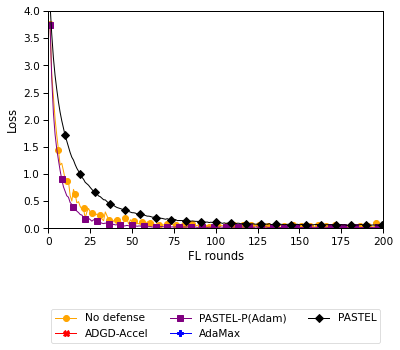

No defense
200
ADGD-Accel
200
PASTEL-P(Adam)
200
AdaMax
200
PASTEL
200


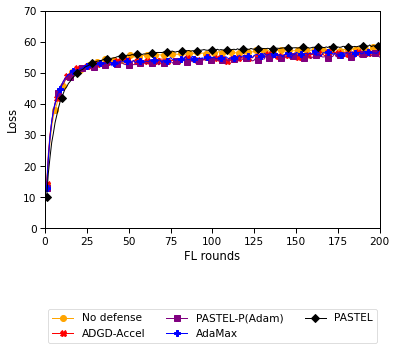

In [42]:
r = 200
generate_xy_plot(plot_config, 'local_models_loss', 'Loss', 'client_loss', 0, 4, min_x=0, max_x = 200, average=True, max_range=r)
generate_xy_plot(plot_config, 'local_models_accuracy', 'Loss', 'client_accuracy', 0, 70, min_x=0, max_x = 200, average=True, max_range=r)


### Layers Analysis Celeba ResNet 

In [45]:
          plot_config = {
                "dataset_name": "celeba_resnet_layer_analysis_adagrad",
                "dataset_pretty_name" : "CelebA_ResNet",

                "data":[

                                            {
                            "exp_name" : "No defense",
                            "file_path": "ppm_baseline_celeba_resnet.csv",
                            "color": "orange",
                            "symbol" : "+"
                        },


                    {
                            "exp_name" : "1.0 - C1",
                            "file_path": "ppm_pastel_layer1.0_conv1_true_adagrad_celeba_resnet.csv",
                            "color": "blue",
                            "symbol" : "x"
                        },

                                                                {
                            "exp_name" : "1.0 - BN1",
                            "file_path": "ppm_pastel_layer1.0_bn1_true_adagrad_celeba_resnet.csv",
                            "color": "red",
                            "symbol" : "x"
                        },

                                        {
                            "exp_name" : "1.0 - C2",
                            "file_path": "ppm_pastel_layer1.0_conv2_true_adagrad_celeba_resnet.csv",
                            "color": "blue",
                            "symbol" : "x"
                        },

                                                                {
                            "exp_name" : "1.0 - BN2",
                            "file_path": "ppm_pastel_layer1.0_bn2_true_adagrad_celeba_resnet.csv",
                            "color": "red",
                            "symbol" : "x"
                        },


                                      {
                            "exp_name" : "1.1 - C1",
                            "file_path": "ppm_pastel_layer1.0_conv1_true_adagrad_celeba_resnet.csv",
                            "color": "blue",
                            "symbol" : "x"
                        },

                                                                {
                            "exp_name" : "1.1 - BN1",
                            "file_path": "ppm_pastel_layer1.1_bn1_true_adagrad_celeba_resnet.csv",
                            "color": "red",
                            "symbol" : "x"
                        },

                                        {
                            "exp_name" : "1.1 - C2",
                            "file_path": "ppm_pastel_layer1.0_conv2_true_adagrad_celeba_resnet.csv",
                            "color": "blue",
                            "symbol" : "x"
                        },

                                                                {
                            "exp_name" : "1.1 - BN2",
                            "file_path": "ppm_pastel_layer1.1_bn2_true_adagrad_celeba_resnet.csv",
                            "color": "red",
                            "symbol" : "x"
                        },


                                      {
                            "exp_name" : "1.2 - C1",
                            "file_path": "ppm_pastel_layer1.2_conv1_true_adagrad_celeba_resnet.csv",
                            "color": "blue",
                            "symbol" : "x"
                        },

                                                                {
                            "exp_name" : "1.2 - BN1",
                            "file_path": "ppm_pastel_layer1.2_bn1_true_adagrad_celeba_resnet.csv",
                            "color": "red",
                            "symbol" : "x"
                        },

                                        {
                            "exp_name" : "1.2 - C2",
                            "file_path": "ppm_pastel_layer1.2_conv2_true_adagrad_celeba_resnet.csv",
                            "color": "blue",
                            "symbol" : "x"
                        },

                                                                {
                            "exp_name" : "1.2 - BN2",
                            "file_path": "ppm_pastel_layer1.2_bn2_true_adagrad_celeba_resnet.csv",
                            "color": "red",
                            "symbol" : "x"
                        },



                                      {
                            "exp_name" : "2.0 - C1",
                            "file_path": "ppm_pastel_layer2.0_conv1_true_adagrad_celeba_resnet.csv",
                            "color": "blue",
                            "symbol" : "x"
                        },

                                                                {
                            "exp_name" : "2.0 - BN1",
                            "file_path": "ppm_pastel_layer2.0_bn1_true_adagrad_celeba_resnet.csv",
                            "color": "red",
                            "symbol" : "x"
                        },

                                        {
                            "exp_name" : "2.0 - C2",
                            "file_path": "ppm_pastel_layer2.0_conv2_true_adagrad_celeba_resnet.csv",
                            "color": "blue",
                            "symbol" : "x"
                        },

                                                                {
                            "exp_name" : "2.0 - BN2",
                            "file_path": "ppm_pastel_layer2.0_bn2_true_adagrad_celeba_resnet.csv",
                            "color": "red",
                            "symbol" : "x"
                        },


                                      {
                            "exp_name" : "2.1 - C1",
                            "file_path": "ppm_pastel_layer2.0_conv1_true_adagrad_celeba_resnet.csv",
                            "color": "blue",
                            "symbol" : "x"
                        },

                                                                {
                            "exp_name" : "2.1 - BN1",
                            "file_path": "ppm_pastel_layer2.1_bn1_true_adagrad_celeba_resnet.csv",
                            "color": "red",
                            "symbol" : "x"
                        },

                                        {
                            "exp_name" : "2.1 - C2",
                            "file_path": "ppm_pastel_layer2.0_conv2_true_adagrad_celeba_resnet.csv",
                            "color": "blue",
                            "symbol" : "x"
                        },

                                                                {
                            "exp_name" : "2.1 - BN2",
                            "file_path": "ppm_pastel_layer2.1_bn2_true_adagrad_celeba_resnet.csv",
                            "color": "red",
                            "symbol" : "x"
                        },


                                      {
                            "exp_name" : "2.2 - C1",
                            "file_path": "ppm_pastel_layer2.2_conv1_true_adagrad_celeba_resnet.csv",
                            "color": "blue",
                            "symbol" : "x"
                        },

                                                                {
                            "exp_name" : "2.2 - BN1",
                            "file_path": "ppm_pastel_layer2.2_bn1_true_adagrad_celeba_resnet.csv",
                            "color": "red",
                            "symbol" : "x"
                        },

                                        {
                            "exp_name" : "2.2 - C2",
                            "file_path": "ppm_pastel_layer2.2_conv2_true_adagrad_celeba_resnet.csv",
                            "color": "blue",
                            "symbol" : "x"
                        },

                                                                {
                            "exp_name" : "2.2 - BN2",
                            "file_path": "ppm_pastel_layer2.2_bn2_true_adagrad_celeba_resnet.csv",
                            "color": "red",
                            "symbol" : "x"
                        },


                                      {
                            "exp_name" : "3.0 - C1",
                            "file_path": "ppm_pastel_layer3.0_conv1_true_adagrad_celeba_resnet.csv",
                            "color": "blue",
                            "symbol" : "x"
                        },

                                                                {
                            "exp_name" : "3.0 - BN1",
                            "file_path": "ppm_pastel_layer3.0_bn1_true_adagrad_celeba_resnet.csv",
                            "color": "red",
                            "symbol" : "x"
                        },

                                        {
                            "exp_name" : "3.0 - C2",
                            "file_path": "ppm_pastel_layer3.0_conv2_true_adagrad_celeba_resnet.csv",
                            "color": "blue",
                            "symbol" : "x"
                        },

                                                                {
                            "exp_name" : "3.0 - BN2",
                            "file_path": "ppm_pastel_layer3.0_bn2_true_adagrad_celeba_resnet.csv",
                            "color": "red",
                            "symbol" : "x"
                        },


                                      {
                            "exp_name" : "3.1 - C1",
                            "file_path": "ppm_pastel_layer3.0_conv1_true_adagrad_celeba_resnet.csv",
                            "color": "blue",
                            "symbol" : "x"
                        },

                                                                {
                            "exp_name" : "3.1 - BN1",
                            "file_path": "ppm_pastel_layer3.1_bn1_true_adagrad_celeba_resnet.csv",
                            "color": "red",
                            "symbol" : "x"
                        },

                                        {
                            "exp_name" : "3.1 - C2",
                            "file_path": "ppm_pastel_layer3.0_conv2_true_adagrad_celeba_resnet.csv",
                            "color": "blue",
                            "symbol" : "x"
                        },

                                                                {
                            "exp_name" : "3.1 - BN2",
                            "file_path": "ppm_pastel_layer3.1_bn2_true_adagrad_celeba_resnet.csv",
                            "color": "red",
                            "symbol" : "x"
                        },


                                      {
                            "exp_name" : "3.2 - C1",
                            "file_path": "ppm_pastel_layer3.2_conv1_true_adagrad_celeba_resnet.csv",
                            "color": "blue",
                            "symbol" : "x"
                        },

                                                                {
                            "exp_name" : "3.2 - BN1",
                            "file_path": "ppm_pastel_layer3.2_bn1_true_adagrad_celeba_resnet.csv",
                            "color": "red",
                            "symbol" : "x"
                        },

                                        {
                            "exp_name" : "3.2 - C2",
                            "file_path": "ppm_pastel_layer3.2_conv2_true_adagrad_celeba_resnet.csv",
                            "color": "blue",
                            "symbol" : "x"
                        },

                                                                {
                            "exp_name" : "3.2 - BN2",
                            "file_path": "ppm_pastel_layer3.2_bn2_true_adagrad_celeba_resnet.csv",
                            "color": "red",
                            "symbol" : "x"
                        },
                  
                                                                                  {
                            "exp_name" : "Linear",
                            "file_path": "ppm_pastel_linear_true_adagrad_celeba_resnet.csv",
                            "color": "red",
                            "symbol" : "x"
                        }
                ]
          }



                    
                    
                    

Columns to aggregate
['client_auc_2', 'client_auc_0', 'client_auc_1', 'client_auc_4', 'client_auc_3']
[54.333333333333336, 60.00000000000001, 53.66666666666667, 54.66666666666666, 55.333333333333336]
Columns to aggregate
['client_auc_2', 'client_auc_0', 'client_auc_1', 'client_auc_4', 'client_auc_3']
[50.66666666666667, 52.33333333333334, 51.33333333333333, 51.33333333333333, 50.33333333333334]
Columns to aggregate
['client_auc_2', 'client_auc_0', 'client_auc_1', 'client_auc_4', 'client_auc_3']
[53.66666666666667, 50.66666666666666, 50.0, 53.333333333333336, 55.33333333333332]
Columns to aggregate
['client_auc_2', 'client_auc_0', 'client_auc_1', 'client_auc_4', 'client_auc_3']
[53.66666666666667, 51.0, 51.66666666666667, 51.0, 51.33333333333334]
Columns to aggregate
['client_auc_2', 'client_auc_0', 'client_auc_1', 'client_auc_4', 'client_auc_3']
[55.66666666666668, 54.0, 51.33333333333333, 52.33333333333334, 54.99999999999999]
Columns to aggregate
['client_auc_2', 'client_auc_0', 'clie

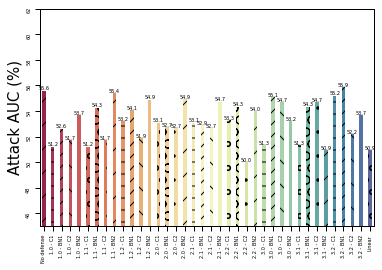

Columns to aggregate
['server_attack']
[55.53333333333333]
Columns to aggregate
['server_attack']
[50.153333333333336]
Columns to aggregate
['server_attack']
[50.54]
Columns to aggregate
['server_attack']
[50.373333333333335]
Columns to aggregate
['server_attack']
[50.906666666666666]
Columns to aggregate
['server_attack']
[50.153333333333336]
Columns to aggregate
['server_attack']
[51.17333333333334]
Columns to aggregate
['server_attack']
[50.373333333333335]
Columns to aggregate
['server_attack']
[50.906666666666666]
Columns to aggregate
['server_attack']
[50.32]
Columns to aggregate
['server_attack']
[50.82666666666667]
Columns to aggregate
['server_attack']
[50.20666666666666]
Columns to aggregate
['server_attack']
[50.91333333333333]
Columns to aggregate
['server_attack']
[50.84666666666666]
Columns to aggregate
['server_attack']
[50.32]
Columns to aggregate
['server_attack']
[50.32666666666666]
Columns to aggregate
['server_attack']
[50.126666666666665]
Columns to aggregate
['ser

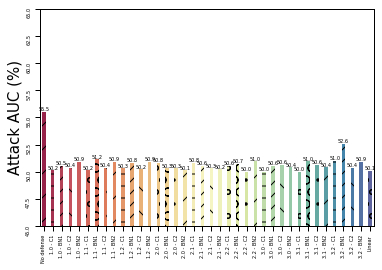

Columns to aggregate
['client_accuracy_2', 'client_accuracy_0', 'client_accuracy_1', 'client_accuracy_4', 'client_accuracy_3']
[63.14666666666666, 64.21333333333334, 64.26666666666667, 64.65333333333334, 64.0]
Columns to aggregate
['client_accuracy_2', 'client_accuracy_0', 'client_accuracy_1', 'client_accuracy_4', 'client_accuracy_3']
[63.973333333333336, 63.68000000000001, 64.06666666666668, 63.17333333333334, 63.93333333333333]
Columns to aggregate
['client_accuracy_2', 'client_accuracy_0', 'client_accuracy_1', 'client_accuracy_4', 'client_accuracy_3']
[63.46666666666667, 63.32, 63.92, 63.68000000000001, 63.586666666666666]
Columns to aggregate
['client_accuracy_2', 'client_accuracy_0', 'client_accuracy_1', 'client_accuracy_4', 'client_accuracy_3']
[64.92, 63.98666666666667, 65.33333333333333, 65.12, 64.8]
Columns to aggregate
['client_accuracy_2', 'client_accuracy_0', 'client_accuracy_1', 'client_accuracy_4', 'client_accuracy_3']
[63.61333333333333, 64.03999999999999, 64.22666666666

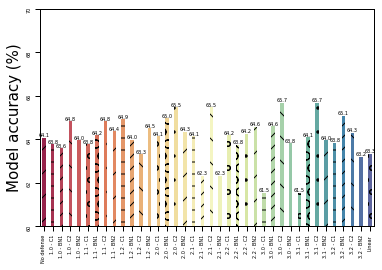

Columns to aggregate
['client_accuracy_2', 'client_accuracy_0', 'client_accuracy_1', 'client_accuracy_4', 'client_accuracy_3']
[63.14666666666666, 64.21333333333334, 64.26666666666667, 64.65333333333334, 64.0]
Columns to aggregate
['client_auc_2', 'client_auc_0', 'client_auc_1', 'client_auc_4', 'client_auc_3']
[54.333333333333336, 60.00000000000001, 53.66666666666667, 54.66666666666666, 55.333333333333336]
Columns to aggregate
['client_accuracy_2', 'client_accuracy_0', 'client_accuracy_1', 'client_accuracy_4', 'client_accuracy_3']
[63.973333333333336, 63.68000000000001, 64.06666666666668, 63.17333333333334, 63.93333333333333]
Columns to aggregate
['client_auc_2', 'client_auc_0', 'client_auc_1', 'client_auc_4', 'client_auc_3']
[50.66666666666667, 52.33333333333334, 51.33333333333333, 51.33333333333333, 50.33333333333334]
Columns to aggregate
['client_accuracy_2', 'client_accuracy_0', 'client_accuracy_1', 'client_accuracy_4', 'client_accuracy_3']
[63.46666666666667, 63.32, 63.92, 63.6800

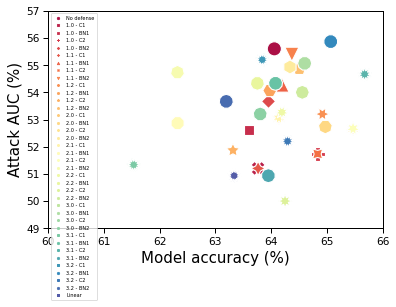

Columns to aggregate
['client_accuracy_2', 'client_accuracy_0', 'client_accuracy_1', 'client_accuracy_4', 'client_accuracy_3']
[63.14666666666666, 64.21333333333334, 64.26666666666667, 64.65333333333334, 64.0]
Columns to aggregate
['server_attack']
[55.53333333333333]
Columns to aggregate
['client_accuracy_2', 'client_accuracy_0', 'client_accuracy_1', 'client_accuracy_4', 'client_accuracy_3']
[63.973333333333336, 63.68000000000001, 64.06666666666668, 63.17333333333334, 63.93333333333333]
Columns to aggregate
['server_attack']
[50.153333333333336]
Columns to aggregate
['client_accuracy_2', 'client_accuracy_0', 'client_accuracy_1', 'client_accuracy_4', 'client_accuracy_3']
[63.46666666666667, 63.32, 63.92, 63.68000000000001, 63.586666666666666]
Columns to aggregate
['server_attack']
[50.54]
Columns to aggregate
['client_accuracy_2', 'client_accuracy_0', 'client_accuracy_1', 'client_accuracy_4', 'client_accuracy_3']
[64.92, 63.98666666666667, 65.33333333333333, 65.12, 64.8]
Columns to agg

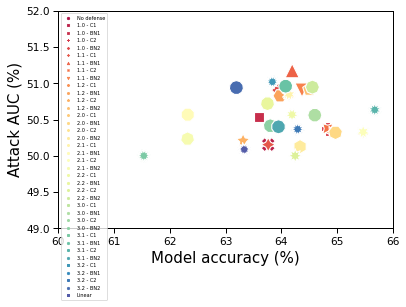

No defense
50
1.0 - C1
50
1.0 - BN1
50
1.0 - C2
50
1.0 - BN2
50
1.1 - C1
50
1.1 - BN1
50
1.1 - C2
50
1.1 - BN2
50
1.2 - C1
50
1.2 - BN1
50
1.2 - C2
50
1.2 - BN2
50
2.0 - C1
50
2.0 - BN1
50
2.0 - C2
50
2.0 - BN2
50
2.1 - C1
50
2.1 - BN1
50
2.1 - C2
50
2.1 - BN2
50
2.2 - C1
50
2.2 - BN1
50
2.2 - C2
50
2.2 - BN2
50
3.0 - C1
50
3.0 - BN1
50
3.0 - C2
50
3.0 - BN2
50
3.1 - C1
50
3.1 - BN1
50
3.1 - C2
50
3.1 - BN2
50
3.2 - C1
50
3.2 - BN1
50
3.2 - C2
50
3.2 - BN2
50
Linear
50


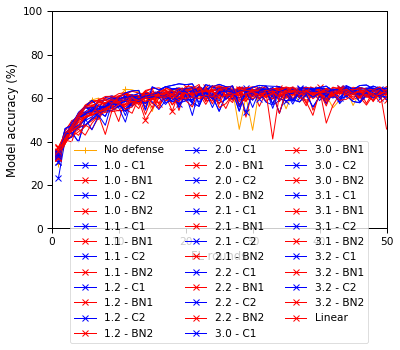

No defense
50
1.0 - C1
50
1.0 - BN1
50
1.0 - C2
50
1.0 - BN2
50
1.1 - C1
50
1.1 - BN1
50
1.1 - C2
50
1.1 - BN2
50
1.2 - C1
50
1.2 - BN1
50
1.2 - C2
50
1.2 - BN2
50
2.0 - C1
50
2.0 - BN1
50
2.0 - C2
50
2.0 - BN2
50
2.1 - C1
50
2.1 - BN1
50
2.1 - C2
50
2.1 - BN2
50
2.2 - C1
50
2.2 - BN1
50
2.2 - C2
50
2.2 - BN2
50
3.0 - C1
50
3.0 - BN1
50
3.0 - C2
50
3.0 - BN2
50
3.1 - C1
50
3.1 - BN1
50
3.1 - C2
50
3.1 - BN2
50
3.2 - C1
50
3.2 - BN1
50
3.2 - C2
50
3.2 - BN2
50
Linear
50


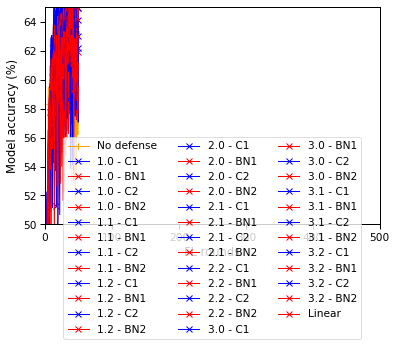

No defense
50
1.0 - C1
50
1.0 - BN1
50
1.0 - C2
50
1.0 - BN2
50
1.1 - C1
50
1.1 - BN1
50
1.1 - C2
50
1.1 - BN2
50
1.2 - C1
50
1.2 - BN1
50
1.2 - C2
50
1.2 - BN2
50
2.0 - C1
50
2.0 - BN1
50
2.0 - C2
50
2.0 - BN2
50
2.1 - C1
50
2.1 - BN1
50
2.1 - C2
50
2.1 - BN2
50
2.2 - C1
50
2.2 - BN1
50
2.2 - C2
50
2.2 - BN2
50
3.0 - C1
50
3.0 - BN1
50
3.0 - C2
50
3.0 - BN2
50
3.1 - C1
50
3.1 - BN1
50
3.1 - C2
50
3.1 - BN2
50
3.2 - C1
50
3.2 - BN1
50
3.2 - C2
50
3.2 - BN2
50
Linear
50


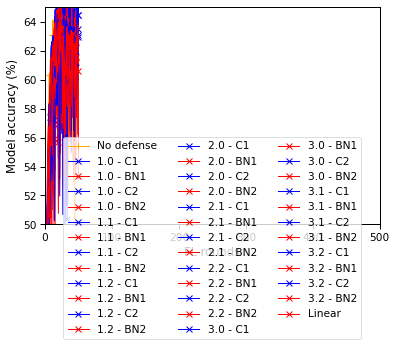

No defense
50
1.0 - C1
50
1.0 - BN1
50
1.0 - C2
50
1.0 - BN2
50
1.1 - C1
50
1.1 - BN1
50
1.1 - C2
50
1.1 - BN2
50
1.2 - C1
50
1.2 - BN1
50
1.2 - C2
50
1.2 - BN2
50
2.0 - C1
50
2.0 - BN1
50
2.0 - C2
50
2.0 - BN2
50
2.1 - C1
50
2.1 - BN1
50
2.1 - C2
50
2.1 - BN2
50
2.2 - C1
50
2.2 - BN1
50
2.2 - C2
50
2.2 - BN2
50
3.0 - C1
50
3.0 - BN1
50
3.0 - C2
50
3.0 - BN2
50
3.1 - C1
50
3.1 - BN1
50
3.1 - C2
50
3.1 - BN2
50
3.2 - C1
50
3.2 - BN1
50
3.2 - C2
50
3.2 - BN2
50
Linear
50


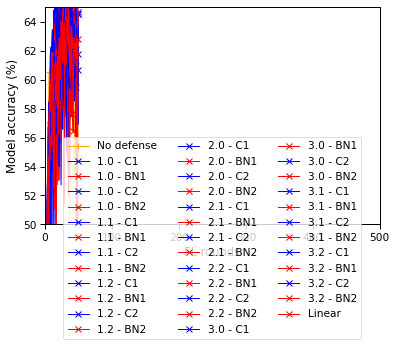

No defense
50
1.0 - C1
50
1.0 - BN1
50
1.0 - C2
50
1.0 - BN2
50
1.1 - C1
50
1.1 - BN1
50
1.1 - C2
50
1.1 - BN2
50
1.2 - C1
50
1.2 - BN1
50
1.2 - C2
50
1.2 - BN2
50
2.0 - C1
50
2.0 - BN1
50
2.0 - C2
50
2.0 - BN2
50
2.1 - C1
50
2.1 - BN1
50
2.1 - C2
50
2.1 - BN2
50
2.2 - C1
50
2.2 - BN1
50
2.2 - C2
50
2.2 - BN2
50
3.0 - C1
50
3.0 - BN1
50
3.0 - C2
50
3.0 - BN2
50
3.1 - C1
50
3.1 - BN1
50
3.1 - C2
50
3.1 - BN2
50
3.2 - C1
50
3.2 - BN1
50
3.2 - C2
50
3.2 - BN2
50
Linear
50


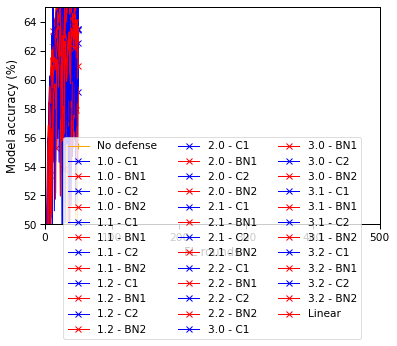

No defense
50
1.0 - C1
50
1.0 - BN1
50
1.0 - C2
50
1.0 - BN2
50
1.1 - C1
50
1.1 - BN1
50
1.1 - C2
50
1.1 - BN2
50
1.2 - C1
50
1.2 - BN1
50
1.2 - C2
50
1.2 - BN2
50
2.0 - C1
50
2.0 - BN1
50
2.0 - C2
50
2.0 - BN2
50
2.1 - C1
50
2.1 - BN1
50
2.1 - C2
50
2.1 - BN2
50
2.2 - C1
50
2.2 - BN1
50
2.2 - C2
50
2.2 - BN2
50
3.0 - C1
50
3.0 - BN1
50
3.0 - C2
50
3.0 - BN2
50
3.1 - C1
50
3.1 - BN1
50
3.1 - C2
50
3.1 - BN2
50
3.2 - C1
50
3.2 - BN1
50
3.2 - C2
50
3.2 - BN2
50
Linear
50


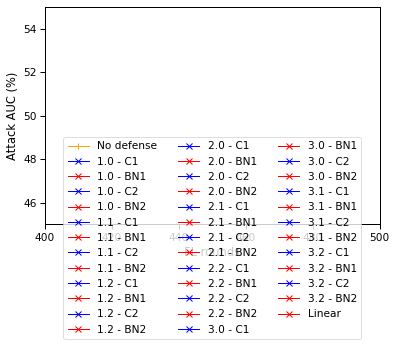

No defense
50
1.0 - C1
50
1.0 - BN1
50
1.0 - C2
50
1.0 - BN2
50
1.1 - C1
50
1.1 - BN1
50
1.1 - C2
50
1.1 - BN2
50
1.2 - C1
50
1.2 - BN1
50
1.2 - C2
50
1.2 - BN2
50
2.0 - C1
50
2.0 - BN1
50
2.0 - C2
50
2.0 - BN2
50
2.1 - C1
50
2.1 - BN1
50
2.1 - C2
50
2.1 - BN2
50
2.2 - C1
50
2.2 - BN1
50
2.2 - C2
50
2.2 - BN2
50
3.0 - C1
50
3.0 - BN1
50
3.0 - C2
50
3.0 - BN2
50
3.1 - C1
50
3.1 - BN1
50
3.1 - C2
50
3.1 - BN2
50
3.2 - C1
50
3.2 - BN1
50
3.2 - C2
50
3.2 - BN2
50
Linear
50


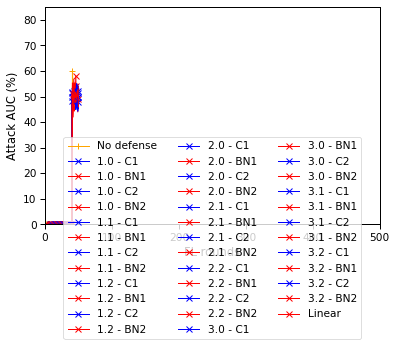

No defense
50
1.0 - C1
50
1.0 - BN1
50
1.0 - C2
50
1.0 - BN2
50
1.1 - C1
50
1.1 - BN1
50
1.1 - C2
50
1.1 - BN2
50
1.2 - C1
50
1.2 - BN1
50
1.2 - C2
50
1.2 - BN2
50
2.0 - C1
50
2.0 - BN1
50
2.0 - C2
50
2.0 - BN2
50
2.1 - C1
50
2.1 - BN1
50
2.1 - C2
50
2.1 - BN2
50
2.2 - C1
50
2.2 - BN1
50
2.2 - C2
50
2.2 - BN2
50
3.0 - C1
50
3.0 - BN1
50
3.0 - C2
50
3.0 - BN2
50
3.1 - C1
50
3.1 - BN1
50
3.1 - C2
50
3.1 - BN2
50
3.2 - C1
50
3.2 - BN1
50
3.2 - C2
50
3.2 - BN2
50
Linear
50


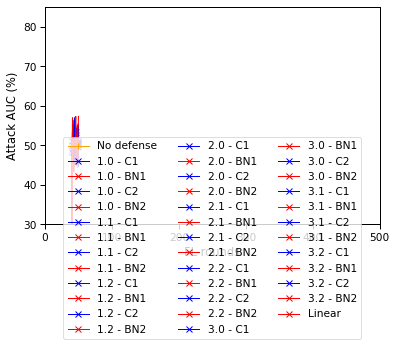

No defense
50
1.0 - C1
50
1.0 - BN1
50
1.0 - C2
50
1.0 - BN2
50
1.1 - C1
50
1.1 - BN1
50
1.1 - C2
50
1.1 - BN2
50
1.2 - C1
50
1.2 - BN1
50
1.2 - C2
50
1.2 - BN2
50
2.0 - C1
50
2.0 - BN1
50
2.0 - C2
50
2.0 - BN2
50
2.1 - C1
50
2.1 - BN1
50
2.1 - C2
50
2.1 - BN2
50
2.2 - C1
50
2.2 - BN1
50
2.2 - C2
50
2.2 - BN2
50
3.0 - C1
50
3.0 - BN1
50
3.0 - C2
50
3.0 - BN2
50
3.1 - C1
50
3.1 - BN1
50
3.1 - C2
50
3.1 - BN2
50
3.2 - C1
50
3.2 - BN1
50
3.2 - C2
50
3.2 - BN2
50
Linear
50


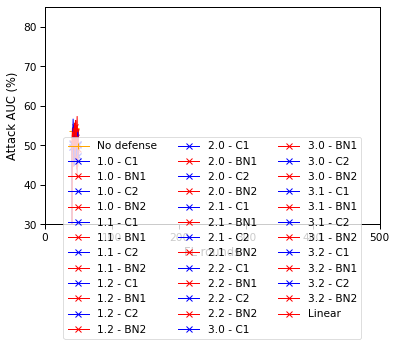

No defense
50
1.0 - C1
50
1.0 - BN1
50
1.0 - C2
50
1.0 - BN2
50
1.1 - C1
50
1.1 - BN1
50
1.1 - C2
50
1.1 - BN2
50
1.2 - C1
50
1.2 - BN1
50
1.2 - C2
50
1.2 - BN2
50
2.0 - C1
50
2.0 - BN1
50
2.0 - C2
50
2.0 - BN2
50
2.1 - C1
50
2.1 - BN1
50
2.1 - C2
50
2.1 - BN2
50
2.2 - C1
50
2.2 - BN1
50
2.2 - C2
50
2.2 - BN2
50
3.0 - C1
50
3.0 - BN1
50
3.0 - C2
50
3.0 - BN2
50
3.1 - C1
50
3.1 - BN1
50
3.1 - C2
50
3.1 - BN2
50
3.2 - C1
50
3.2 - BN1
50
3.2 - C2
50
3.2 - BN2
50
Linear
50


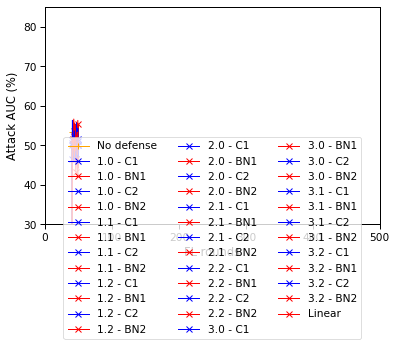

No defense
50
1.0 - C1
50
1.0 - BN1
50
1.0 - C2
50
1.0 - BN2
50
1.1 - C1
50
1.1 - BN1
50
1.1 - C2
50
1.1 - BN2
50
1.2 - C1
50
1.2 - BN1
50
1.2 - C2
50
1.2 - BN2
50
2.0 - C1
50
2.0 - BN1
50
2.0 - C2
50
2.0 - BN2
50
2.1 - C1
50
2.1 - BN1
50
2.1 - C2
50
2.1 - BN2
50
2.2 - C1
50
2.2 - BN1
50
2.2 - C2
50
2.2 - BN2
50
3.0 - C1
50
3.0 - BN1
50
3.0 - C2
50
3.0 - BN2
50
3.1 - C1
50
3.1 - BN1
50
3.1 - C2
50
3.1 - BN2
50
3.2 - C1
50
3.2 - BN1
50
3.2 - C2
50
3.2 - BN2
50
Linear
50


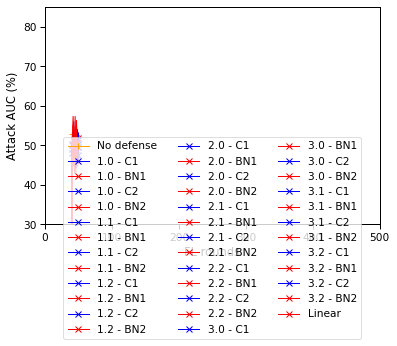

In [46]:
r = 50

generate_histogram(plot_config, "local_model_attack_accuracy_hist", "Attack AUC (%)", "client_auc", 45, 62, average=True, label_rotation=90, std = None, x_fontsize=5, bar_fontsize = 5)
generate_histogram(plot_config, "global_model_attack_accuracy_hist", "Attack AUC (%)", "server_attack", 45, 65, average=True, label_rotation=90, std = None, x_fontsize=5, bar_fontsize = 5)
#generate_xy_plot(plot_config, 'local_models_attack_accuracy', 'Attack AUC (%)', 'client_auc', 0, 100, average=True)
#generate_xy_plot(plot_config, 'global_model_attack_accuracy', 'Attack AUC (%)', 'server_attack', 0, 100, average=True)
#generate_xy_plot(plot_config, 'local_models_accuracy', 'Model accuracy (%)', 'client_accuracy', 0, 100, average=True)
generate_histogram(plot_config, "local_models_accuracy_hist", "Model accuracy (%)", "client_accuracy", 60, 70, average=True, label_rotation=90, x_fontsize=5, bar_fontsize = 5)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy', 'client_auc', 49, 57, 60, 66, average=True, markerscale = 0.5, legend_fontsize=5)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_server', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy', 'server_attack', 49, 52, 60, 66, average=True, markerscale = 0.5, legend_fontsize=5)

generate_xy_plot(plot_config, 'local_model0_accuracy', 'Model accuracy (%)', 'client_accuracy_0', 0, 100, min_x=0, max_x = 50, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model1_accuracy', 'Model accuracy (%)', 'client_accuracy_1', 50, 65, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model2_accuracy', 'Model accuracy (%)', 'client_accuracy_2', 50, 65, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model3_accuracy', 'Model accuracy (%)', 'client_accuracy_3', 50, 65, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model4_accuracy', 'Model accuracy (%)', 'client_accuracy_4', 50, 65, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)

generate_xy_plot(plot_config, 'server_auc', 'Attack AUC (%)', 'server_auc', 45, 55, min_x=400, max_x = 500, average=True,  max_range=r)

generate_xy_plot(plot_config, 'local_model0_auc', 'Attack AUC (%)', 'client_auc_0', 0, 85, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model1_auc', 'Attack AUC (%)', 'client_auc_1', 30, 85, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model2_auc', 'Attack AUC (%)', 'client_auc_2', 30, 85, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model3_auc', 'Attack AUC (%)', 'client_auc_3', 30, 85, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model4_auc', 'Attack AUC (%)', 'client_auc_4', 30, 85, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)

### Layers Analysis GTSRB VGG PASTEL

In [167]:
plot_config = {
                "dataset_name": "gtsrb_vgg_adagrad_layer_analysis",
                "dataset_pretty_name" : "gtsrb_ResNet",

                "data":[

                        {
                            "exp_name" : "No defense",
                            "file_path": "ppm_baseline_gtsrb_vgg.csv",
                            "color": "orange",
                            "symbol" : "+"
                        },
                          {
                            "exp_name" : "1 - C",
                            "file_path": "ppm_pastel_conv_true_adagrad_gtsrb_vgg.csv",
                            "color": "red",
                            "symbol" : "*"
                        },
                                    
                    
                     {
                            "exp_name" : "1 - BN",
                            "file_path": "ppm_pastel_bn1_true_adagrad_gtsrb_vgg.csv",
                            "color": "red",
                            "symbol" : "*"
                        },
                                                                    {
                            "exp_name" : "2 - C",
                            "file_path": "ppm_pastel_conv2_true__adagrad_gtsrb_vgg.csv",
                            "color": "purple",
                            "symbol" : "x"
                        },
                                               
                                                {
                            "exp_name" : "2 - BN",
                            "file_path": "ppm_pastel_bn2_true__adagrad_gtsrb_vgg.csv",
                            "color": "purple",
                            "symbol" : "x"
                        },
                                                                                  {
                            "exp_name" : "3 - C",
                            "file_path": "ppm_pastel_conv3_true_adagrad_gtsrb_vgg.csv",
                            "color": "green",
                            "symbol" : "x"
                        },
                                                              {
                            "exp_name" : "3 - BN",
                            "file_path": "ppm_pastel_bn3_true_adagrad_gtsrb_vgg.csv",
                            "color": "green",
                            "symbol" : "x"
                        },
                    
                                                                                                      {
                            "exp_name" : "4 - C",
                            "file_path": "ppm_pastel_conv4_true_adagrad_gtsrb_vgg.csv",
                            "color": "pink",
                            "symbol" : "x"
                        },
                                                                                                      {
                            "exp_name" : "4 - BN",
                            "file_path": "ppm_pastel_bn4_true_adagrad_gtsrb_vgg.csv",
                            "color": "pink",
                            "symbol" : "x"
                        },
                                                {
                            "exp_name" : "5 - C",
                            "file_path": "ppm_pastel_conv5_true_adagrad_gtsrb_vgg.csv",
                            "color": "yellow",
                            "symbol" : "x"
                        },
                                                                   {
                            "exp_name" : "6 - C",
                            "file_path": "ppm_pastel_conv6_true_adagrad_gtsrb_vgg.csv",
                            "color": "green",
                            "symbol" : "x"
                        },
                                                {
                            "exp_name" : "6 - BN",
                            "file_path": "ppm_pastel_bn6_true_adagrad_gtsrb_vgg.csv",
                            "color": "green",
                            "symbol" : "x"
                        },
                     
                                           {
                            "exp_name" : "7 - C",
                            "file_path": "ppm_pastel_conv7_true_adagrad_gtsrb_vgg.csv",
                            "color": "grey",
                            "symbol" : "x"
                        },
                                           {
                            "exp_name" : "7 - BN",
                            "file_path": "ppm_pastel_bn7_true_adagrad_gtsrb_vgg.csv",
                            "color": "grey",
                            "symbol" : "x"
                        },
                                                                    {
                            "exp_name" : "8 - C",
                            "file_path": "ppm_pastel_conv8_true_adgrad_gtsrb_vgg.csv",
                            "color": "grey",
                            "symbol" : "x"
                                                },
                                                {
                            "exp_name" : "8 - BN",
                            "file_path": "ppm_pastel_bn8_true_adgrad_gtsrb_vgg.csv",
                            "color": "grey",
                            "symbol" : "x"
                                                },
                    
                                                                    {
                            "exp_name" : "FC",
                            "file_path": "ppm_pastel_linear_true_adagrad_gtsrb_vgg.csv",
                            "color": "grey",
                            "symbol" : "x"
                                                },

                    
   
                    
                    
                    ]
                }

Columns to aggregate
['client_auc_3', 'client_auc_0', 'client_auc_4', 'client_auc_1', 'client_auc_2']
[51.84745762711865, 52.82485875706215, 54.51977401129944, 52.9774011299435, 53.954802259887]
Columns to aggregate
['client_auc_3', 'client_auc_0', 'client_auc_4', 'client_auc_1', 'client_auc_2']
[50.0, 50.0, 51.9774011299435, 50.0, 50.0]
Columns to aggregate
['client_auc_3', 'client_auc_0', 'client_auc_4', 'client_auc_1', 'client_auc_2']
[50.0, 50.0, 50.0, 50.0, 50.0]
Columns to aggregate
['client_auc_3', 'client_auc_0', 'client_auc_4', 'client_auc_1', 'client_auc_2']
[50.0, 50.0, 50.0, 50.0, 50.0]
Columns to aggregate
['client_auc_3', 'client_auc_0', 'client_auc_4', 'client_auc_1', 'client_auc_2']
[50.0, 50.0, 50.56497175141244, 50.56497175141242, 50.282485875706215]
Columns to aggregate
['client_auc_3', 'client_auc_0', 'client_auc_4', 'client_auc_1', 'client_auc_2']
[50.56497175141242, 50.0, 50.0, 50.56497175141242, 50.0]
Columns to aggregate
['client_auc_3', 'client_auc_0', 'client_

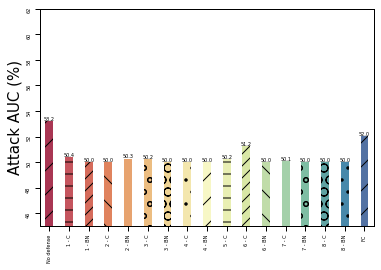

Columns to aggregate
['server_attack']
[51.44774427567445]
Columns to aggregate
['server_attack']
[50.0]
Columns to aggregate
['server_attack']
[50.0]
Columns to aggregate
['server_attack']
[50.0]
Columns to aggregate
['server_attack']
[50.05100884153253]
Columns to aggregate
['server_attack']
[50.0]
Columns to aggregate
['server_attack']
[50.0]
Columns to aggregate
['server_attack']
[50.0]
Columns to aggregate
['server_attack']
[50.0]
Columns to aggregate
['server_attack']
[50.0]
Columns to aggregate
['server_attack']
[50.00566764905917]
Columns to aggregate
['server_attack']
[50.0]
Columns to aggregate
['server_attack']
[50.0]
Columns to aggregate
['server_attack']
[50.0]
Columns to aggregate
['server_attack']
[50.0]
Columns to aggregate
['server_attack']
[50.0]
Columns to aggregate
['server_attack']
[50.6857855361596]
[0.0376845391291765, 0.0017002947177509496, 0.0, 0.0, 0.031269812342175934, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0017002947177509496, 0.0, 0.02063055398231862, 0.0, 0.0, 0.0, 0.

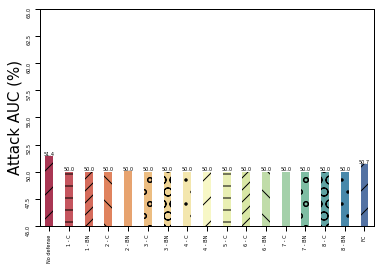

Columns to aggregate
['client_accuracy_3', 'client_accuracy_0', 'client_accuracy_4', 'client_accuracy_1', 'client_accuracy_2']
[98.71911131262752, 98.87780548628427, 99.08184085241442, 98.58308773520744, 98.94581727499433]
Columns to aggregate
['client_accuracy_3', 'client_accuracy_0', 'client_accuracy_4', 'client_accuracy_1', 'client_accuracy_2']
[99.56925867150306, 99.59192926773974, 99.45590569031964, 99.56925867150306, 99.467240988438]
Columns to aggregate
['client_accuracy_3', 'client_accuracy_0', 'client_accuracy_4', 'client_accuracy_1', 'client_accuracy_2']
[99.54658807526638, 99.60326456585808, 99.59192926773974, 99.72795284515983, 99.56925867150306]
Columns to aggregate
['client_accuracy_3', 'client_accuracy_0', 'client_accuracy_4', 'client_accuracy_1', 'client_accuracy_2']
[99.47857628655636, 99.55792337338472, 99.59192926773974, 99.55792337338472, 99.51258218091137]
Columns to aggregate
['client_accuracy_3', 'client_accuracy_0', 'client_accuracy_4', 'client_accuracy_1', 'cli

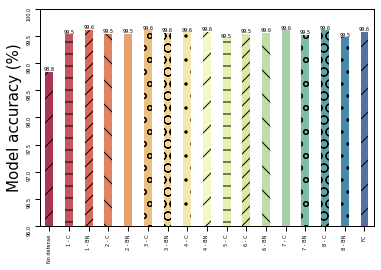

Columns to aggregate
['client_accuracy_3', 'client_accuracy_0', 'client_accuracy_4', 'client_accuracy_1', 'client_accuracy_2']
[98.71911131262752, 98.87780548628427, 99.08184085241442, 98.58308773520744, 98.94581727499433]
Columns to aggregate
['client_auc_3', 'client_auc_0', 'client_auc_4', 'client_auc_1', 'client_auc_2']
[51.84745762711865, 52.82485875706215, 54.51977401129944, 52.9774011299435, 53.954802259887]
Columns to aggregate
['client_accuracy_3', 'client_accuracy_0', 'client_accuracy_4', 'client_accuracy_1', 'client_accuracy_2']
[99.56925867150306, 99.59192926773974, 99.45590569031964, 99.56925867150306, 99.467240988438]
Columns to aggregate
['client_auc_3', 'client_auc_0', 'client_auc_4', 'client_auc_1', 'client_auc_2']
[50.0, 50.0, 51.9774011299435, 50.0, 50.0]
Columns to aggregate
['client_accuracy_3', 'client_accuracy_0', 'client_accuracy_4', 'client_accuracy_1', 'client_accuracy_2']
[99.54658807526638, 99.60326456585808, 99.59192926773974, 99.72795284515983, 99.569258671

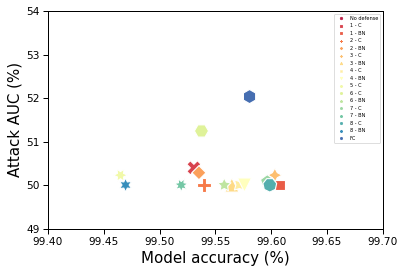

Columns to aggregate
['client_accuracy_3', 'client_accuracy_0', 'client_accuracy_4', 'client_accuracy_1', 'client_accuracy_2']
[98.71911131262752, 98.87780548628427, 99.08184085241442, 98.58308773520744, 98.94581727499433]
Columns to aggregate
['server_attack']
[51.44774427567445]
Columns to aggregate
['client_accuracy_3', 'client_accuracy_0', 'client_accuracy_4', 'client_accuracy_1', 'client_accuracy_2']
[99.56925867150306, 99.59192926773974, 99.45590569031964, 99.56925867150306, 99.467240988438]
Columns to aggregate
['server_attack']
[50.0]
Columns to aggregate
['client_accuracy_3', 'client_accuracy_0', 'client_accuracy_4', 'client_accuracy_1', 'client_accuracy_2']
[99.54658807526638, 99.60326456585808, 99.59192926773974, 99.72795284515983, 99.56925867150306]
Columns to aggregate
['server_attack']
[50.0]
Columns to aggregate
['client_accuracy_3', 'client_accuracy_0', 'client_accuracy_4', 'client_accuracy_1', 'client_accuracy_2']
[99.47857628655636, 99.55792337338472, 99.5919292677397

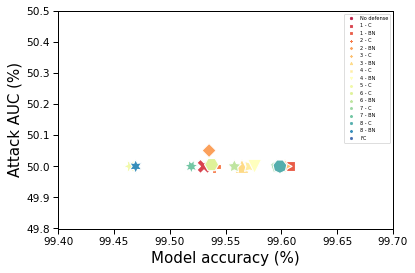

No defense
50
1 - C
50
1 - BN
50
2 - C
50
2 - BN
50
3 - C
50
3 - BN
50
4 - C
50
4 - BN
50
5 - C
50
6 - C
50
6 - BN
50
7 - C
50
7 - BN
50
8 - C
50
8 - BN
50
FC
50


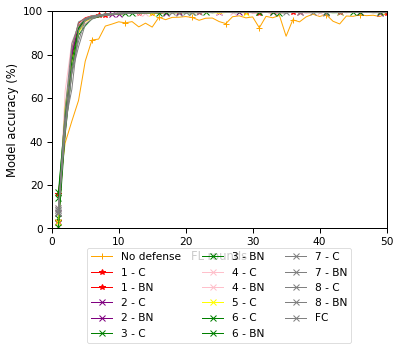

No defense
50
1 - C
50
1 - BN
50
2 - C
50
2 - BN
50
3 - C
50
3 - BN
50
4 - C
50
4 - BN
50
5 - C
50
6 - C
50
6 - BN
50
7 - C
50
7 - BN
50
8 - C
50
8 - BN
50
FC
50


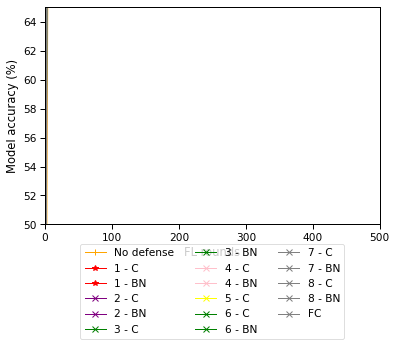

No defense
50
1 - C
50
1 - BN
50
2 - C
50
2 - BN
50
3 - C
50
3 - BN
50
4 - C
50
4 - BN
50
5 - C
50
6 - C
50
6 - BN
50
7 - C
50
7 - BN
50
8 - C
50
8 - BN
50
FC
50


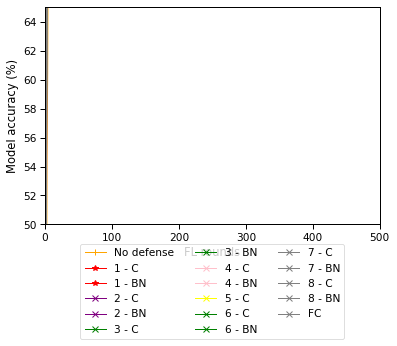

No defense
50
1 - C
50
1 - BN
50
2 - C
50
2 - BN
50
3 - C
50
3 - BN
50
4 - C
50
4 - BN
50
5 - C
50
6 - C
50
6 - BN
50
7 - C
50
7 - BN
50
8 - C
50
8 - BN
50
FC
50


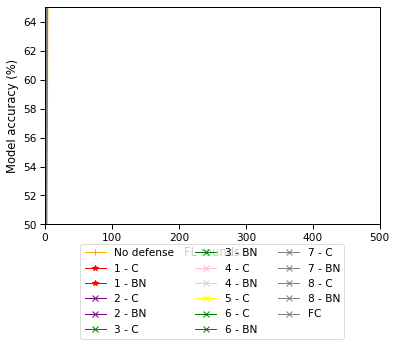

No defense
50
1 - C
50
1 - BN
50
2 - C
50
2 - BN
50
3 - C
50
3 - BN
50
4 - C
50
4 - BN
50
5 - C
50
6 - C
50
6 - BN
50
7 - C
50
7 - BN
50
8 - C
50
8 - BN
50
FC
50


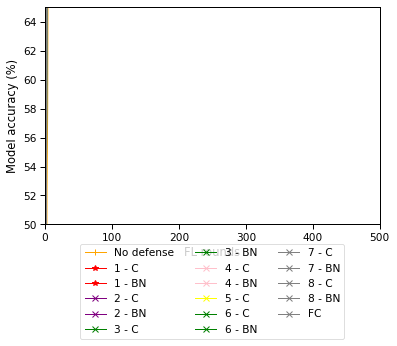

No defense
50
1 - C
50
1 - BN
50
2 - C
50
2 - BN
50
3 - C
50
3 - BN
50
4 - C
50
4 - BN
50
5 - C
50
6 - C
50
6 - BN
50
7 - C
50
7 - BN
50
8 - C
50
8 - BN
50
FC
50


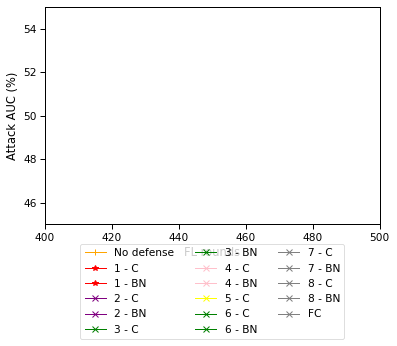

No defense
50
1 - C
50
1 - BN
50
2 - C
50
2 - BN
50
3 - C
50
3 - BN
50
4 - C
50
4 - BN
50
5 - C
50
6 - C
50
6 - BN
50
7 - C
50
7 - BN
50
8 - C
50
8 - BN
50
FC
50


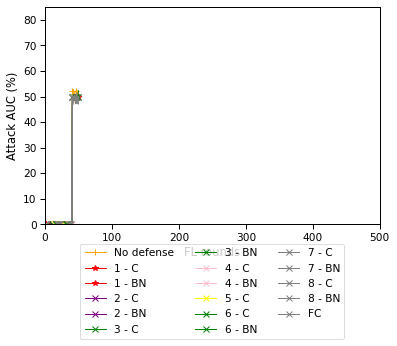

No defense
50
1 - C
50
1 - BN
50
2 - C
50
2 - BN
50
3 - C
50
3 - BN
50
4 - C
50
4 - BN
50
5 - C
50
6 - C
50
6 - BN
50
7 - C
50
7 - BN
50
8 - C
50
8 - BN
50
FC
50


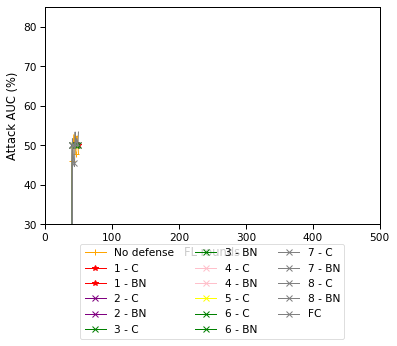

No defense
50
1 - C
50
1 - BN
50
2 - C
50
2 - BN
50
3 - C
50
3 - BN
50
4 - C
50
4 - BN
50
5 - C
50
6 - C
50
6 - BN
50
7 - C
50
7 - BN
50
8 - C
50
8 - BN
50
FC
50


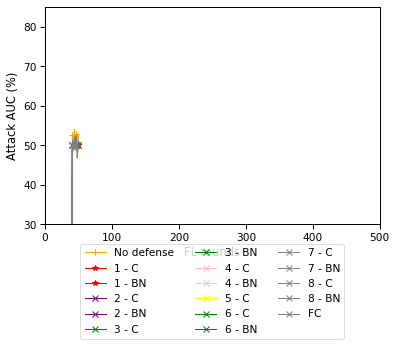

No defense
50
1 - C
50
1 - BN
50
2 - C
50
2 - BN
50
3 - C
50
3 - BN
50
4 - C
50
4 - BN
50
5 - C
50
6 - C
50
6 - BN
50
7 - C
50
7 - BN
50
8 - C
50
8 - BN
50
FC
50


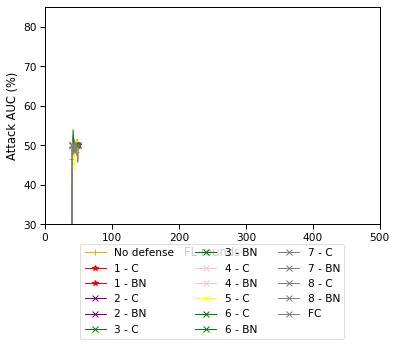

No defense
50
1 - C
50
1 - BN
50
2 - C
50
2 - BN
50
3 - C
50
3 - BN
50
4 - C
50
4 - BN
50
5 - C
50
6 - C
50
6 - BN
50
7 - C
50
7 - BN
50
8 - C
50
8 - BN
50
FC
50


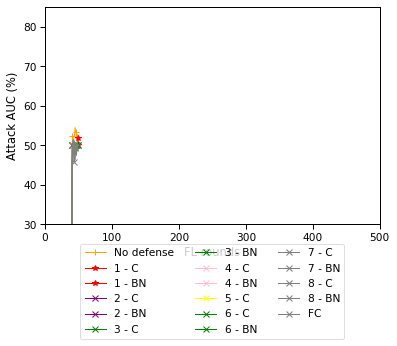

In [168]:
r = 50

generate_histogram(plot_config, "local_model_attack_accuracy_hist", "Attack AUC (%)", "client_auc", 45, 62, average=True, label_rotation=90, std = None, x_fontsize=5, bar_fontsize = 5)
generate_histogram(plot_config, "global_model_attack_accuracy_hist", "Attack AUC (%)", "server_attack", 45, 65, average=True, label_rotation=90, std = None, x_fontsize=5, bar_fontsize = 5)
#generate_xy_plot(plot_config, 'local_models_attack_accuracy', 'Attack AUC (%)', 'client_auc', 0, 100, average=True)
#generate_xy_plot(plot_config, 'global_model_attack_accuracy', 'Attack AUC (%)', 'server_attack', 0, 100, average=True)
#generate_xy_plot(plot_config, 'local_models_accuracy', 'Model accuracy (%)', 'client_accuracy', 0, 100, average=True)
generate_histogram(plot_config, "local_models_accuracy_hist", "Model accuracy (%)", "client_accuracy", 96, 100, average=True, label_rotation=90, x_fontsize=5, bar_fontsize = 5)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy', 'client_auc', 49, 54, 99.4, 99.7, average=True, markerscale = 0.5, legend_fontsize=5)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_server', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy', 'server_attack', 49.8, 50.5, 99.4 , 99.7, average=True, markerscale = 0.5, legend_fontsize=5)

generate_xy_plot(plot_config, 'local_model0_accuracy', 'Model accuracy (%)', 'client_accuracy_0', 0, 100, min_x=0, max_x = 50, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model1_accuracy', 'Model accuracy (%)', 'client_accuracy_1', 50, 65, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model2_accuracy', 'Model accuracy (%)', 'client_accuracy_2', 50, 65, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model3_accuracy', 'Model accuracy (%)', 'client_accuracy_3', 50, 65, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model4_accuracy', 'Model accuracy (%)', 'client_accuracy_4', 50, 65, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)

generate_xy_plot(plot_config, 'server_auc', 'Attack AUC (%)', 'server_auc', 45, 55, min_x=400, max_x = 500, average=True,  max_range=r)

generate_xy_plot(plot_config, 'local_model0_auc', 'Attack AUC (%)', 'client_auc_0', 0, 85, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model1_auc', 'Attack AUC (%)', 'client_auc_1', 30, 85, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model2_auc', 'Attack AUC (%)', 'client_auc_2', 30, 85, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model3_auc', 'Attack AUC (%)', 'client_auc_3', 30, 85, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model4_auc', 'Attack AUC (%)', 'client_auc_4', 30, 85, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)

### Layers Analysis GTSRB - ResNet - PASTEL

In [159]:
          plot_config = {
                "dataset_name": "gtsrb_resnet_layer_analysis_adagrad",
                "dataset_pretty_name" : "gtsrb_ResNet",

                "data":[

                                            {
                            "exp_name" : "No defense",
                            "file_path": "ppm_baseline_gtsrb_resnet.csv",
                            "color": "orange",
                            "symbol" : "+"
                        },


                    {
                            "exp_name" : "1.0 - C1",
                            "file_path": "ppm_pastel_layer1.0_conv1_true_adagrad_gtsrb_resnet.csv",
                            "color": "blue",
                            "symbol" : "x"
                        },

                                                                {
                            "exp_name" : "1.0 - BN1",
                            "file_path": "ppm_pastel_layer1.0_bn1_true_adagrad_gtsrb_resnet.csv",
                            "color": "red",
                            "symbol" : "x"
                        },

                                        {
                            "exp_name" : "1.0 - C2",
                            "file_path": "ppm_pastel_layer1.0_conv2_true_adagrad_gtsrb_resnet.csv",
                            "color": "blue",
                            "symbol" : "x"
                        },

                                                                {
                            "exp_name" : "1.0 - BN2",
                            "file_path": "ppm_pastel_layer1.0_bn2_true_adagrad_gtsrb_resnet.csv",
                            "color": "red",
                            "symbol" : "x"
                        },


                                      {
                            "exp_name" : "1.1 - C1",
                            "file_path": "ppm_pastel_layer1.0_conv1_true_adagrad_gtsrb_resnet.csv",
                            "color": "blue",
                            "symbol" : "x"
                        },

                                                                {
                            "exp_name" : "1.1 - BN1",
                            "file_path": "ppm_pastel_layer1.1_bn1_true_adagrad_gtsrb_resnet.csv",
                            "color": "red",
                            "symbol" : "x"
                        },

                                        {
                            "exp_name" : "1.1 - C2",
                            "file_path": "ppm_pastel_layer1.0_conv2_true_adagrad_gtsrb_resnet.csv",
                            "color": "blue",
                            "symbol" : "x"
                        },

                                                                {
                            "exp_name" : "1.1 - BN2",
                            "file_path": "ppm_pastel_layer1.1_bn2_true_adagrad_gtsrb_resnet.csv",
                            "color": "red",
                            "symbol" : "x"
                        },


                                      {
                            "exp_name" : "1.2 - C1",
                            "file_path": "ppm_pastel_layer1.2_conv1_true_adagrad_gtsrb_resnet.csv",
                            "color": "blue",
                            "symbol" : "x"
                        },

                                                                {
                            "exp_name" : "1.2 - BN1",
                            "file_path": "ppm_pastel_layer1.2_bn1_true_adagrad_gtsrb_resnet.csv",
                            "color": "red",
                            "symbol" : "x"
                        },

                                        {
                            "exp_name" : "1.2 - C2",
                            "file_path": "ppm_pastel_layer1.2_conv2_true_adagrad_gtsrb_resnet.csv",
                            "color": "blue",
                            "symbol" : "x"
                        },

                                                                {
                            "exp_name" : "1.2 - BN2",
                            "file_path": "ppm_pastel_layer1.2_bn2_true_adagrad_gtsrb_resnet.csv",
                            "color": "red",
                            "symbol" : "x"
                        },



                                      {
                            "exp_name" : "2.0 - C1",
                            "file_path": "ppm_pastel_layer2.0_conv1_true_adagrad_gtsrb_resnet.csv",
                            "color": "blue",
                            "symbol" : "x"
                        },

                                                                {
                            "exp_name" : "2.0 - BN1",
                            "file_path": "ppm_pastel_layer2.0_bn1_true_adagrad_gtsrb_resnet.csv",
                            "color": "red",
                            "symbol" : "x"
                        },

                                        {
                            "exp_name" : "2.0 - C2",
                            "file_path": "ppm_pastel_layer2.0_conv2_true_adagrad_gtsrb_resnet.csv",
                            "color": "blue",
                            "symbol" : "x"
                        },

                                                                {
                            "exp_name" : "2.0 - BN2",
                            "file_path": "ppm_pastel_layer2.0_bn2_true_adagrad_gtsrb_resnet.csv",
                            "color": "red",
                            "symbol" : "x"
                        },


                                      {
                            "exp_name" : "2.1 - C1",
                            "file_path": "ppm_pastel_layer2.1_conv2_true_adagrad_gtsrb_resnet.csv",
                            "color": "blue",
                            "symbol" : "x"
                        },

                                                                {
                            "exp_name" : "2.1 - BN1",
                            "file_path": "ppm_pastel_layer2.1_bn2_true_adagrad_gtsrb_resnet.csv",
                            "color": "red",
                            "symbol" : "x"
                        },

                                        {
                            "exp_name" : "2.1 - C2",
                            "file_path": "ppm_pastel_layer2.1_conv2_true_adagrad_gtsrb_resnet.csv",
                            "color": "blue",
                            "symbol" : "x"
                        },

                                                                {
                            "exp_name" : "2.1 - BN2",
                            "file_path": "ppm_pastel_layer2.1_bn2_true_adagrad_gtsrb_resnet.csv",
                            "color": "red",
                            "symbol" : "x"
                        },


                                      {
                            "exp_name" : "2.2 - C1",
                            "file_path": "ppm_pastel_layer2.2_conv1_true_adagrad_gtsrb_resnet.csv",
                            "color": "blue",
                            "symbol" : "x"
                        },

                                                                {
                            "exp_name" : "2.2 - BN1",
                            "file_path": "ppm_pastel_layer2.2_bn1_true_adagrad_gtsrb_resnet.csv",
                            "color": "red",
                            "symbol" : "x"
                        },

                                        {
                            "exp_name" : "2.2 - C2",
                            "file_path": "ppm_pastel_layer2.2_conv2_true_adagrad_gtsrb_resnet.csv",
                            "color": "blue",
                            "symbol" : "x"
                        },

                                                                {
                            "exp_name" : "2.2 - BN2",
                            "file_path": "ppm_pastel_layer2.2_bn2_true_adagrad_gtsrb_resnet.csv",
                            "color": "red",
                            "symbol" : "x"
                        },


                                      {
                            "exp_name" : "3.0 - C1",
                            "file_path": "ppm_pastel_layer3.0_conv1_true_adagrad_gtsrb_resnet.csv",
                            "color": "blue",
                            "symbol" : "x"
                        },

                                                                {
                            "exp_name" : "3.0 - BN1",
                            "file_path": "ppm_pastel_layer3.0_bn1_true_adagrad_gtsrb_resnet.csv",
                            "color": "red",
                            "symbol" : "x"
                        },

                                        {
                            "exp_name" : "3.0 - C2",
                            "file_path": "ppm_pastel_layer3.0_conv2_true_adagrad_gtsrb_resnet.csv",
                            "color": "blue",
                            "symbol" : "x"
                        },

                                                                {
                            "exp_name" : "3.0 - BN2",
                            "file_path": "ppm_pastel_layer3.0_bn2_true_adagrad_gtsrb_resnet.csv",
                            "color": "red",
                            "symbol" : "x"
                        },


                                      {
                            "exp_name" : "3.1 - C1",
                            "file_path": "ppm_pastel_layer3.0_conv1_true_adagrad_gtsrb_resnet.csv",
                            "color": "blue",
                            "symbol" : "x"
                        },

                                                                {
                            "exp_name" : "3.1 - BN1",
                            "file_path": "ppm_pastel_layer3.1_bn1_true_adagrad_gtsrb_resnet.csv",
                            "color": "red",
                            "symbol" : "x"
                        },

                                        {
                            "exp_name" : "3.1 - C2",
                            "file_path": "ppm_pastel_layer3.0_conv2_true_adagrad_gtsrb_resnet.csv",
                            "color": "blue",
                            "symbol" : "x"
                        },

                                                                {
                            "exp_name" : "3.1 - BN2",
                            "file_path": "ppm_pastel_layer3.1_bn2_true_adagrad_gtsrb_resnet.csv",
                            "color": "red",
                            "symbol" : "x"
                        },


                                      {
                            "exp_name" : "3.2 - C1",
                            "file_path": "ppm_pastel_layer3.2_conv1_true_adagrad_gtsrb_resnet.csv",
                            "color": "blue",
                            "symbol" : "x"
                        },

                                                                {
                            "exp_name" : "3.2 - BN1",
                            "file_path": "ppm_pastel_layer3.2_bn1_true_adagrad_gtsrb_resnet.csv",
                            "color": "red",
                            "symbol" : "x"
                        },

                                        {
                            "exp_name" : "3.2 - C2",
                            "file_path": "ppm_pastel_layer3.2_conv2_true_adagrad_gtsrb_resnet.csv",
                            "color": "blue",
                            "symbol" : "x"
                        },

                                                                {
                            "exp_name" : "3.2 - BN2",
                            "file_path": "ppm_pastel_layer3.2_bn2_true_adagrad_gtsrb_resnet.csv",
                            "color": "red",
                            "symbol" : "x"
                        }
                ]
          }



                    
                    
                    

Columns to aggregate
['client_auc_3', 'client_auc_0', 'client_auc_4', 'client_auc_1', 'client_auc_2']
[55.08474576271188, 52.82485875706215, 51.9774011299435, 54.51977401129944, 55.08474576271186]
Columns to aggregate
['client_auc_3', 'client_auc_0', 'client_auc_4', 'client_auc_1', 'client_auc_2']
[53.954802259887, 53.954802259887, 55.08474576271188, 53.95480225988701, 54.80225988700565]
Columns to aggregate
['client_auc_3', 'client_auc_0', 'client_auc_4', 'client_auc_1', 'client_auc_2']
[52.25988700564972, 50.56497175141244, 50.84745762711865, 52.25988700564972, 51.41242937853108]
Columns to aggregate
['client_auc_3', 'client_auc_0', 'client_auc_4', 'client_auc_1', 'client_auc_2']
[52.25988700564972, 53.10734463276836, 53.10734463276836, 50.84745762711865, 52.25988700564972]
Columns to aggregate
['client_auc_3', 'client_auc_0', 'client_auc_4', 'client_auc_1', 'client_auc_2']
[52.54237288135594, 52.82485875706215, 53.38983050847458, 53.10734463276836, 53.672316384180775]
Columns to agg

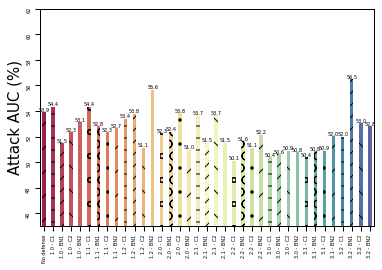

Columns to aggregate
['server_attack']
[51.088188619360686]
Columns to aggregate
['server_attack']
[50.47041487191113]
Columns to aggregate
['server_attack']
[50.11335298118341]
Columns to aggregate
['server_attack']
[50.2097030151893]
Columns to aggregate
['server_attack']
[50.50442076626616]
Columns to aggregate
['server_attack']
[50.47041487191113]
Columns to aggregate
['server_attack']
[50.65744729086376]
Columns to aggregate
['server_attack']
[50.2097030151893]
Columns to aggregate
['server_attack']
[50.238041260485154]
Columns to aggregate
['server_attack']
[50.28905010201768]
Columns to aggregate
['server_attack']
[50.77646792110633]
Columns to aggregate
['server_attack']
[50.3627295397869]
Columns to aggregate
['server_attack']
[50.86715030605304]
Columns to aggregate
['server_attack']
[50.56676490591703]
Columns to aggregate
['server_attack']
[50.48175017002947]
Columns to aggregate
['server_attack']
[50.36839718884607]
Columns to aggregate
['server_attack']
[50.13035592836091

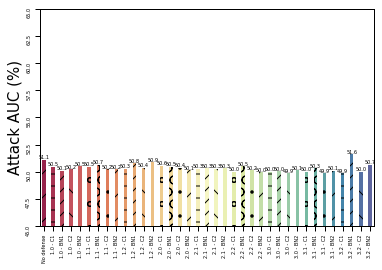

Columns to aggregate
['client_accuracy_3', 'client_accuracy_0', 'client_accuracy_4', 'client_accuracy_1', 'client_accuracy_2']
[99.13851734300611, 98.95715257311268, 99.0478349580594, 99.26320562230786, 98.95715257311268]
Columns to aggregate
['client_accuracy_3', 'client_accuracy_0', 'client_accuracy_4', 'client_accuracy_1', 'client_accuracy_2']
[97.63092269326684, 97.75561097256858, 97.77828156880526, 97.52890501020175, 97.8236227612786]
Columns to aggregate
['client_accuracy_3', 'client_accuracy_0', 'client_accuracy_4', 'client_accuracy_1', 'client_accuracy_2']
[98.36771707095896, 98.60575833144412, 98.29970528224892, 98.2656993878939, 98.1296758104738]
Columns to aggregate
['client_accuracy_3', 'client_accuracy_0', 'client_accuracy_4', 'client_accuracy_1', 'client_accuracy_2']
[98.2656993878939, 98.29970528224892, 98.35638177284063, 98.08433461800044, 98.16368170482885]
Columns to aggregate
['client_accuracy_3', 'client_accuracy_0', 'client_accuracy_4', 'client_accuracy_1', 'client

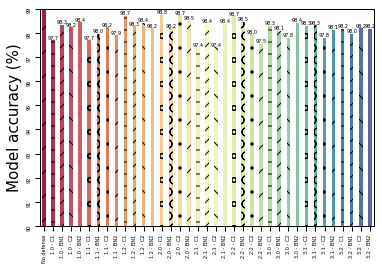

Columns to aggregate
['client_accuracy_3', 'client_accuracy_0', 'client_accuracy_4', 'client_accuracy_1', 'client_accuracy_2']
[99.13851734300611, 98.95715257311268, 99.0478349580594, 99.26320562230786, 98.95715257311268]
Columns to aggregate
['client_auc_3', 'client_auc_0', 'client_auc_4', 'client_auc_1', 'client_auc_2']
[55.08474576271188, 52.82485875706215, 51.9774011299435, 54.51977401129944, 55.08474576271186]
Columns to aggregate
['client_accuracy_3', 'client_accuracy_0', 'client_accuracy_4', 'client_accuracy_1', 'client_accuracy_2']
[97.63092269326684, 97.75561097256858, 97.77828156880526, 97.52890501020175, 97.8236227612786]
Columns to aggregate
['client_auc_3', 'client_auc_0', 'client_auc_4', 'client_auc_1', 'client_auc_2']
[53.954802259887, 53.954802259887, 55.08474576271188, 53.95480225988701, 54.80225988700565]
Columns to aggregate
['client_accuracy_3', 'client_accuracy_0', 'client_accuracy_4', 'client_accuracy_1', 'client_accuracy_2']
[98.36771707095896, 98.60575833144412,

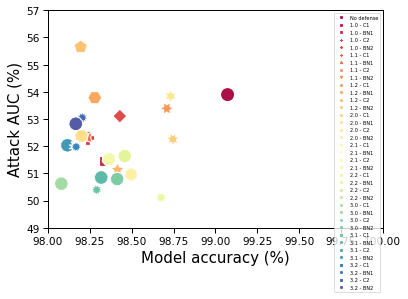

Columns to aggregate
['client_accuracy_3', 'client_accuracy_0', 'client_accuracy_4', 'client_accuracy_1', 'client_accuracy_2']
[99.13851734300611, 98.95715257311268, 99.0478349580594, 99.26320562230786, 98.95715257311268]
Columns to aggregate
['server_attack']
[51.088188619360686]
Columns to aggregate
['client_accuracy_3', 'client_accuracy_0', 'client_accuracy_4', 'client_accuracy_1', 'client_accuracy_2']
[97.63092269326684, 97.75561097256858, 97.77828156880526, 97.52890501020175, 97.8236227612786]
Columns to aggregate
['server_attack']
[50.47041487191113]
Columns to aggregate
['client_accuracy_3', 'client_accuracy_0', 'client_accuracy_4', 'client_accuracy_1', 'client_accuracy_2']
[98.36771707095896, 98.60575833144412, 98.29970528224892, 98.2656993878939, 98.1296758104738]
Columns to aggregate
['server_attack']
[50.11335298118341]
Columns to aggregate
['client_accuracy_3', 'client_accuracy_0', 'client_accuracy_4', 'client_accuracy_1', 'client_accuracy_2']
[98.2656993878939, 98.29970528

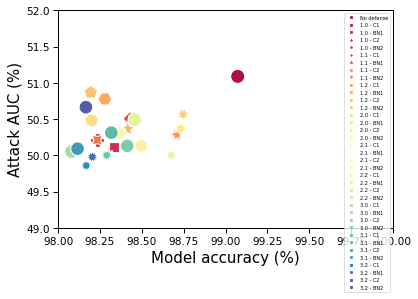

No defense
50
1.0 - C1
50
1.0 - BN1
50
1.0 - C2
50
1.0 - BN2
50
1.1 - C1
50
1.1 - BN1
50
1.1 - C2
50
1.1 - BN2
50
1.2 - C1
50
1.2 - BN1
50
1.2 - C2
50
1.2 - BN2
50
2.0 - C1
50
2.0 - BN1
50
2.0 - C2
50
2.0 - BN2
50
2.1 - C1
50
2.1 - BN1
50
2.1 - C2
50
2.1 - BN2
50
2.2 - C1
50
2.2 - BN1
50
2.2 - C2
50
2.2 - BN2
50
3.0 - C1
50
3.0 - BN1
50
3.0 - C2
50
3.0 - BN2
50
3.1 - C1
50
3.1 - BN1
50
3.1 - C2
50
3.1 - BN2
50
3.2 - C1
50
3.2 - BN1
50
3.2 - C2
50
3.2 - BN2
50


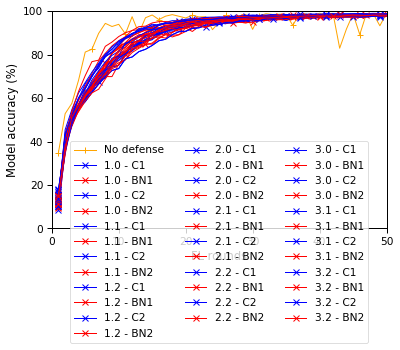

No defense
50
1.0 - C1
50
1.0 - BN1
50
1.0 - C2
50
1.0 - BN2
50
1.1 - C1
50
1.1 - BN1
50
1.1 - C2
50
1.1 - BN2
50
1.2 - C1
50
1.2 - BN1
50
1.2 - C2
50
1.2 - BN2
50
2.0 - C1
50
2.0 - BN1
50
2.0 - C2
50
2.0 - BN2
50
2.1 - C1
50
2.1 - BN1
50
2.1 - C2
50
2.1 - BN2
50
2.2 - C1
50
2.2 - BN1
50
2.2 - C2
50
2.2 - BN2
50
3.0 - C1
50
3.0 - BN1
50
3.0 - C2
50
3.0 - BN2
50
3.1 - C1
50
3.1 - BN1
50
3.1 - C2
50
3.1 - BN2
50
3.2 - C1
50
3.2 - BN1
50
3.2 - C2
50
3.2 - BN2
50


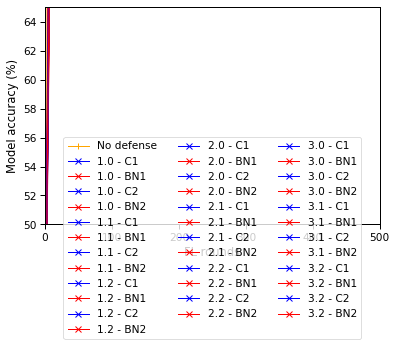

No defense
50
1.0 - C1
50
1.0 - BN1
50
1.0 - C2
50
1.0 - BN2
50
1.1 - C1
50
1.1 - BN1
50
1.1 - C2
50
1.1 - BN2
50
1.2 - C1
50
1.2 - BN1
50
1.2 - C2
50
1.2 - BN2
50
2.0 - C1
50
2.0 - BN1
50
2.0 - C2
50
2.0 - BN2
50
2.1 - C1
50
2.1 - BN1
50
2.1 - C2
50
2.1 - BN2
50
2.2 - C1
50
2.2 - BN1
50
2.2 - C2
50
2.2 - BN2
50
3.0 - C1
50
3.0 - BN1
50
3.0 - C2
50
3.0 - BN2
50
3.1 - C1
50
3.1 - BN1
50
3.1 - C2
50
3.1 - BN2
50
3.2 - C1
50
3.2 - BN1
50
3.2 - C2
50
3.2 - BN2
50


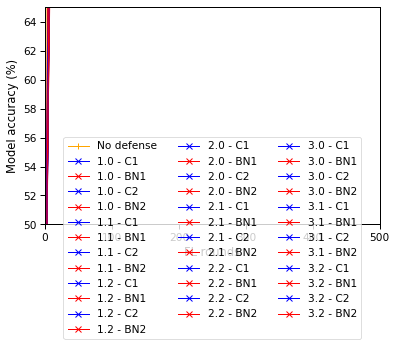

No defense
50
1.0 - C1
50
1.0 - BN1
50
1.0 - C2
50
1.0 - BN2
50
1.1 - C1
50
1.1 - BN1
50
1.1 - C2
50
1.1 - BN2
50
1.2 - C1
50
1.2 - BN1
50
1.2 - C2
50
1.2 - BN2
50
2.0 - C1
50
2.0 - BN1
50
2.0 - C2
50
2.0 - BN2
50
2.1 - C1
50
2.1 - BN1
50
2.1 - C2
50
2.1 - BN2
50
2.2 - C1
50
2.2 - BN1
50
2.2 - C2
50
2.2 - BN2
50
3.0 - C1
50
3.0 - BN1
50
3.0 - C2
50
3.0 - BN2
50
3.1 - C1
50
3.1 - BN1
50
3.1 - C2
50
3.1 - BN2
50
3.2 - C1
50
3.2 - BN1
50
3.2 - C2
50
3.2 - BN2
50


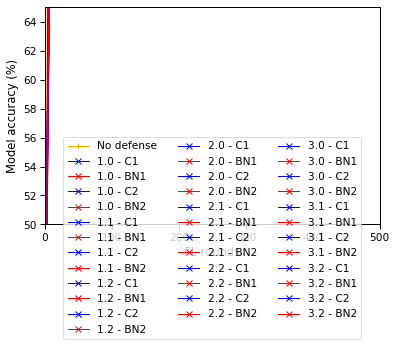

No defense
50
1.0 - C1
50
1.0 - BN1
50
1.0 - C2
50
1.0 - BN2
50
1.1 - C1
50
1.1 - BN1
50
1.1 - C2
50
1.1 - BN2
50
1.2 - C1
50
1.2 - BN1
50
1.2 - C2
50
1.2 - BN2
50
2.0 - C1
50
2.0 - BN1
50
2.0 - C2
50
2.0 - BN2
50
2.1 - C1
50
2.1 - BN1
50
2.1 - C2
50
2.1 - BN2
50
2.2 - C1
50
2.2 - BN1
50
2.2 - C2
50
2.2 - BN2
50
3.0 - C1
50
3.0 - BN1
50
3.0 - C2
50
3.0 - BN2
50
3.1 - C1
50
3.1 - BN1
50
3.1 - C2
50
3.1 - BN2
50
3.2 - C1
50
3.2 - BN1
50
3.2 - C2
50
3.2 - BN2
50


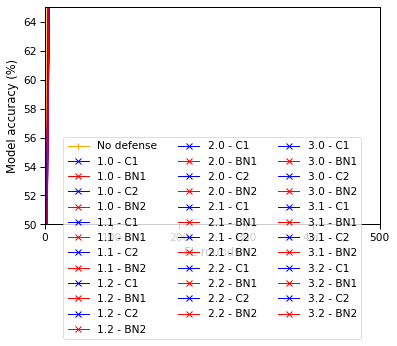

No defense
50
1.0 - C1
50
1.0 - BN1
50
1.0 - C2
50
1.0 - BN2
50
1.1 - C1
50
1.1 - BN1
50
1.1 - C2
50
1.1 - BN2
50
1.2 - C1
50
1.2 - BN1
50
1.2 - C2
50
1.2 - BN2
50
2.0 - C1
50
2.0 - BN1
50
2.0 - C2
50
2.0 - BN2
50
2.1 - C1
50
2.1 - BN1
50
2.1 - C2
50
2.1 - BN2
50
2.2 - C1
50
2.2 - BN1
50
2.2 - C2
50
2.2 - BN2
50
3.0 - C1
50
3.0 - BN1
50
3.0 - C2
50
3.0 - BN2
50
3.1 - C1
50
3.1 - BN1
50
3.1 - C2
50
3.1 - BN2
50
3.2 - C1
50
3.2 - BN1
50
3.2 - C2
50
3.2 - BN2
50


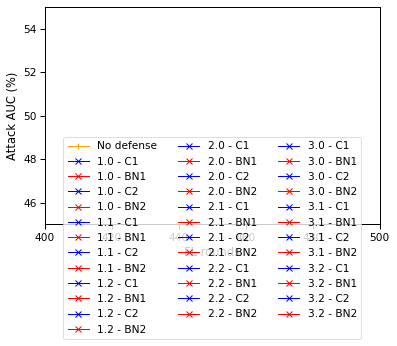

No defense
50
1.0 - C1
50
1.0 - BN1
50
1.0 - C2
50
1.0 - BN2
50
1.1 - C1
50
1.1 - BN1
50
1.1 - C2
50
1.1 - BN2
50
1.2 - C1
50
1.2 - BN1
50
1.2 - C2
50
1.2 - BN2
50
2.0 - C1
50
2.0 - BN1
50
2.0 - C2
50
2.0 - BN2
50
2.1 - C1
50
2.1 - BN1
50
2.1 - C2
50
2.1 - BN2
50
2.2 - C1
50
2.2 - BN1
50
2.2 - C2
50
2.2 - BN2
50
3.0 - C1
50
3.0 - BN1
50
3.0 - C2
50
3.0 - BN2
50
3.1 - C1
50
3.1 - BN1
50
3.1 - C2
50
3.1 - BN2
50
3.2 - C1
50
3.2 - BN1
50
3.2 - C2
50
3.2 - BN2
50


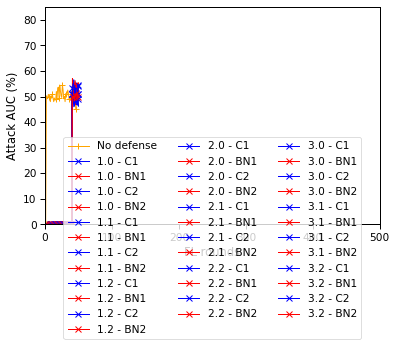

No defense
50
1.0 - C1
50
1.0 - BN1
50
1.0 - C2
50
1.0 - BN2
50
1.1 - C1
50
1.1 - BN1
50
1.1 - C2
50
1.1 - BN2
50
1.2 - C1
50
1.2 - BN1
50
1.2 - C2
50
1.2 - BN2
50
2.0 - C1
50
2.0 - BN1
50
2.0 - C2
50
2.0 - BN2
50
2.1 - C1
50
2.1 - BN1
50
2.1 - C2
50
2.1 - BN2
50
2.2 - C1
50
2.2 - BN1
50
2.2 - C2
50
2.2 - BN2
50
3.0 - C1
50
3.0 - BN1
50
3.0 - C2
50
3.0 - BN2
50
3.1 - C1
50
3.1 - BN1
50
3.1 - C2
50
3.1 - BN2
50
3.2 - C1
50
3.2 - BN1
50
3.2 - C2
50
3.2 - BN2
50


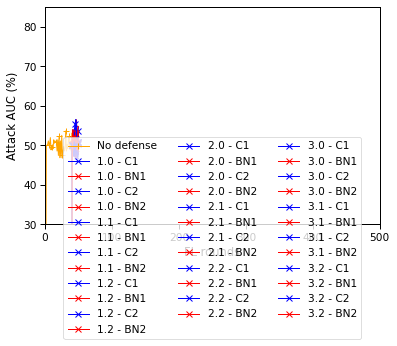

No defense
50
1.0 - C1
50
1.0 - BN1
50
1.0 - C2
50
1.0 - BN2
50
1.1 - C1
50
1.1 - BN1
50
1.1 - C2
50
1.1 - BN2
50
1.2 - C1
50
1.2 - BN1
50
1.2 - C2
50
1.2 - BN2
50
2.0 - C1
50
2.0 - BN1
50
2.0 - C2
50
2.0 - BN2
50
2.1 - C1
50
2.1 - BN1
50
2.1 - C2
50
2.1 - BN2
50
2.2 - C1
50
2.2 - BN1
50
2.2 - C2
50
2.2 - BN2
50
3.0 - C1
50
3.0 - BN1
50
3.0 - C2
50
3.0 - BN2
50
3.1 - C1
50
3.1 - BN1
50
3.1 - C2
50
3.1 - BN2
50
3.2 - C1
50
3.2 - BN1
50
3.2 - C2
50
3.2 - BN2
50


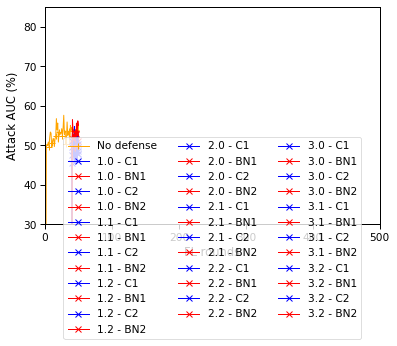

No defense
50
1.0 - C1
50
1.0 - BN1
50
1.0 - C2
50
1.0 - BN2
50
1.1 - C1
50
1.1 - BN1
50
1.1 - C2
50
1.1 - BN2
50
1.2 - C1
50
1.2 - BN1
50
1.2 - C2
50
1.2 - BN2
50
2.0 - C1
50
2.0 - BN1
50
2.0 - C2
50
2.0 - BN2
50
2.1 - C1
50
2.1 - BN1
50
2.1 - C2
50
2.1 - BN2
50
2.2 - C1
50
2.2 - BN1
50
2.2 - C2
50
2.2 - BN2
50
3.0 - C1
50
3.0 - BN1
50
3.0 - C2
50
3.0 - BN2
50
3.1 - C1
50
3.1 - BN1
50
3.1 - C2
50
3.1 - BN2
50
3.2 - C1
50
3.2 - BN1
50
3.2 - C2
50
3.2 - BN2
50


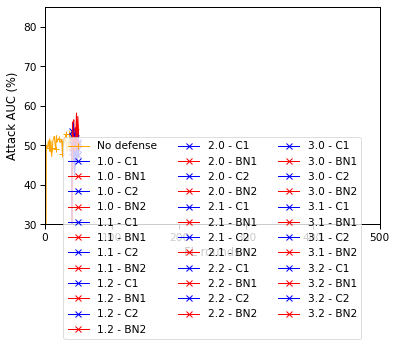

No defense
50
1.0 - C1
50
1.0 - BN1
50
1.0 - C2
50
1.0 - BN2
50
1.1 - C1
50
1.1 - BN1
50
1.1 - C2
50
1.1 - BN2
50
1.2 - C1
50
1.2 - BN1
50
1.2 - C2
50
1.2 - BN2
50
2.0 - C1
50
2.0 - BN1
50
2.0 - C2
50
2.0 - BN2
50
2.1 - C1
50
2.1 - BN1
50
2.1 - C2
50
2.1 - BN2
50
2.2 - C1
50
2.2 - BN1
50
2.2 - C2
50
2.2 - BN2
50
3.0 - C1
50
3.0 - BN1
50
3.0 - C2
50
3.0 - BN2
50
3.1 - C1
50
3.1 - BN1
50
3.1 - C2
50
3.1 - BN2
50
3.2 - C1
50
3.2 - BN1
50
3.2 - C2
50
3.2 - BN2
50


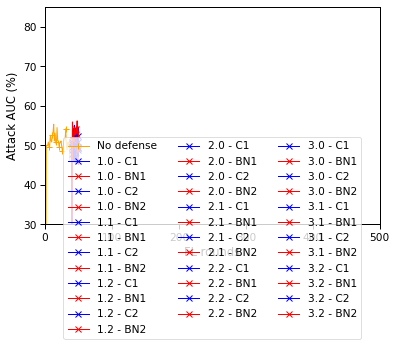

In [160]:
r = 50

generate_histogram(plot_config, "local_model_attack_accuracy_hist", "Attack AUC (%)", "client_auc", 45, 62, average=True, label_rotation=90, std = None, x_fontsize=5, bar_fontsize = 5)
generate_histogram(plot_config, "global_model_attack_accuracy_hist", "Attack AUC (%)", "server_attack", 45, 65, average=True, label_rotation=90, std = None, x_fontsize=5, bar_fontsize = 5)
#generate_xy_plot(plot_config, 'local_models_attack_accuracy', 'Attack AUC (%)', 'client_auc', 0, 100, average=True)
#generate_xy_plot(plot_config, 'global_model_attack_accuracy', 'Attack AUC (%)', 'server_attack', 0, 100, average=True)
#generate_xy_plot(plot_config, 'local_models_accuracy', 'Model accuracy (%)', 'client_accuracy', 0, 100, average=True)
generate_histogram(plot_config, "local_models_accuracy_hist", "Model accuracy (%)", "client_accuracy", 90, 99, average=True, label_rotation=90, x_fontsize=5, bar_fontsize = 5)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy', 'client_auc', 49, 57, 98, 100, average=True,markerscale = 0.5, legend_fontsize=5)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_server', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy', 'server_attack', 49, 52,98 , 100, average=True, markerscale = 0.5, legend_fontsize=5)

generate_xy_plot(plot_config, 'local_model0_accuracy', 'Model accuracy (%)', 'client_accuracy_0', 0, 100, min_x=0, max_x = 50, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model1_accuracy', 'Model accuracy (%)', 'client_accuracy_1', 50, 65, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model2_accuracy', 'Model accuracy (%)', 'client_accuracy_2', 50, 65, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model3_accuracy', 'Model accuracy (%)', 'client_accuracy_3', 50, 65, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model4_accuracy', 'Model accuracy (%)', 'client_accuracy_4', 50, 65, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)

generate_xy_plot(plot_config, 'server_auc', 'Attack AUC (%)', 'server_auc', 45, 55, min_x=400, max_x = 500, average=True,  max_range=r)

generate_xy_plot(plot_config, 'local_model0_auc', 'Attack AUC (%)', 'client_auc_0', 0, 85, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model1_auc', 'Attack AUC (%)', 'client_auc_1', 30, 85, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model2_auc', 'Attack AUC (%)', 'client_auc_2', 30, 85, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model3_auc', 'Attack AUC (%)', 'client_auc_3', 30, 85, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model4_auc', 'Attack AUC (%)', 'client_auc_4', 30, 85, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)

### Layers Analysis Speech Commands

In [201]:
plot_config = {
                "dataset_name": "speechcommands_adagrad_layer_analysis",
                "dataset_pretty_name" : "speechcommands",

                "data":[

                        {
                            "exp_name" : "No defense",
                            "file_path": "ppm_baseline_speechcommands.csv",
                            "color": "orange",
                            "symbol" : "+"
                        },
                          {
                            "exp_name" : "1 - C",
                            "file_path": "ppm_pastel_conv1_true_adagrad_speechcommands.csv",
                            "color": "red",
                            "symbol" : "*"
                        },
                                    
                    
                     {
                            "exp_name" : "1 - BN",
                            "file_path": "ppm_pastel_bn1_true_adagrad_speechcommands.csv",
                            "color": "red",
                            "symbol" : "*"
                        },
                                                                    {
                            "exp_name" : "2 - C",
                            "file_path": "ppm_pastel_conv2_true_adagrad_speechcommands.csv",
                            "color": "purple",
                            "symbol" : "x"
                        },
                                               
                                                {
                            "exp_name" : "2 - BN2",
                            "file_path": "ppm_pastel_bn2_true_adagrad_speechcommands.csv",
                            "color": "purple",
                            "symbol" : "x"
                        },
                                                                                  {
                            "exp_name" : "3 - C",
                            "file_path": "ppm_pastel_conv3_true_adagrad_speechcommands.csv",
                            "color": "green",
                            "symbol" : "x"
                        },
                                                              {
                            "exp_name" : "3 - BN",
                            "file_path": "ppm_pastel_bn3_true_adagrad_speechcommands.csv",
                            "color": "green",
                            "symbol" : "x"
                        },
                    
                                                                                                      {
                            "exp_name" : "4 - C",
                            "file_path": "ppm_pastel_conv4_true_adagrad_speechcommands.csv",
                            "color": "pink",
                            "symbol" : "x"
                        },
                                                                                                      {
                            "exp_name" : "4 - BN",
                            "file_path": "ppm_pastel_bn4_true_adagrad_speechcommands.csv",
                            "color": "pink",
                            "symbol" : "x"
                        },
                                                {
                            "exp_name" : "5 - C",
                            "file_path": "ppm_pastel_conv5_true_adagrad_speechcommands.csv",
                            "color": "yellow",
                            "symbol" : "x"
                        },
                                                                   {
                            "exp_name" : "6 - C",
                            "file_path": "ppm_pastel_conv6_true_adagrad_speechcommands.csv",
                            "color": "green",
                            "symbol" : "x"
                        },
                                                {
                            "exp_name" : "6 - BN",
                            "file_path": "ppm_pastel_bn6_true_adagrad_speechcommands.csv",
                            "color": "green",
                            "symbol" : "x"
                        },
                     
                                           {
                            "exp_name" : "7 - C",
                            "file_path": "ppm_pastel_conv7_true_adagrad_speechcommands.csv",
                            "color": "grey",
                            "symbol" : "x"
                        },
                                           {
                            "exp_name" : "7 - BN",
                            "file_path": "ppm_pastel_bn7_true_adagrad_speechcommands.csv",
                            "color": "grey",
                            "symbol" : "x"
                        },
                                                                    {
                            "exp_name" : "8 - C",
                            "file_path": "ppm_pastel_conv8_true_adagrad_speechcommands.csv",
                            "color": "grey",
                            "symbol" : "x"
                                                },
                                                {
                            "exp_name" : "8 - BN",
                            "file_path": "ppm_pastel_bn8_true_adagrad_speechcommands.csv",
                            "color": "grey",
                            "symbol" : "x"
                                                },
                    
                         {
                            "exp_name" : "9 - C",
                            "file_path": "ppm_pastel_conv9_true_adagrad_speechcommands.csv",
                            "color": "red",
                            "symbol" : "*"
                        },
                                    
                    
                     {
                            "exp_name" : "9 - BN",
                            "file_path": "ppm_pastel_bn9_true_adagrad_speechcommands.csv",
                            "color": "red",
                            "symbol" : "*"
                        },
                                                                    {
                            "exp_name" : "10 - C",
                            "file_path": "ppm_pastel_conv10_true_adagrad_speechcommands.csv",
                            "color": "purple",
                            "symbol" : "x"
                        },
                                               
                                                {
                            "exp_name" : "10 - BN",
                            "file_path": "ppm_pastel_bn10_true_adagrad_speechcommands.csv",
                            "color": "purple",
                            "symbol" : "x"
                        },
                                                                                  {
                            "exp_name" : "11 - C",
                            "file_path": "ppm_pastel_conv11_true_adagrad_speechcommands.csv",
                            "color": "green",
                            "symbol" : "x"
                        },
                                                              {
                            "exp_name" : "11 - BN",
                            "file_path": "ppm_pastel_bn11_true_adagrad_speechcommands.csv",
                            "color": "green",
                            "symbol" : "x"
                        },
                    
                                                                                                      {
                            "exp_name" : "12 - C",
                            "file_path": "ppm_pastel_conv12_true_adagrad_speechcommands.csv",
                            "color": "pink",
                            "symbol" : "x"
                        },
                                                                                                      {
                            "exp_name" : "12 - BN",
                            "file_path": "ppm_pastel_bn12_true_adagrad_speechcommands.csv",
                            "color": "pink",
                            "symbol" : "x"
                        },
                                                {
                            "exp_name" : "13 - C",
                            "file_path": "ppm_pastel_conv13_true_adagrad_speechcommands.csv",
                            "color": "yellow",
                            "symbol" : "x"
                        },
                                                                 {
                            "exp_name" : "13 - C",
                            "file_path": "ppm_pastel_bn13_true_adagrad_speechcommands.csv",
                            "color": "yellow",
                            "symbol" : "x"
                        },
                                                                   {
                            "exp_name" : "14 - C",
                            "file_path": "ppm_pastel_conv14_true_adagrad_speechcommands.csv",
                            "color": "green",
                            "symbol" : "x"
                        },
                                                {
                            "exp_name" : "14 - BN",
                            "file_path": "ppm_pastel_bn14_true_adagrad_speechcommands.csv",
                            "color": "green",
                            "symbol" : "x"
                        },
                     
                                           {
                            "exp_name" : "15 - C",
                            "file_path": "ppm_pastel_conv15_true_adagrad_speechcommands.csv",
                            "color": "grey",
                            "symbol" : "x"
                        },
                                           {
                            "exp_name" : "15 - BN",
                            "file_path": "ppm_pastel_bn15_true_adagrad_speechcommands.csv",
                            "color": "grey",
                            "symbol" : "x"
                        },
                                                                    {
                            "exp_name" : "16 - C",
                            "file_path": "ppm_pastel_conv16_true_adagrad_speechcommands.csv",
                            "color": "grey",
                            "symbol" : "x"
                                                },
                                                {
                            "exp_name" : "16 - BN",
                            "file_path": "ppm_pastel_bn16_true_adagrad_speechcommands.csv",
                            "color": "grey",
                            "symbol" : "x"
                                                },
                                                                                        {
                            "exp_name" : "17 - C",
                            "file_path": "ppm_pastel_conv17_true_adagrad_speechcommands.csv",
                            "color": "grey",
                            "symbol" : "x"
                                                },
                                                {
                            "exp_name" : "17 - BN",
                            "file_path": "ppm_pastel_bn17_true_adagrad_speechcommands.csv",
                            "color": "grey",
                            "symbol" : "x"
                                                },
                                                                    {
                            "exp_name" : "Linear",
                            "file_path": "ppm_pastel_linear_true_adagrad_speechcommands.csv",
                            "color": "grey",
                            "symbol" : "x"
                                                }
                    
                    
                    ]
                }

Columns to aggregate
['client_auc_3', 'client_auc_1', 'client_auc_2', 'client_auc_0', 'client_auc_4']
[58.94117647058823, 57.41176470588235, 58.235294117647065, 58.94117647058823, 57.88235294117647]
Columns to aggregate
['client_auc_3', 'client_auc_1', 'client_auc_2', 'client_auc_0', 'client_auc_4']
[50.94117647058823, 50.588235294117645, 50.8235294117647, 50.8235294117647, 50.70588235294118]
Columns to aggregate
['client_auc_3', 'client_auc_1', 'client_auc_2', 'client_auc_0', 'client_auc_4']
[50.23529411764706, 50.117647058823536, 50.117647058823536, 50.117647058823536, 50.117647058823536]
Columns to aggregate
['client_auc_3', 'client_auc_1', 'client_auc_2', 'client_auc_0', 'client_auc_4']
[50.588235294117645, 50.117647058823536, 50.47058823529412, 50.117647058823536, 50.47058823529412]
Columns to aggregate
['client_auc_3', 'client_auc_1', 'client_auc_2', 'client_auc_0', 'client_auc_4']
[51.64705882352942, 50.47058823529411, 51.52941176470588, 50.8235294117647, 51.29411764705883]
Colu

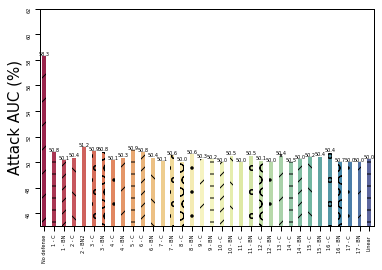

Columns to aggregate
['server_attack']
[55.86827899959928]
Columns to aggregate
['server_attack']
[50.06482332696886]
Columns to aggregate
['server_attack']
[50.010607453504]
Columns to aggregate
['server_attack']
[50.01532187728355]
Columns to aggregate
['server_attack']
[50.18975555712702]
Columns to aggregate
['server_attack']
[50.20625604035547]
Columns to aggregate
['server_attack']
[50.02475072484266]
Columns to aggregate
['server_attack']
[50.01532187728355]
Columns to aggregate
['server_attack']
[50.02475072484266]
Columns to aggregate
['server_attack']
[50.02475072484266]
Columns to aggregate
['server_attack']
[50.01296466539378]
Columns to aggregate
['server_attack']
[50.04360841996088]
Columns to aggregate
['server_attack']
[50.00353581783467]
Columns to aggregate
['server_attack']
[50.02475072484266]
Columns to aggregate
['server_attack']
[50.00589302972445]
Columns to aggregate
['server_attack']
[50.04832284374042]
Columns to aggregate
['server_attack']
[50.00589302972445]

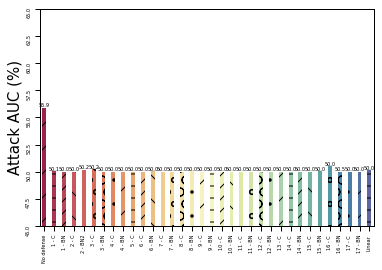

Columns to aggregate
['client_accuracy_3', 'client_accuracy_1', 'client_accuracy_2', 'client_accuracy_0', 'client_accuracy_4']
[85.99915146372507, 86.34799415452788, 86.24899825578655, 86.58841276575686, 86.71097911657945]
Columns to aggregate
['client_accuracy_3', 'client_accuracy_1', 'client_accuracy_2', 'client_accuracy_0', 'client_accuracy_4']
[85.88129920331872, 85.87187102248622, 85.95201055956252, 85.68330740583605, 85.67859331541979]
Columns to aggregate
['client_accuracy_3', 'client_accuracy_1', 'client_accuracy_2', 'client_accuracy_0', 'client_accuracy_4']
[86.77226229199077, 85.55131287418092, 86.30085325036534, 86.71097911657945, 86.29142506953283]
Columns to aggregate
['client_accuracy_3', 'client_accuracy_1', 'client_accuracy_2', 'client_accuracy_0', 'client_accuracy_4']
[86.76283411115826, 85.49002969876962, 86.01800782539009, 85.21189836421063, 87.05982180738226]
Columns to aggregate
['client_accuracy_3', 'client_accuracy_1', 'client_accuracy_2', 'client_accuracy_0', 'c

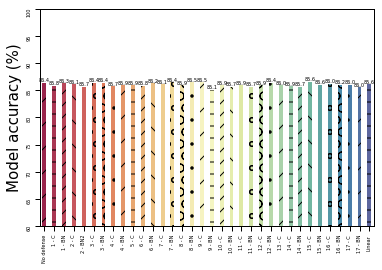

Columns to aggregate
['client_accuracy_3', 'client_accuracy_1', 'client_accuracy_2', 'client_accuracy_0', 'client_accuracy_4']
[85.99915146372507, 86.34799415452788, 86.24899825578655, 86.58841276575686, 86.71097911657945]
Columns to aggregate
['client_auc_3', 'client_auc_1', 'client_auc_2', 'client_auc_0', 'client_auc_4']
[58.94117647058823, 57.41176470588235, 58.235294117647065, 58.94117647058823, 57.88235294117647]
Columns to aggregate
['client_accuracy_3', 'client_accuracy_1', 'client_accuracy_2', 'client_accuracy_0', 'client_accuracy_4']
[85.88129920331872, 85.87187102248622, 85.95201055956252, 85.68330740583605, 85.67859331541979]
Columns to aggregate
['client_auc_3', 'client_auc_1', 'client_auc_2', 'client_auc_0', 'client_auc_4']
[50.94117647058823, 50.588235294117645, 50.8235294117647, 50.8235294117647, 50.70588235294118]
Columns to aggregate
['client_accuracy_3', 'client_accuracy_1', 'client_accuracy_2', 'client_accuracy_0', 'client_accuracy_4']
[86.77226229199077, 85.55131287

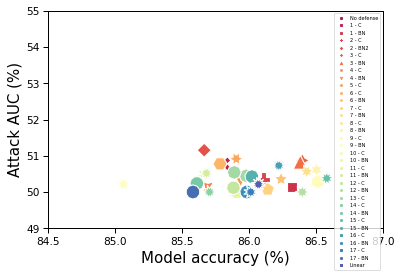

Columns to aggregate
['client_accuracy_3', 'client_accuracy_1', 'client_accuracy_2', 'client_accuracy_0', 'client_accuracy_4']
[85.99915146372507, 86.34799415452788, 86.24899825578655, 86.58841276575686, 86.71097911657945]
Columns to aggregate
['server_attack']
[55.86827899959928]
Columns to aggregate
['client_accuracy_3', 'client_accuracy_1', 'client_accuracy_2', 'client_accuracy_0', 'client_accuracy_4']
[85.88129920331872, 85.87187102248622, 85.95201055956252, 85.68330740583605, 85.67859331541979]
Columns to aggregate
['server_attack']
[50.06482332696886]
Columns to aggregate
['client_accuracy_3', 'client_accuracy_1', 'client_accuracy_2', 'client_accuracy_0', 'client_accuracy_4']
[86.77226229199077, 85.55131287418092, 86.30085325036534, 86.71097911657945, 86.29142506953283]
Columns to aggregate
['server_attack']
[50.010607453504]
Columns to aggregate
['client_accuracy_3', 'client_accuracy_1', 'client_accuracy_2', 'client_accuracy_0', 'client_accuracy_4']
[86.76283411115826, 85.490029

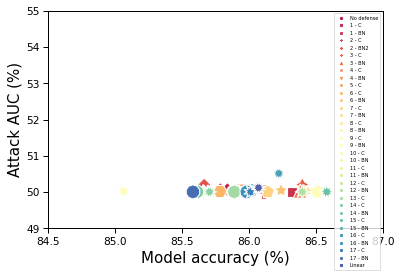

No defense
50
1 - C
50
1 - BN
50
2 - C
50
2 - BN2
50
3 - C
50
3 - BN
50
4 - C
50
4 - BN
50
5 - C
50
6 - C
50
6 - BN
50
7 - C
50
7 - BN
50
8 - C
50
8 - BN
50
9 - C
50
9 - BN
50
10 - C
50
10 - BN
50
11 - C
50
11 - BN
50
12 - C
50
12 - BN
50
13 - C
50
13 - C
50
14 - C
50
14 - BN
50
15 - C
50
15 - BN
50
16 - C
50
16 - BN
50
17 - C
50
17 - BN
50
Linear
50


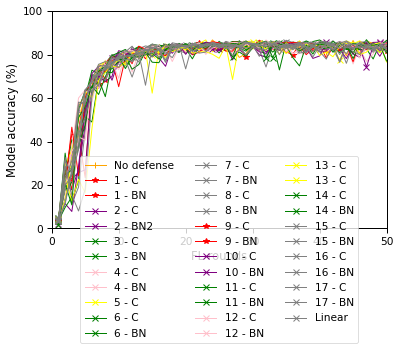

No defense
50
1 - C
50
1 - BN
50
2 - C
50
2 - BN2
50
3 - C
50
3 - BN
50
4 - C
50
4 - BN
50
5 - C
50
6 - C
50
6 - BN
50
7 - C
50
7 - BN
50
8 - C
50
8 - BN
50
9 - C
50
9 - BN
50
10 - C
50
10 - BN
50
11 - C
50
11 - BN
50
12 - C
50
12 - BN
50
13 - C
50
13 - C
50
14 - C
50
14 - BN
50
15 - C
50
15 - BN
50
16 - C
50
16 - BN
50
17 - C
50
17 - BN
50
Linear
50


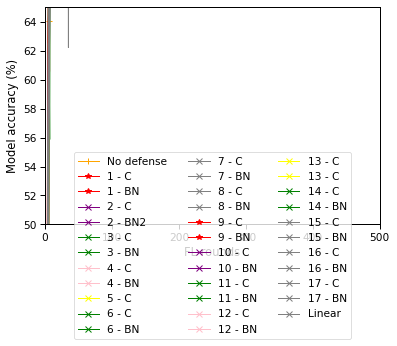

No defense
50
1 - C
50
1 - BN
50
2 - C
50
2 - BN2
50
3 - C
50
3 - BN
50
4 - C
50
4 - BN
50
5 - C
50
6 - C
50
6 - BN
50
7 - C
50
7 - BN
50
8 - C
50
8 - BN
50
9 - C
50
9 - BN
50
10 - C
50
10 - BN
50
11 - C
50
11 - BN
50
12 - C
50
12 - BN
50
13 - C
50
13 - C
50
14 - C
50
14 - BN
50
15 - C
50
15 - BN
50
16 - C
50
16 - BN
50
17 - C
50
17 - BN
50
Linear
50


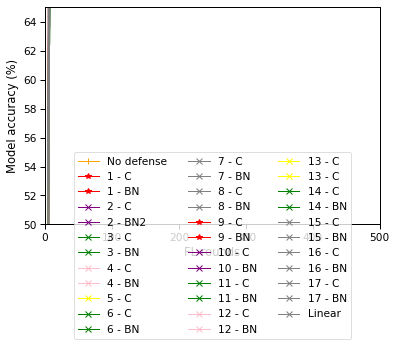

No defense
50
1 - C
50
1 - BN
50
2 - C
50
2 - BN2
50
3 - C
50
3 - BN
50
4 - C
50
4 - BN
50
5 - C
50
6 - C
50
6 - BN
50
7 - C
50
7 - BN
50
8 - C
50
8 - BN
50
9 - C
50
9 - BN
50
10 - C
50
10 - BN
50
11 - C
50
11 - BN
50
12 - C
50
12 - BN
50
13 - C
50
13 - C
50
14 - C
50
14 - BN
50
15 - C
50
15 - BN
50
16 - C
50
16 - BN
50
17 - C
50
17 - BN
50
Linear
50


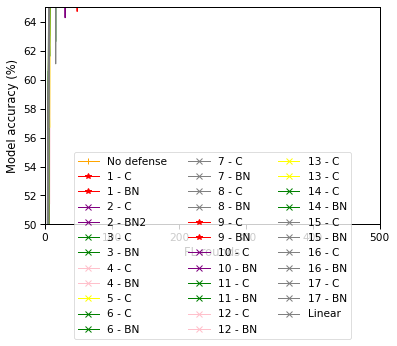

No defense
50
1 - C
50
1 - BN
50
2 - C
50
2 - BN2
50
3 - C
50
3 - BN
50
4 - C
50
4 - BN
50
5 - C
50
6 - C
50
6 - BN
50
7 - C
50
7 - BN
50
8 - C
50
8 - BN
50
9 - C
50
9 - BN
50
10 - C
50
10 - BN
50
11 - C
50
11 - BN
50
12 - C
50
12 - BN
50
13 - C
50
13 - C
50
14 - C
50
14 - BN
50
15 - C
50
15 - BN
50
16 - C
50
16 - BN
50
17 - C
50
17 - BN
50
Linear
50


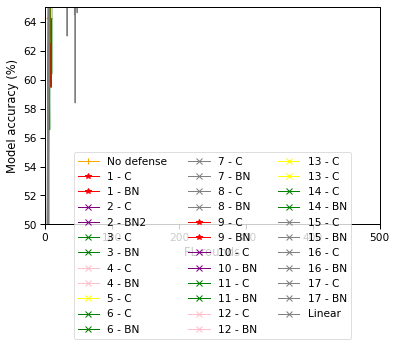

No defense
50
1 - C
50
1 - BN
50
2 - C
50
2 - BN2
50
3 - C
50
3 - BN
50
4 - C
50
4 - BN
50
5 - C
50
6 - C
50
6 - BN
50
7 - C
50
7 - BN
50
8 - C
50
8 - BN
50
9 - C
50
9 - BN
50
10 - C
50
10 - BN
50
11 - C
50
11 - BN
50
12 - C
50
12 - BN
50
13 - C
50
13 - C
50
14 - C
50
14 - BN
50
15 - C
50
15 - BN
50
16 - C
50
16 - BN
50
17 - C
50
17 - BN
50
Linear
50


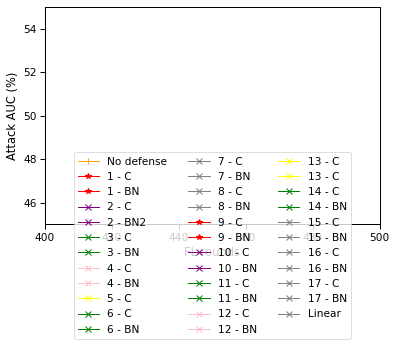

No defense
50
1 - C
50
1 - BN
50
2 - C
50
2 - BN2
50
3 - C
50
3 - BN
50
4 - C
50
4 - BN
50
5 - C
50
6 - C
50
6 - BN
50
7 - C
50
7 - BN
50
8 - C
50
8 - BN
50
9 - C
50
9 - BN
50
10 - C
50
10 - BN
50
11 - C
50
11 - BN
50
12 - C
50
12 - BN
50
13 - C
50
13 - C
50
14 - C
50
14 - BN
50
15 - C
50
15 - BN
50
16 - C
50
16 - BN
50
17 - C
50
17 - BN
50
Linear
50


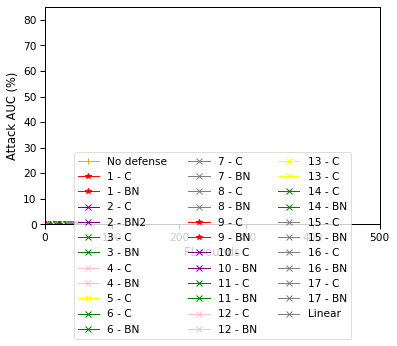

No defense
50
1 - C
50
1 - BN
50
2 - C
50
2 - BN2
50
3 - C
50
3 - BN
50
4 - C
50
4 - BN
50
5 - C
50
6 - C
50
6 - BN
50
7 - C
50
7 - BN
50
8 - C
50
8 - BN
50
9 - C
50
9 - BN
50
10 - C
50
10 - BN
50
11 - C
50
11 - BN
50
12 - C
50
12 - BN
50
13 - C
50
13 - C
50
14 - C
50
14 - BN
50
15 - C
50
15 - BN
50
16 - C
50
16 - BN
50
17 - C
50
17 - BN
50
Linear
50


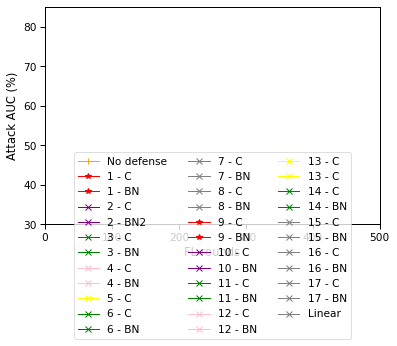

No defense
50
1 - C
50
1 - BN
50
2 - C
50
2 - BN2
50
3 - C
50
3 - BN
50
4 - C
50
4 - BN
50
5 - C
50
6 - C
50
6 - BN
50
7 - C
50
7 - BN
50
8 - C
50
8 - BN
50
9 - C
50
9 - BN
50
10 - C
50
10 - BN
50
11 - C
50
11 - BN
50
12 - C
50
12 - BN
50
13 - C
50
13 - C
50
14 - C
50
14 - BN
50
15 - C
50
15 - BN
50
16 - C
50
16 - BN
50
17 - C
50
17 - BN
50
Linear
50


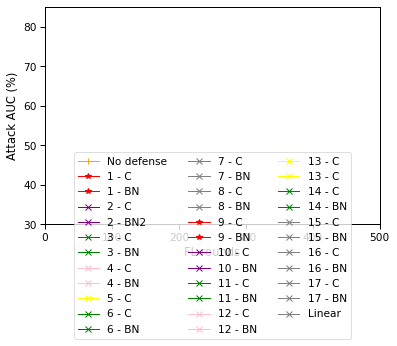

No defense
50
1 - C
50
1 - BN
50
2 - C
50
2 - BN2
50
3 - C
50
3 - BN
50
4 - C
50
4 - BN
50
5 - C
50
6 - C
50
6 - BN
50
7 - C
50
7 - BN
50
8 - C
50
8 - BN
50
9 - C
50
9 - BN
50
10 - C
50
10 - BN
50
11 - C
50
11 - BN
50
12 - C
50
12 - BN
50
13 - C
50
13 - C
50
14 - C
50
14 - BN
50
15 - C
50
15 - BN
50
16 - C
50
16 - BN
50
17 - C
50
17 - BN
50
Linear
50


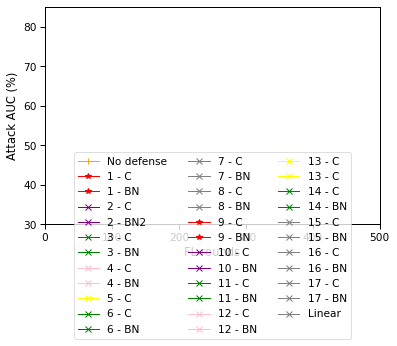

No defense
50
1 - C
50
1 - BN
50
2 - C
50
2 - BN2
50
3 - C
50
3 - BN
50
4 - C
50
4 - BN
50
5 - C
50
6 - C
50
6 - BN
50
7 - C
50
7 - BN
50
8 - C
50
8 - BN
50
9 - C
50
9 - BN
50
10 - C
50
10 - BN
50
11 - C
50
11 - BN
50
12 - C
50
12 - BN
50
13 - C
50
13 - C
50
14 - C
50
14 - BN
50
15 - C
50
15 - BN
50
16 - C
50
16 - BN
50
17 - C
50
17 - BN
50
Linear
50


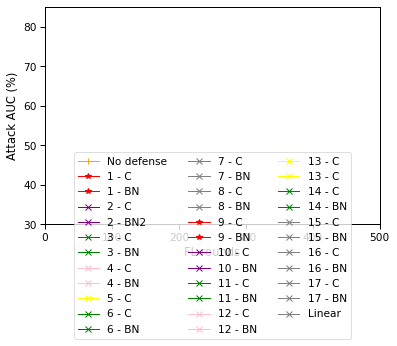

In [170]:
r = 50

generate_histogram(plot_config, "local_model_attack_accuracy_hist", "Attack AUC (%)", "client_auc", 45, 62, average=True, label_rotation=90, std = None, x_fontsize=5, bar_fontsize = 5)
generate_histogram(plot_config, "global_model_attack_accuracy_hist", "Attack AUC (%)", "server_attack", 45, 65, average=True, label_rotation=90, std = None, x_fontsize=5, bar_fontsize = 5)
#generate_xy_plot(plot_config, 'local_models_attack_accuracy', 'Attack AUC (%)', 'client_auc', 0, 100, average=True)
#generate_xy_plot(plot_config, 'global_model_attack_accuracy', 'Attack AUC (%)', 'server_attack', 0, 100, average=True)
#generate_xy_plot(plot_config, 'local_models_accuracy', 'Model accuracy (%)', 'client_accuracy', 0, 100, average=True)
generate_histogram(plot_config, "local_models_accuracy_hist", "Model accuracy (%)", "client_accuracy", 60, 100, average=True, label_rotation=90, x_fontsize=5, bar_fontsize = 5)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_client', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy', 'client_auc', 49, 55, 84.5, 87, average=True, markerscale = 0.5, legend_fontsize=5)
generate_tradeoff_plot(plot_config, 'attack_accuracy_tradeoff_server', 'Model accuracy (%)', 'Attack AUC (%)', 'client_accuracy', 'server_attack', 49, 55, 84.5, 87, average=True, markerscale = 0.5, legend_fontsize=5)

generate_xy_plot(plot_config, 'local_model0_accuracy', 'Model accuracy (%)', 'client_accuracy_0', 0, 100, min_x=0, max_x = 50, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model1_accuracy', 'Model accuracy (%)', 'client_accuracy_1', 50, 65, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model2_accuracy', 'Model accuracy (%)', 'client_accuracy_2', 50, 65, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model3_accuracy', 'Model accuracy (%)', 'client_accuracy_3', 50, 65, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model4_accuracy', 'Model accuracy (%)', 'client_accuracy_4', 50, 65, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)

generate_xy_plot(plot_config, 'server_auc', 'Attack AUC (%)', 'server_auc', 45, 55, min_x=400, max_x = 500, average=True,  max_range=r)

generate_xy_plot(plot_config, 'local_model0_auc', 'Attack AUC (%)', 'client_auc_0', 0, 85, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model1_auc', 'Attack AUC (%)', 'client_auc_1', 30, 85, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model2_auc', 'Attack AUC (%)', 'client_auc_2', 30, 85, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model3_auc', 'Attack AUC (%)', 'client_auc_3', 30, 85, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)
generate_xy_plot(plot_config, 'local_model4_auc', 'Attack AUC (%)', 'client_auc_4', 30, 85, min_x=0, max_x = 500, average=True, extension='.png', max_range=r)